# Noise Learning from Dynamical Decoupling $\pi$ pulse sequences

Central to the problem of noise learning (i.e. given, $C(t)$, compute $S(\omega)$) is inverting the integral in the equation

$$
C_N(t) = e^{-\frac{1}{\pi} \int _{0}^{\infty} d\omega S(\omega) \frac{F_N(\omega, t)}{\omega^2}}
$$

Actually computing this integral in the forward direction (i.e. given $S(\omega)$ compute $C(t)$) is non-trival. Our implementation of this computation is the function `coherence_decay_profile_finite_peaks_with_widths` in `coherence_profile.py`, and we discuss some of the challenges of computing this integral and our approach in `coherence_profile_tutorial.ipynb'

When it comes to inverting this integral, we have identified three (3) potential strategies: 

## 1. Matrix Representation

It is possible to write the integration as a Riemann sum as follows:

\begin{align*}
    -\ln{C_N(t)}&=\int_0^{\infty} \frac{d \omega}{\pi} S(\omega) \frac{F_N(\omega, t)}{\omega^2}\\
    & \approx  \frac{1}{\pi}\sum_{k=0}^{R-1} \Delta \omega_k \frac{F_N\left(\omega_k, t\right)}{\omega_k^2} S\left(\omega_k\right) 
\end{align*}

which can be written as the matrix multiplication

$$
\left[\begin{array}{c}
-\ln C(t_0) \\
-\ln C(t_1) \\
\vdots \\
-\ln C(t_{M-1})
\end{array}\right]
=
\frac{1}{\pi}
\left[\begin{array}{cccc}
\frac{\Delta \omega_0}{\omega_0^2} F_n\left(\omega_0 ,t_0\right) & \frac{\Delta \omega_1}{\omega_1^2} F_n\left(\omega_1, t_0\right) & \cdots & \frac{\Delta \omega{R-1}}{\omega_{R-1}^2} F_n\left(\omega_{R-1}, t_{0}\right)\\
\frac{\Delta \omega_0}{\omega_0^2} F\left(\omega_0, t_1\right) & \frac{\Delta \omega_1}{\omega_1^2} F_n\left(\omega_1, t_1\right) & \cdots & \frac{\Delta \omega_{R-1}}{\omega_{R-1}^2} F_n\left(\omega_{R-1}, t_1\right)\\
\vdots & \cdots & \ddots & \vdots\\
\frac{\Delta \omega_0}{\omega_0^2} F_n\left(\omega_0, t_{M-1}\right) & \frac{\Delta \omega_1}{\omega_1^2} F_n\left(\omega_1, t_{M-1}\right) & \cdots &\frac{\Delta \omega_{R-1}}{\omega_{R-1}^2} F_n\left(\omega_{R-1}, t_{M-1}\right)
\end{array}\right]
\times \left[\begin{array}{c}
S(\omega_0) \\
S(\omega_1) \\
\vdots \\
S(\omega_{R-1})
\end{array}\right]
$$

where $\Delta \omega_k$ is the the width of the $k^{th}$ Riemann polygon. Alternatively, we can write:

$$
\begin{equation}
\mathbf{y} = \mathbf{A} \mathbf{x}
\end{equation}
$$

where:
$$
\begin{align}
\mathbf{y} &= \left[\begin{array}{c}
-\ln C(t_0) \\
-\ln C(t_1) \\
\vdots \\
-\ln C(t_{M-1})
\end{array}\right], \quad
\mathbf{x} = \left[\begin{array}{c}
S(\omega_0) \\
S(\omega_1) \\
\vdots \\
S(\omega_{R-1})
\end{array}\right] \\[1em]
\mathbf{A}_{ij} &= \frac{1}{2\pi} \frac{\Delta \omega_j}{\omega_j^2} F_n(\omega_j, t_i)
\end{align}
$$

where $\mathbf{y}$ is known from the experimental data, $\mathbf{A}$ is known from knowledge of the filter function, and $\mathbf{x}$ is unknown. In general, $R>>M$ because we are experimentally limited with the number of $C(t)$ data points we can collect, but we want as much resolution in $\omega$ as possible to capture the high frequency behavior of the filter function. So, this linear equation is underdetermined, meaning that it can have many distinct solutions. 

In principle, solving this linear system would be ideal, using, for example, the least-norm solution as it would be ***anzatz agnostic*** in that it would not require any prior knowledge of the functional form of $S(\omega)$. However, in practice, because the system is underdetermined, no unique solution exists, and in simulated experiments, the $S(\omega)$ "learned" through the least-norm solution or similar methods does not frequently align with the true $S(\omega)$. The `FWDD` package does not have code supporting this method, but it is worthy of mention and future research becasue of the three methods we mention here, this is the only one that is truely ***anzatz agnostic***.

## 2. Machine Learning 

Two previous studies explored the use of machine learning to sompute the $C(t) \rightarrow S(\omega)$ direction [[Wise, Morton, and Dhomkar](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.010316), [Meneses rt. al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.18.024004)] (The former has some mis-typed equations, so defer to the latter paper to save yourself confusion).

The notion is that given many training examples of $\left[C(t),S(\omega)\right]$ pairs generated by doing the "easy" direction of computing $S(\omega) \rightarrow C(t)$ synthetically many times, an appropriate neural network can learn the inversion.

The networks to achieve this task need not be large, thus this method has the advantage of being incredibly fast at inference time (O(seconds)). Given some experimental $C(t)$, a neural network can quickly output an accurate estimate of $S(\omega)$. This is useful in contexts where feedback about noise is time-sensitive. One can imagine a setting where $S(\omega)$ changes over time, and needs to be re-learned on the fly.

Using machine learning has two drawbacks. 
1. First, computing the integral in the forward $S(\omega) \rightarrow C(t)$ direction is not as "easy" as it sounds. Parallelized across all 20 CPUs in a AMD Ryzen AL 9 365, one integration took approximately 30 seconds. Generating tens of thousands of training examples can take days or weeks of computation, especially when you consider different $N$ cases. 
2. Second, this approach is not ***anzatz agnostic***. When you generate the training data, you need to assume the functional form of $S(\omega)$ to compute the associated $C(t)$ examples. Generalization is a notroiously difficult problem for neural networks. The neural network you train will only work well when the $C(t)$ curves you collect experimentally are generated by the types of noise PSD, $S(\omega)$ that you train on. 

While we do not employ neural networks in our paper, we have included some (incomplete) code to do so in this package...

## 3. Optimization (Our Approach)

Given a functional anzatz for $S(\omega)$, we can parameterize the coherence integral in terms of that function. Then, we can use traditional numerical fitting techniques to find the parameters that yield the $C(t)$ profile that best fits with the experientally observed data. Like machine learning, this method requires some anzatz of the functional form of $S(\omega)$, and is slower at inference time due to the need for an optimization algorithm to execute, but it does not require the costly generation of thousands of training examples. 

In [our paper](https://arxiv.org/abs/2509.08984), we first fit eash $C_N(t)$ to 1/f noise of the form $S(\omega) = \frac{A}{\omega^\alpha}$, then we use these individually recovered noise spectra to fit a double power law noise profile to explain the observed $C_N(t)$.

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error

from tqdm.contrib import tenumerate

from package import noise_spectra as ns
from package import coherence_profile as cp
from package.noise_learning_fitting import func_to_fit, fit_coherence_decay, fit_noise_spectrum, fit_coherence_decay_combined
from package.fitting_utils import find_widest_contiguous_stretch, find_time_range_for_C_t_bounds, add_gaussian_noise, format_parameters, create_combined_analysis_plot, calculate_total_combinations, bootstrap_multiple_samples, analyze_intervals

# Fitting S(ω) to Experimental C(t) data

Let's Examine how to fit experimental C(t) data to a given noise model. First, we will load some example experimental data from `data/example_XY8data_normtotpi1.json`. Due to noise in the $C(t)$ signal, you may find it useful to examine the time range where $C(t)$ changes most significantly. To enable this, we introduce the parameter $\epsilon$ below, to elucidate where:

$$
\epsilon <= C(t) <= 1- \epsilon
$$

Later, we will have $\epsilon = \sigma$ where $\sigma$ is the standard deviation of experimentally observed $C(t)$ from the $C(t)$ produced by a best fit of a $\frac{A}{\omega^\alpha}$ noise model.

13 25


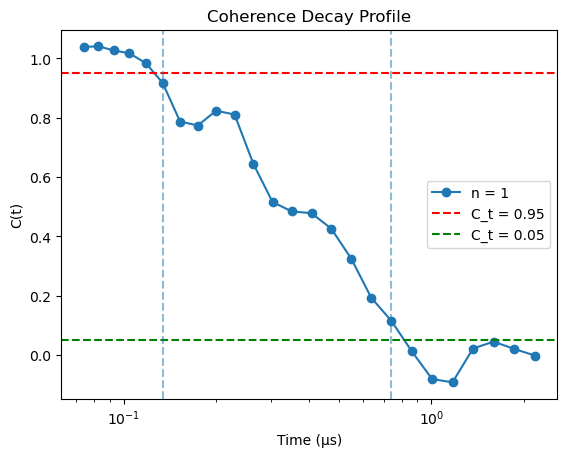

26 70


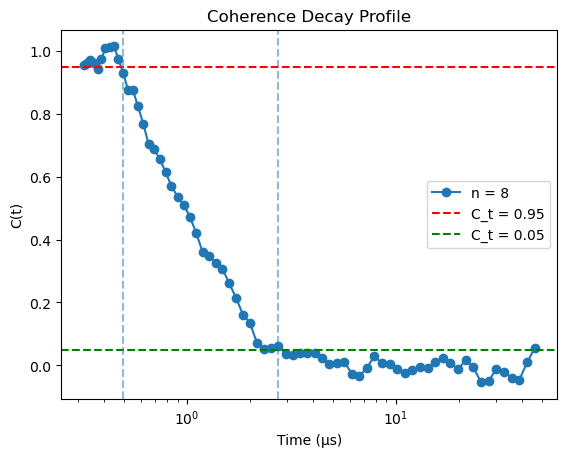

8 35


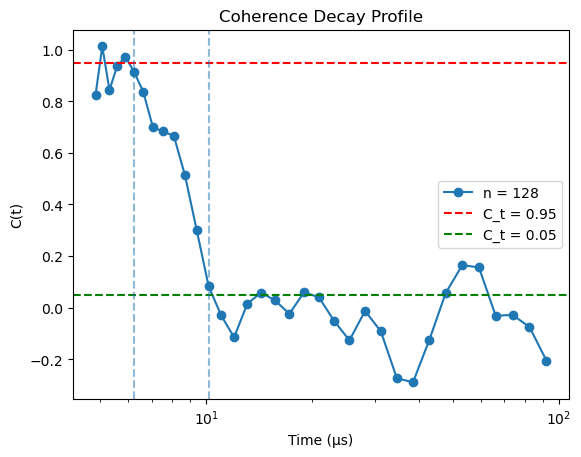

13 26


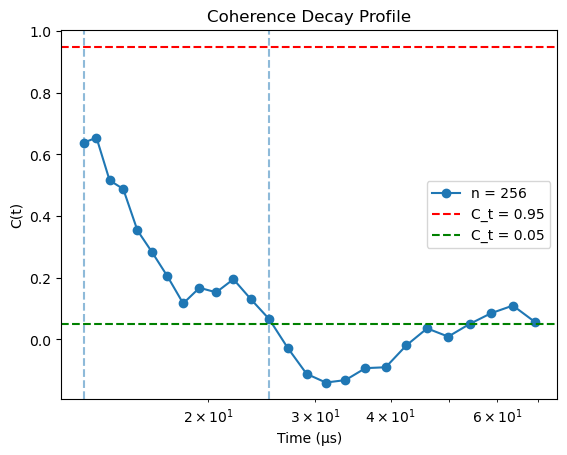

5 11


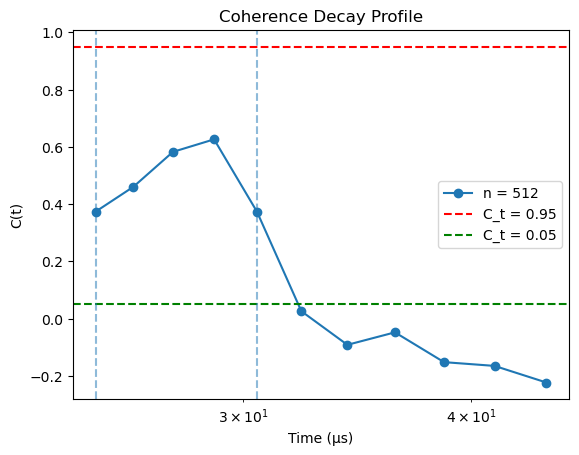

In [2]:
# loads C(t) from data file, which is in the form of a dictionary with keys "N_pi", "time_points", and "C_t".
# with open("XY8data_forNoah.json","r") as file:
with open("data/example_XY8data_normtotpi1.json","r") as file:
    data = json.load(file)
# Re-format as a pandas dataframe for easier handling
del data["y_fit"]
df = pd.DataFrame(data)

eps = 0.05

for n in data["N_pi"]:
    n_df = df[df["N_pi"]==n]
    C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
    t_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() #multiply by 10^-3 to convert from ns to µs

    emem = find_widest_contiguous_stretch(C_t_observed, eps, 1-eps)

    print(len(emem),len(t_points))

    plt.plot(t_points,C_t_observed,label=f"n = {int(n)}",marker='o')
    # plt.axvline(x=n*0.024,linestyle='--',label=f"t = n*tau_pi= {n*0.024} µs", alpha=0.5)
    plt.axhline(y=1-eps, color='r', linestyle='--', label=f'C_t = {1-eps:.2f}')
    plt.axhline(y=eps, color='g', linestyle='--', label=f'C_t = {eps:.2f}')
    plt.axvline(x=t_points[emem[0]],linestyle='--', alpha=0.5)
    plt.axvline(x=t_points[emem[-1]],linestyle='--', alpha=0.5)

    plt.title(f"Coherence Decay Profile")
    plt.xscale('log')
    plt.ylabel('C(t)')
    plt.xlabel('Time (µs)')
    plt.legend()
    plt.show()

# Parameters for Fitting

In the cell below, we have example of using fitting to predict the noise spectrum from observed $C_N(t)$. If you have your own $C_N(t)$ data, you can just replace mentions of the `.json` file with your own. Alternatively, you can set `experimental_data = False` to create artifical $C_N(t)$ from the specified noise spectra. In this case, you should find that the noise learned from a global optimization method such as differential evolution should exactly re-produce the underlying $S(\omega)$. That is, without $C_N(t)$ noise, and the right model for $S(\omega)$ performing this optimization should find $S(\omega)$ given $C_N(t)$. If `noise = True`, then noise of the specified level can be added to the artifical $C_N(t)$.

## Optimize $N$ cases together or separately?

We allow for the individual optimization of each $C_N(t)$ individually, thus finding a (potentially) different $S(\omega)$ for each, or optimizing then jointly, with an objective function that equally-weights the mean-squared error (or Huber loss) of each $C_N(t)$ fit. The paramter to toggle this is `combined_loss`.

## Other Considerations

We also include for your convenience a scaling parameter `F`. Theoretically, $0 <= C_n(t) <= 1$; however, if your $C_N(t)$ is not normalized, you can set `F` such that $0 <= F*C_n(t) <= 1$.

In this tutorial notebook, `delta_approx = True` to speed up computation. In practice, you may wish to use the full filter function by setting this parameter to False.

We reccomend using differential evolution (`meth = "diff_ev"`) for optimization, as it is a robust golbal optimizer (we also have the final result automatically polished by one round of the local optimizer "L-BFGS-B"). But, we also provide options for Gaussian Processes optimization "gp_minimize" and striaght-up local optimization with "L-BFGS-B". While it may seem that the optimization has many moving parts, the most important are the `bounds` variable, which sets the search space bounds for each parameter to be optimized, and the `population` and `iterations` variables, which control the global search algorithms. You can learn more about what they do in the `scipy` documentation, but in short, the larger they are the better the optimization results, but the longer the computation time.

For more details on our specific implementation, see `fit_coherence_decay` and `fit_coherence_decay_combined` in `noise_learning_fitting.py`.

## *NOTE: In `noise_learning_fitting.sbatch` we have provided a SLURM file structure so that you can run this optimization on a high performance computing cluster*

In [3]:
experimental_data = True # If True, loads experimental data from json file. If False, uses artificially simulated data.

### Dynamical Decoupling sequence parameters ###
n_values = [1,8,128,256,512]
tau_p = 0.024 # pi pulse width in microseconds. The filter function code assumes equally-spaced pi pulses with finite width tau_p.

### Finite-width filter function and integration parameters ###
integration_method = "trapezoid" # The method to use for integration. Options are "quad","trapezoid",and "simpson".
omega_resolution = int(6*10**5) # The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
omega_range = (10**(-4), 10**8) # The number of peaks to use in the filter function
num_peaks_cutoff = 100 # Number of peaks to use in the integration. Must be >=0. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
peak_resolution = 100 # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.

### Noise model parameters ###
# FYI each of these can be any non-negative integer, including zero.
N1f = 1 # Number of 1/f noise profiles present. Each profile has parameters A and alpha. So, a total of 2*N1f parameters.
Nlor = 0 # Number of Lorentzian noise profiles present. Each profile has parameters omega_0, gamma, and A. So, a total of 3*Nlor parameters.
NC = 0 # Number of white noise profiles present. Each profile has parameter C. So, a total of NC parameters. Since white noise is flat, it is equivalent to a single white noise profile with C equal to the sum of all individual C values, so you should never need to set NC to be greater than 1.
Ndpl = 0 # Number of double power law noise profiles present. Each profile has parameters A, alpha, beta, gamma. So, a total of 4*Ndpl parameters.

# Set this to True to use combined loss across all n values in the Dynamical Decoupling sequence. If True, finds the noise profile that best fits all C_n(t) values simultaneously. If False, fits each n value separately.
combined_loss = False  # Set to False to use original separate fitting

### Optimization options ###
meth = "diff_ev"  # Options: "L-BFGS-B", "diff_ev", "gp_minimize"
loss_type = "mse"  # Options: "mse", "huber"
delta_approx = True # Use delta approximation for the noise spectrum, i.e. S(omega) = A*delta(omega - n*pi/tau_p)

# whether to include Gaussian noise in the simulated C(t) data, and if so, the strength of that noise.
noise = False
noise_lvl = 0.04

# Scaling factor for C(t). F=1 Implies that C(t) begins at 1. You can change this to account for experimental imperfections that reduce the initial coherence. For example, if the initial coherence is 0.9, set F=0.9.
F = 1

# Set the range of C(t). If 0 < eps < 1, then C_t_max = 1-eps and C_t_min = eps. Otherwise, C_t_max = 2 and C_t_min = -2, Which just considers the full range of 0 < C(t) < 1.

eps = 0
if 0 < eps < 1:
    C_t_max = 1 - eps
    C_t_min = eps
else:
    C_t_max = 2
    C_t_min = -2


############################################################################
print("Using experimental data:", experimental_data)
print("Combined Loss:", combined_loss)
print("Optimization Method:", meth)
print("Loss Function Type:", loss_type)
print("Delta Approximation:", delta_approx)

print("Included Gaussian Noise:", noise)
if noise:
    print("Noise Level:", noise_lvl)

print(f"C(t) scaling factor, F = {F}")


if 0 < C_t_max < 1:
    print_C_t_max = C_t_max
else:
    print_C_t_max = 1
if 0 < C_t_min < 1:
    print_C_t_min = C_t_min
else:
    print_C_t_min = 0
print(f"C(t) Range: [{print_C_t_min}, {print_C_t_max}]")

results_dict = {}


print("N values to fit:", n_values)


if experimental_data:
    global_filepath = './fitting/experimental_data_fits/'
else:
    global_filepath = './fitting/optimization_fits/'

finite_width_params = {
    "N1f": N1f, # Number of 1/f noise parameters
    "Nlor": Nlor, # Number of Lorentzian noise parameters
    "NC": NC, # Number of white noise parameters
    "Ndpl": Ndpl, # Number of double power law noise parameters
    "tau_p": tau_p, #pi pulse width in mircoseconds
    "integration_method": integration_method, # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": omega_resolution, # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : omega_range, # The number of peaks to use in the filter function
    "num_peaks_cutoff": num_peaks_cutoff, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": peak_resolution, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    # Additional parameters for the "quad" integration method. Not used here since we are using Riemann sum methods.
    # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
}

# Extract counts
N1f = finite_width_params["N1f"]
Nlor = finite_width_params["Nlor"] 
NC = finite_width_params["NC"]
Ndpl = finite_width_params["Ndpl"]

# Initialize noise_params list with 4 empty dictionaries
noise_params = [{}, {}, {}, {}]

# Generate 1/f noise parameters
if N1f > 0:
    A_1f = np.random.choice(np.linspace(0, 100, 1001), size=N1f)
    alpha_1f = np.random.choice(np.linspace(0, 3, 1001), size=N1f)
    noise_params[0] = {"A": A_1f.tolist(), "alpha": alpha_1f.tolist()}

# Generate Lorentzian noise parameters  
if Nlor > 0:
    omega_0_lor = np.random.choice(np.linspace(1e-3, 1e8, 10001), size=Nlor)  # Central frequency range
    gamma_lor = np.random.choice(np.linspace(1e-4, 1e6, 10001), size=Nlor)    # Half-width range
    A_lor = np.random.choice(np.linspace(0, 100, 1001), size=Nlor)            # Amplitude range
    noise_params[1] = {
        "omega_0": omega_0_lor.tolist(), 
        "gamma": gamma_lor.tolist(), 
        "A": A_lor.tolist()
    }

# Generate white noise parameters
if NC > 0:
    C_white = np.random.choice(np.linspace(0, 5, 1001), size=NC)
    noise_params[2] = {"C": C_white.tolist()}

# Generate combined fraction noise parameters
if Ndpl > 0:
    A_frac = np.random.choice(np.linspace(0, 1e2, 1001), size=Ndpl)
    alpha_frac = np.random.choice(np.linspace(0, 4, 1001), size=Ndpl)
    beta_frac = np.random.choice(np.linspace(0, 1e4, 10001), size=Ndpl)
    gamma_frac = np.random.choice(np.linspace(1e-4, 1e2, 1001), size=Ndpl)
    noise_params[3] = {
        "A": A_frac.tolist(),
        "alpha": alpha_frac.tolist(), 
        "beta": beta_frac.tolist(),
        "gamma": gamma_frac.tolist()
    }

# Print the generated parameters for verification
print("Generated noise_params:")
for i, param_dict in enumerate(noise_params):
    param_names = ["f_params", "lor_params", "white_params", "double_power_law_params"]
    print(f"{param_names[i]}: {param_dict}")
    
# # You can also print individual parameter values like in your original code
# if noise_params[0]:  # If 1/f params exist
#     print(f"\n1/f noise - A values: {noise_params[0]['A']}")
#     print(f"1/f noise - alpha values: {noise_params[0]['alpha']}")
    
# if noise_params[2]:  # If white noise params exist  
#     print(f"White noise - C values: {noise_params[2]['C']}")
    
# if noise_params[1]:  # If Lorentzian params exist
#     print(f"Lorentzian noise - omega_0 values: {noise_params[1]['omega_0']}")
#     print(f"Lorentzian noise - gamma values: {noise_params[1]['gamma']}")
#     print(f"Lorentzian noise - A values: {noise_params[1]['A']}")
    
# if noise_params[3]:  # If double power law params exist
#     print(f"Double power law - A values: {noise_params[3]['A']}")
#     print(f"Double power law - alpha values: {noise_params[3]['alpha']}")
#     print(f"Double power law - beta values: {noise_params[3]['beta']}")
#     print(f"Double power law - gamma values: {noise_params[3]['gamma']}")

# First pass: Generate C_t_observed for all n values
C_t_observed_dict = {}
times_dict = {}
fixed_kwargs_dict = {}

# Create save directory structure
subfolder_str_1 = f"tau_p{finite_width_params['tau_p']}/"
subfolder_str_2 = f"N1f{finite_width_params['N1f']}_Nlor{finite_width_params['Nlor']}_NC{finite_width_params['NC']}_Ndpl{finite_width_params['Ndpl']}/"

save_dir = global_filepath + subfolder_str_1 + subfolder_str_2

if combined_loss:
    save_dir += "combined_loss/"
if delta_approx:
    save_dir += "delta_approx/"
else:
    save_dir += "finite_width_FF/"

if not experimental_data:
    if noise:
        print(f"Gaussian σ: {noise_lvl}")
        save_dir += f"gaussian_noise_{noise_lvl}/"
    else:
        save_dir += "without_noise/"

save_dir += f"F{F}/"
save_dir += f"C_t_max{C_t_max:.4f}_min{C_t_min:.4f}/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

# Find all existing run directories
existing_runs = []
for item in os.listdir(save_dir):
    if item.startswith("run") and os.path.isdir(os.path.join(save_dir, item)):
        try:
            # Extract the number from "runX"
            run_num = int(item[3:])  # Remove "run" prefix
            existing_runs.append(run_num)
        except ValueError:
            # Skip if the suffix isn't a number
            continue

# Determine next run number
next_run = max(existing_runs) + 1 if existing_runs else 0

# Create the directory
save_dir = os.path.join(save_dir, f"run{next_run}/")
os.makedirs(save_dir, exist_ok=True)

Using experimental data: True
Combined Loss: False
Optimization Method: diff_ev
Loss Function Type: mse
Delta Approximation: True
Included Gaussian Noise: False
C(t) scaling factor, F = 1
C(t) Range: [0, 1]
N values to fit: [1, 8, 128, 256, 512]
Generated noise_params:
f_params: {'A': [85.5], 'alpha': [0.276]}
lor_params: {}
white_params: {}
double_power_law_params: {}


# You have included four models for $S(\omega)$, what if I want to add my own?

Great question! Adding additional noise models should (hopefully) be realtively painless. 

1. Define a function, that implements $S(\omega; a,b,c,...)$ for parameters $(a,b,c,...)$ in `noise_spectra.py`.
2. In `noise_spectra.py` edit `noise_spectrum_combination` to handle your noise model.
3. Define a parameter `Nyourmodel` and append it anywhere you see the other models come up (e.g. where you see `finite_width_params['Nlor']`).  You will also need to ocassionally define input parameters such as when using "L-BFGS-B" for local optimization. This step will require the most careful read through of the code base, but hopefully it isn't to burdensome. 
4. (Optional) If your noise model has some constraint, like the $\beta > \alpha $ constraint in our double power law model, you will have to add that constraint to 'create_coherence_parameter_constraints' and 'create_parameter_constraints' in `noise_learning_fitting.py`. Additionally, if you want pretty printing for plotting etc. outlined in this notebook, you will also have to edit `format_parameters` in `fitting_utils.py` to handle your new noise function.

# Performing the fitting

In [4]:
for n in n_values:
    results_dict[n] = {}

    finite_width_params = {
        "N1f": N1f, # Number of 1/f noise parameters
        "Nlor": Nlor, # Number of Lorentzian noise parameters
        "NC": NC, # Number of white noise parameters
        "Ndpl": Ndpl, # Number of double power law noise parameters
        "N": n, #CPMG-N (test spin echo)
        "tau_p": tau_p, #pi pulse width in mircoseconds
        "integration_method": integration_method, # The method to use for integration. Options are "quad","trapezoid",and "simpson".
        "omega_resolution": omega_resolution, # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
        "omega_range" : omega_range, # The number of peaks to use in the filter function
        "num_peaks_cutoff": num_peaks_cutoff, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
        "peak_resolution": peak_resolution, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
        # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
        # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
        # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
    }

    results_dict[n]["F"] = F
    results_dict[n]["finite_width_params"] = finite_width_params
    results_dict[n]["true_params"] = noise_params


    if experimental_data:
        with open("data/example_XY8data_normtotpi1.json","r") as file:
            data = json.load(file)

        print(f"Using experimental data for n={n}")
        del data["y_fit"]
        df = pd.DataFrame(data)

        n_df = df[df["N_pi"]==n]
        t_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten()
        C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
        t_points = t_points[find_widest_contiguous_stretch(C_t_observed, C_t_min, C_t_max)]
        C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, C_t_min, C_t_max)]

    else:
        # Find time range
        t_start, t_end = find_time_range_for_C_t_bounds(
            C_t_max, C_t_min,
            finite_width_params,
            ns.noise_spectrum_combination,
            noise_params,
            delta=delta_approx
        )

        if not delta_approx and t_start is not None:
            t_start = max(t_start, finite_width_params["N"] * finite_width_params["tau_p"] + 1e-10)

        time_resolution = 51 # Number of time points to use in the C(t) profile
        if t_start is not None and t_end is not None:
            t_points = np.logspace(np.log10(t_start), np.log10(t_end), time_resolution)
            print(f"N={n}: Time range: {t_start:.6f} to {t_end:.6f}")
        else:
            print(f"N={n}: Could not find both crossing points")
            t_points = np.logspace(np.log10(finite_width_params["N"]*finite_width_params["tau_p"]+1e-10), np.log10(300), time_resolution)

    results_dict[n]["t_points"] = t_points
    
    # Update omega range
    w_min = n*np.pi/(np.max(t_points))
    w_max = n*np.pi/(np.min(t_points))
    finite_width_params["omega_range"] = (10**np.floor(np.log10(w_min)), 
                                        np.max([10**(np.ceil(np.log10(w_max))),
                                                10**(np.floor(np.log10(w_min))+4)]))
    
    # Generate C_t_observed
    if experimental_data:
        results_dict[n]["C(t)_true"] = C_t_observed
        print(f"N={n}: C(t) Range:", (np.max(C_t_observed), np.min(C_t_observed)))
        if noise:
            C_t_dirty = C_t_observed.copy()
            results_dict[n]["C(t)_dirt"] = C_t_dirty
    else:
        C_t_observed = func_to_fit(t_points, ns.noise_spectrum_combination, *noise_params, delta=delta_approx, **finite_width_params)
        C_t_observed = F * C_t_observed 

        results_dict[n]["C(t)_true"] = C_t_observed
        print(f"N={n}: C(t) Range:", (np.max(C_t_observed), np.min(C_t_observed)))

        # Add noise if specified
        if noise:
            C_t_clean = C_t_observed.copy()
            C_t_observed, _ = add_gaussian_noise(C_t_observed, noise_level=noise_lvl, noise_type='absolute')
            C_t_dirty = C_t_observed.copy()
            results_dict[n]["C(t)_dirt"] = C_t_dirty
            print(f"N={n}: MSE Between true C(t) and noisy C(t):", mean_squared_error(C_t_clean, C_t_observed))

    # Store for combined fitting
    C_t_observed_dict[n] = C_t_observed
    times_dict[n] = t_points
    fixed_kwargs_dict[n] = finite_width_params

if combined_loss:
    # for Lorentzian noise, omega_0 is fixed at 0 for all n values since a non-zero value would be unphysical.
    bounds = finite_width_params["N1f"]*[(0,10**4),(0,10)] + finite_width_params["Nlor"]*[(0,10**4),(0, 0),(0,10**4)] + finite_width_params["NC"]*[(0,10)]+ finite_width_params["NC"]*[(0,10)] + finite_width_params["Ndpl"]*[(0,10**6),(0,10),(0, 10),(1e-10, 10**4)]
    print("\n=== COMBINED LOSS OPTIMIZATION ===")
    print("Fitting parameters to minimize combined loss across all n values...")
    
    # if local optimization, use multiple random initial guesses to avoid local minima
    if meth == "L-BFGS-B":
        r = 10 if not delta_approx else 50
    else:
        r = 1 

    best_combined_loss = np.inf
    best_combined_result = None
    all_combined_results = []  # Store all results for error analysis
    
    for k in range(r):
        if k == 0:
            # Use fixed initial guess for first run, so that you can customize if you want a specific starting point
            initial_args = [{'A': [10]*finite_width_params["N1f"], 'alpha': [1]*finite_width_params["N1f"]}, 
                           {"A": [1]*finite_width_params["Nlor"], 
                            "omega_0": [0]*finite_width_params["Nlor"], 
                            "gamma": [1]*finite_width_params["Nlor"]}, 
                           {'C': [0]*finite_width_params["NC"]},
                           {'A': [1]*finite_width_params["Ndpl"], 
                            'alpha': [1]*finite_width_params["Ndpl"], 
                            'beta': [2]*finite_width_params["Ndpl"], 
                            'gamma': [1]*finite_width_params["Ndpl"]}]
        else:
            # Generate alpha first
            alpha_vals = np.random.uniform(low=0, high=10, size=(finite_width_params["Ndpl"],))
            # Generate beta such that beta > alpha
            beta_vals = np.random.uniform(low=alpha_vals, high=10, size=(finite_width_params["Ndpl"],))

            initial_args = [{'A': list(np.random.uniform(low=1, high=10**12, size=(finite_width_params["N1f"],))),
                            'alpha': list(np.random.uniform(low=0, high=10, size=(finite_width_params["N1f"],)))},
                            {"A": list(np.random.uniform(low=1, high=10**8, size=(finite_width_params["Nlor"],))),
                                "omega_0": list(np.random.uniform(low=0, high=0, size=(finite_width_params["Nlor"],))),
                                "gamma": list(np.random.uniform(low=0, high=10**4, size=(finite_width_params["Nlor"],)))},
                            {'C': list(np.random.uniform(low=0, high=10, size=(finite_width_params["NC"],)))},
                            {'A': list(np.random.uniform(low=1, high=10**6, size=(finite_width_params["Ndpl"],))),
                                'alpha': list(alpha_vals),
                                'beta': list(beta_vals),
                                'gamma': list(np.random.uniform(low=1, high=10**4, size=(finite_width_params["Ndpl"],)))}]

        # Run combined optimization
        # We have pre-selected values for population and iterations based on trial and error to balance speed and accuracy. You can adjust these if you want.
        optimized_args, optimized_errors, opt_result = fit_coherence_decay_combined(
            C_t_observed_dict, times_dict, ns.noise_spectrum_combination, initial_args, 
            fixed_kwargs_dict, n_values, bounds, method=meth, delta=delta_approx, 
            loss_type=loss_type, noise_level=noise_lvl, population=500 if delta_approx else 10, iterations=1000 if delta_approx else 200
        )

        # Store all results for error analysis
        all_combined_results.append((optimized_args, optimized_errors, opt_result))

        if opt_result.fun < best_combined_loss:
            best_combined_loss = opt_result.fun
            best_combined_result = (optimized_args, optimized_errors, opt_result)
            print(f"New best combined loss: {best_combined_loss} at iteration {k+1}")
            print(f"Combined optimized parameters: {optimized_args}")
    
    # Calculate parameter statistics if r > 1
    if r > 1:
        print("\n=== PARAMETER STATISTICS FROM MULTIPLE RUNS ===")
        
        # Extract parameter values from all runs
        param_values = {'A': [], 'alpha': [], 'C': []}
        
        for optimized_args, _, _ in all_combined_results:
            # Extract A values
            if optimized_args[0].get('A'):
                param_values['A'].extend(optimized_args[0]['A'])
            
            # Extract alpha values
            if optimized_args[0].get('alpha'):
                param_values['alpha'].extend(optimized_args[0]['alpha'])
            
            # Extract C values
            if len(optimized_args) > 2 and optimized_args[2].get('C'):
                param_values['C'].extend(optimized_args[2]['C'])
        
        # Calculate statistics
        param_stats = {}
        for param_name, values in param_values.items():
            if values:  # Only calculate if we have values
                param_stats[param_name] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'median': np.median(values),
                    'values': values
                }
                print(f"{param_name}: mean={param_stats[param_name]['mean']:.4f} ± {param_stats[param_name]['std']:.4f}")
                print(f"  Range: [{param_stats[param_name]['min']:.4f}, {param_stats[param_name]['max']:.4f}]")
                print(f"  Median: {param_stats[param_name]['median']:.4f}")
        
        # Store parameter statistics
        combined_param_stats = param_stats
    else:
        combined_param_stats = None
    
    # Store the best result for all n values
    for n in n_values:
        results_dict[n]["optimized_args"] = best_combined_result[0]
        results_dict[n]["optimized_errors"] = best_combined_result[1]
        results_dict[n]["opt_result"] = best_combined_result[2]
        results_dict[n]["all_optimization_results"] = all_combined_results
        results_dict[n]["parameter_statistics"] = combined_param_stats
    
    print(f"\nFinal combined loss: {best_combined_loss}")
    print(f"Final combined parameters: {best_combined_result[0]}")

else:
    print("\n=== INDIVIDUAL OPTIMIZATION ===")
    print("Fitting parameters separately for each n value...")
    
    # Original individual fitting logic
    for n in n_values:

        # *********** NOTE: BOUNDS MAY NEED TO BE ADJUSTED BASED ON n ***********
        # Define bounds. Empirically chosen based on n. The smaller the bounds, the faster the optimization due to smaller search space. 
        # These can be adjusted based on expected parameter ranges.
        if n >= 128:
            alpha_max = 10
            A_max = 10**10
        else:
            A_max = 10000
            alpha_max = 5
        # for Lorentzian noise, omega_0 is fixed at 0 for all n values since a non-zero value would be unphysical.
        bounds = finite_width_params["N1f"]*[(0,A_max),(0,alpha_max)] + finite_width_params["Nlor"]*[(0,10**5),(0, 0),(0,10**4)] + finite_width_params["NC"]*[(0,10)] + finite_width_params["Ndpl"]*[(0,10**6),(0,10),(0, 10),(1e-10, 10**4)]

        print(f"\nOptimizing for N={n}...")
        MSE = np.inf
        
        finite_width_params = fixed_kwargs_dict[n]
        t_points = times_dict[n]
        C_t_observed = C_t_observed_dict[n]
        
        # if local optimization, use multiple random initial guesses to avoid local minima
        if meth == "L-BFGS-B":
            r = 10 if not delta_approx else 10**4
        else:
            r = 1

        all_individual_results = []  # Store all results for error analysis
        
        for k in range(r):
            if k == 0:
                # Use fixed initial guess for first run, so that you can customize if you want a specific starting point
                initial_args = [{'A': [10]*finite_width_params["N1f"], 'alpha': [1]*finite_width_params["N1f"]}, 
                            {"A": [0]*finite_width_params["Nlor"], 
                                "omega_0": [0]*finite_width_params["Nlor"], 
                                "gamma": [0]*finite_width_params["Nlor"]}, 
                            {'C': [0]*finite_width_params["NC"]},
                            {'A': [0]*finite_width_params["Ndpl"], 
                                'alpha': [1]*finite_width_params["Ndpl"], 
                                'beta': [2]*finite_width_params["Ndpl"], 
                                'gamma': [1]*finite_width_params["Ndpl"]}]
            else:
                # Generate alpha first
                alpha_vals = np.random.uniform(low=0, high=3, size=(finite_width_params["Ndpl"],))
                # Generate beta such that beta > alpha
                beta_vals = np.random.uniform(low=alpha_vals, high=3, size=(finite_width_params["Ndpl"],))

                initial_args = [{'A': list(np.random.uniform(low=1, high=10**12, size=(finite_width_params["N1f"],))),
                                'alpha': list(np.random.uniform(low=0, high=10, size=(finite_width_params["N1f"],)))},
                                {"A": list(np.random.uniform(low=1, high=10**8, size=(finite_width_params["Nlor"],))),
                                    "omega_0": list(np.random.uniform(low=0, high=0, size=(finite_width_params["Nlor"],))),
                                    "gamma": list(np.random.uniform(low=1, high=10**4, size=(finite_width_params["Nlor"],)))},
                                {'C': list(np.random.uniform(low=0, high=10, size=(finite_width_params["NC"],)))},
                                {'A': list(np.random.uniform(low=1, high=10**6, size=(finite_width_params["Ndpl"],))),
                                    'alpha': list(alpha_vals),
                                    'beta': list(beta_vals),
                                    'gamma': list(np.random.uniform(low=1, high=10**4, size=(finite_width_params["Ndpl"],)))}]

            # Run individual optimization
            # We have pre-selected values for population and iterations based on trial and error to balance speed and accuracy. You can adjust these if you want.
            optimized_args, optimized_errors, opt_result = fit_coherence_decay(
                C_t_observed, t_points, ns.noise_spectrum_combination, initial_args, 
                finite_width_params, bounds, method=meth, delta=delta_approx, 
                loss_type=loss_type, noise_level=noise_lvl, population=200 if delta_approx else 10, iterations=1000 if delta_approx else 200
            )

            # Store all results for error analysis
            all_individual_results.append((optimized_args, optimized_errors, opt_result))

            if opt_result.fun < MSE:
                MSE = opt_result.fun
                print(f"N={n}: New best MSE: {MSE} at iteration {k+1}")
                results_dict[n]["optimized_args"] = optimized_args
                results_dict[n]["optimized_errors"] = optimized_errors
                results_dict[n]["opt_result"] = opt_result
        
        # Calculate parameter statistics if r > 1
        if r > 1:
            print(f"\n=== PARAMETER STATISTICS FOR N={n} FROM MULTIPLE RUNS ===")
            
            # Extract parameter values from all runs
            param_values = {'A': [], 'alpha': [], 'C': []}
            
            for optimized_args, _, _ in all_individual_results:
                # Extract A values
                if optimized_args[0].get('A'):
                    param_values['A'].extend(optimized_args[0]['A'])
                
                # Extract alpha values
                if optimized_args[0].get('alpha'):
                    param_values['alpha'].extend(optimized_args[0]['alpha'])
                
                # Extract C values
                if len(optimized_args) > 2 and optimized_args[2].get('C'):
                    param_values['C'].extend(optimized_args[2]['C'])
            
            # Calculate statistics
            param_stats = {}
            for param_name, values in param_values.items():
                if values:  # Only calculate if we have values
                    param_stats[param_name] = {
                        'mean': np.mean(values),
                        'std': np.std(values),
                        'min': np.min(values),
                        'max': np.max(values),
                        'median': np.median(values),
                        'values': values
                    }
                    print(f"{param_name}: mean={param_stats[param_name]['mean']:.4f} ± {param_stats[param_name]['std']:.4f}")
                    print(f"  Range: [{param_stats[param_name]['min']:.4f}, {param_stats[param_name]['max']:.4f}]")
                    print(f"  Median: {param_stats[param_name]['median']:.4f}")
            
            # Store parameter statistics
            results_dict[n]["parameter_statistics"] = param_stats
        else:
            results_dict[n]["parameter_statistics"] = None
        
        # Store all optimization results
        results_dict[n]["all_optimization_results"] = all_individual_results

Using experimental data for n=1
N=1: C(t) Range: (np.float64(1.0406691379608588), np.float64(-0.09265110172569911))
Using experimental data for n=8
N=8: C(t) Range: (np.float64(1.014784540393121), np.float64(-0.05442930570864342))
Using experimental data for n=128
N=128: C(t) Range: (np.float64(1.0126992884012649), np.float64(-0.2889683779453829))
Using experimental data for n=256
N=256: C(t) Range: (np.float64(0.6544325164177864), np.float64(-0.13973554636070953))
Using experimental data for n=512
N=512: C(t) Range: (np.float64(0.6260149444628983), np.float64(-0.22312831274529732))

=== INDIVIDUAL OPTIMIZATION ===
Fitting parameters separately for each n value...

Optimizing for N=1...
differential_evolution step 1: f(x)= 0.005201846952026683
differential_evolution step 2: f(x)= 0.005201846952026683
differential_evolution step 3: f(x)= 0.005201846952026683
differential_evolution step 4: f(x)= 0.005201846952026683
differential_evolution step 5: f(x)= 0.005201846952026683
differential_e


Processing plots for N=1...


/home/nhuffman/Joonhee_project/FWDD/package/coherence_profile.py:50: RuntimeWarning: invalid value encountered in log
  return -np.pi*np.log(C_t)/t



Processing plots for N=8...


/home/nhuffman/Joonhee_project/FWDD/package/coherence_profile.py:50: RuntimeWarning: invalid value encountered in log
  return -np.pi*np.log(C_t)/t



Processing plots for N=128...

Processing plots for N=256...

Processing plots for N=512...

Results saved to: ./fitting/experimental_data_fits/tau_p0.024/N1f1_Nlor0_NC0_Ndpl0/delta_approx/F1/C_t_max2.0000_min-2.0000/run4/
Individual optimization completed!

Creating Combined Analysis Plot
MSE for N=1: 0.003972
MSE for N=8: 0.002119
MSE for N=128: 0.011340
MSE for N=256: 0.005970
MSE for N=512: 0.030104
σ for C(t) fit, N=1: 0.062818
σ for C(t) fit, N=8: 0.045197
σ for C(t) fit, N=128: 0.101621
σ for C(t) fit, N=256: 0.077211
σ for C(t) fit, N=512: 0.159972

True Parameters Used:
  Noise Spectrum Parameters: None
  Delta Approximation: Enabled
  Scaling Factor F: 1

Optimized Parameters for Individual Fits:

N=1:
  Parameter set 1:
    A: ['31.360576']
    alpha: ['0.804318']
  Parameter set 2:
  Parameter set 3:
  Parameter set 4:

N=8:
  Parameter set 1:
    A: ['51.102372']
    alpha: ['1.012750']
  Parameter set 2:
  Parameter set 3:
  Parameter set 4:

N=128:
  Parameter set 1:
  

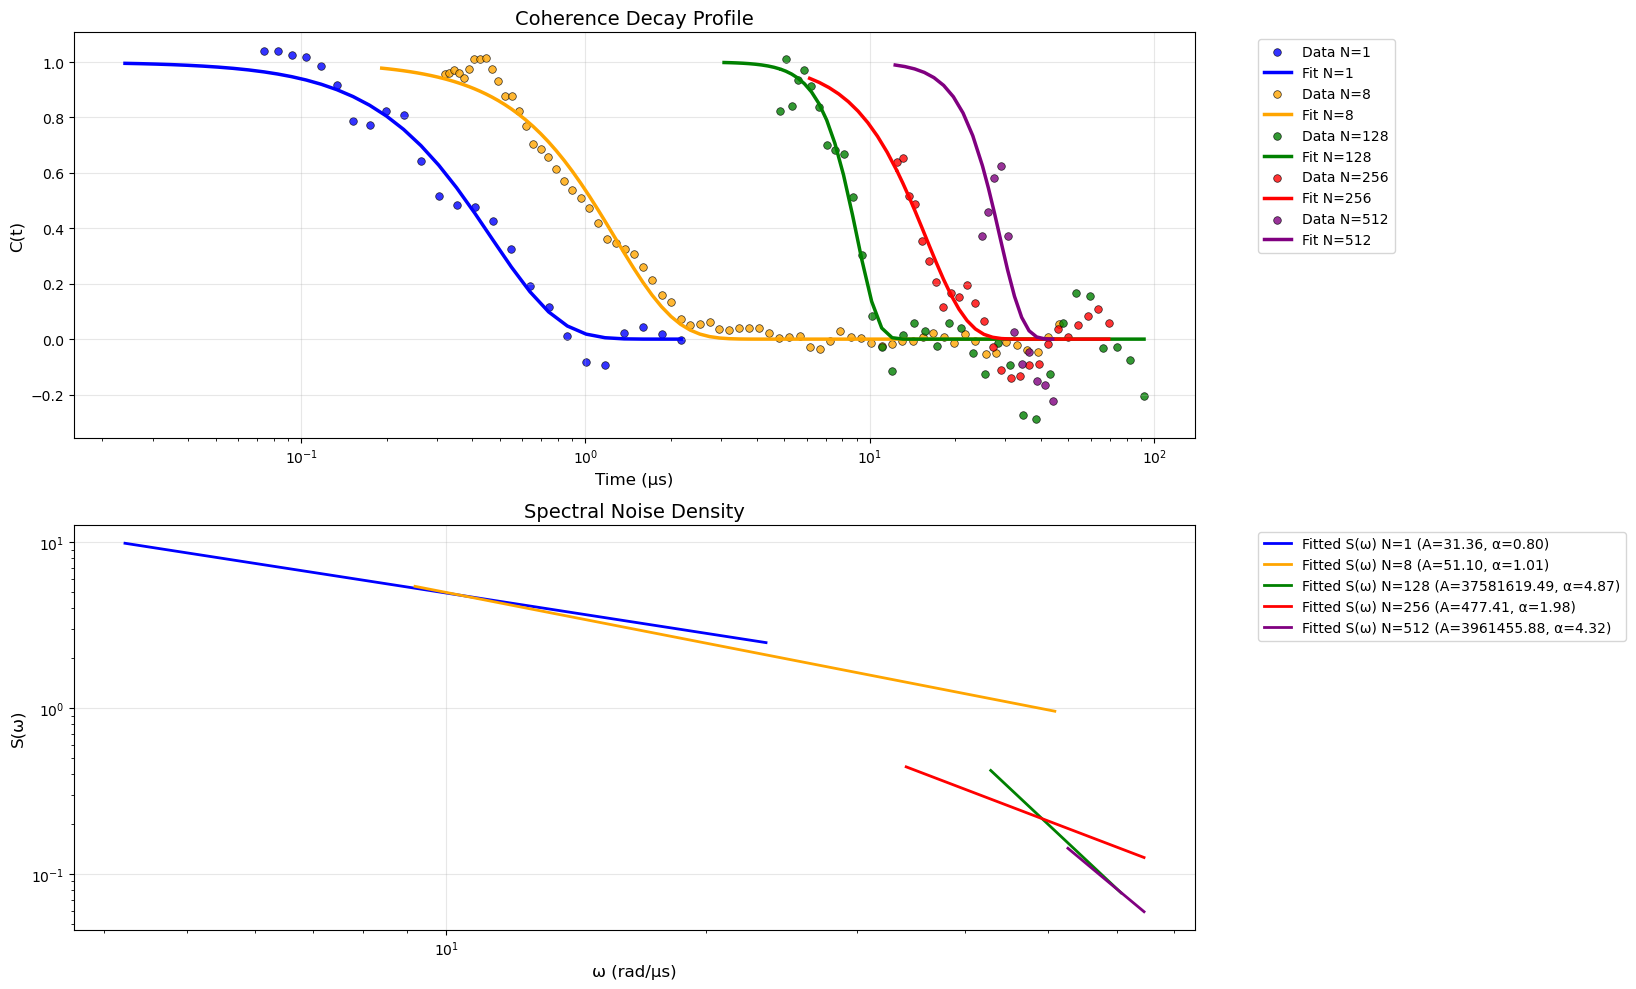

In [5]:
# Continue with plotting and saving logic for each n value
for n in n_values:
    print(f"\nProcessing plots for N={n}...")
    
    finite_width_params = fixed_kwargs_dict[n]
    t_points = times_dict[n]
    C_t_observed = C_t_observed_dict[n]

    # Generate the plotting data
    green_line = cp.noise_inversion_delta(t_points, C_t_observed)
    
    omega_values = n*np.pi/t_points
    omega_values = omega_values[(green_line != np.inf) & (green_line != -np.inf)]
    time_points = t_points[(green_line != np.inf) & (green_line != -np.inf)]
    green_line = green_line[(green_line != np.inf) & (green_line != -np.inf)]

    fitted_noise_spectrum = ns.noise_spectrum_combination(omega_values, *results_dict[n]["optimized_args"])
    S_w_synthetic = ns.noise_spectrum_combination(omega_values, *noise_params)
    
    C_t_plot = F*func_to_fit(t_points, ns.noise_spectrum_combination, *noise_params, delta=delta_approx, **finite_width_params)

    # PLOT 1: Noise Spectrum Comparison
    plt.figure(figsize=(10, 6))
    if not experimental_data and len(omega_values) > 0:
        plt.plot(omega_values, S_w_synthetic, label=f"Original Noise, ({format_parameters(noise_params)})", marker='o')

    if len(omega_values) > 0:
        plt.plot(omega_values, fitted_noise_spectrum, label=f"Fitted Noise ({format_parameters(results_dict[n]['optimized_args'])})", linestyle='--')
    else:
        pass

    # try:
    #     C_t1 = 0.95
    #     C_t2 = 0.05
    #     k = np.where((C_t_plot < C_t1) & (C_t_plot > C_t2))[0]

    #     w_1 = n*np.pi/np.max(t_points[k])
    #     w_2 = n*np.pi/np.min(t_points[k])

    #     # Add vertical red lines
    #     plt.axvline(w_1, color='red', linestyle='-', linewidth=2, label=f'{C_t1:.3f} > C(t) > {C_t2:.3f}')
    #     plt.axvline(w_2, color='red', linestyle='-', linewidth=2)
    # except Exception as e:
    #     print(f"Error in calculating vertical lines: {e}")

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('ω (rad/μs)')
    plt.ylabel('S(ω)')
    plt.legend()

    if not experimental_data:
        if delta_approx:
            title = f"Delta approx S(ω), n = {n} \n {format_parameters(noise_params)}"
        else:
            title = f"S(ω), n = {n} \n {format_parameters(noise_params)}"
    else:
        if delta_approx:
            title = f"Delta approx S(ω), n = {n}"
        else:
            title = f"S(ω), n = {n}"
    
    if combined_loss:
        title += " [Combined Loss]"
    
    plt.title(title)
    try:
        plt.savefig(save_dir + title + ".png", dpi="figure", bbox_inches="tight")
    except Exception as e:
        print(f"Error saving plot: {e}")
        print(save_dir)
        plt.savefig(save_dir + "S(ω)" + ".png", dpi="figure", bbox_inches="tight")
    # plt.show()
    plt.close()

    # PLOT 2: Coherence Decay Comparison
    plt.figure(figsize=(10, 6))
    if noise:
        plt.plot(t_points, results_dict[n]["C(t)_dirt"], label=f"Noisy C(t)", marker='o')
        plt.plot(t_points, results_dict[n]["C(t)_true"], label=f"Original C(t)", linestyle='--')
    else:
        try:
            if not experimental_data:
                plt.plot(t_points, C_t_plot, label=f"Original C(t)")
            fitted_C_t = func_to_fit(t_points, ns.noise_spectrum_combination, *results_dict[n]["optimized_args"], delta=delta_approx, **finite_width_params)
        except Exception as e:
            if not experimental_data:
                plt.plot(time_points, C_t_plot, label=f"Original C(t)")
            fitted_C_t = func_to_fit(time_points, ns.noise_spectrum_combination, *results_dict[n]["optimized_args"], delta=delta_approx, **finite_width_params)
    
    results_dict[n]["C(t)_fitted"] = fitted_C_t
    plt.plot(t_points, fitted_C_t, label=f"Fitted C(t) ({format_parameters(results_dict[n]['optimized_args'])})", linestyle='--')

    if delta_approx:
        plt.axvline(finite_width_params["N"]*finite_width_params["tau_p"], color='red', linestyle='-', linewidth=2, label=f't = N*τ_p = {finite_width_params["N"]*finite_width_params["tau_p"]:.3f} µs')
    
    plt.xscale('log')
    plt.xlabel('Time (µs)')
    plt.ylabel('C(t)')
    plt.legend()

    if not experimental_data:
        if delta_approx:
            title = f"Delta approx C(t), n = {n} \n {format_parameters(noise_params)}"
        else:
            title = f"C(t), n = {n} \n {format_parameters(noise_params)}"
    else:
        if delta_approx:
            title = f"Delta approx C(t), n = {n}"
        else:
            title = f"C(t), n = {n}"
    
    if combined_loss:
        title += " [Combined Loss]"
    
    plt.title(title)
    try:
        plt.savefig(save_dir + title + ".png", dpi="figure", bbox_inches="tight")
    except Exception as e:
        print(f"Error saving plot: {e}")
        # Fallback save if the title is too long or contains invalid characters
        plt.savefig(save_dir + "C(t)" + ".png", dpi="figure", bbox_inches="tight")
    # plt.show()
    plt.close()

    if not experimental_data:
        # PLOT 3: Chi(t) Analysis
        plt.figure(figsize=(10, 6))

        chi_t = -np.log(C_t_plot)
        chi_max = np.log(1/0.05)
        chi_min = np.log(1/0.95)

        try:
            if len(t_points[(chi_t != np.inf) & (chi_t >= 10**-2)]) > 0:
                plt.plot(t_points[(chi_t != np.inf) & (chi_t >= 10**-2)], chi_t[(chi_t != np.inf) & (chi_t >= 10**-2)], label=f"Original χ(t)")
        except Exception as e:
            plt.plot(time_points[(chi_t != np.inf) & (chi_t >= 10**-2)], chi_t[(chi_t != np.inf) & (chi_t >= 10**-2)], label=f"Original χ(t)")

        plt.axhline(y=chi_max, color='red', linestyle='--', label=f'{chi_max:.3f} > χ(t) > {chi_min:.3f}')
        plt.axhline(y=chi_min, color='red', linestyle='--')
        
        try:
            guideline_t = t_points[(chi_t != np.inf) & (chi_t >= 10**-2)]
            # guideline_t_alpha = guideline_t**(results_dict[n]['optimized_args'][0]['alpha'][0]+1)
            # plt.plot(t_points[(chi_t != np.inf) & (chi_t >= 10**-2)], guideline_t_alpha*(np.mean(chi_t)/np.mean(guideline_t_alpha)), label=r"$t^{\alpha+1}$ Guideline")
            if len(t_points[(chi_t != np.inf) & (chi_t >= 10**-2)]) > 0:
                plt.plot(t_points[(chi_t != np.inf) & (chi_t >= 10**-2)], guideline_t*(np.mean(chi_t)/np.mean(guideline_t)), label=r"$t$ Guideline")
        except Exception as e:
            guideline_t = time_points[(chi_t != np.inf) & (chi_t >= 10**-2)]
            # guideline_t_alpha = guideline_t**(results_dict[n]['optimized_args'][0]['alpha'][0]+1)
            # plt.plot(time_points[(chi_t != np.inf) & (chi_t >= 10**-2)], guideline_t_alpha*(np.mean(chi_t)/np.mean(guideline_t_alpha)), label=r"$t^{\alpha+1}$ Guideline")
            plt.plot(time_points[(chi_t != np.inf) & (chi_t >= 10**-2)], guideline_t*(np.mean(chi_t)/np.mean(guideline_t)), label=r"$t$ Guideline")
        
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Time (µs)")
        plt.ylabel("χ(t)")
        plt.legend()

        if not experimental_data:
            if delta_approx:
                title = f"Delta approx χ(t), n = {n} \n {format_parameters(noise_params)}"
            else:
                title = f"χ(t), n = {n} \n {format_parameters(noise_params)}"
        else:
            if delta_approx:
                title = f"Delta approx χ(t), n = {n}"
            else:
                title = f"χ(t), n = {n}"

        if combined_loss:
            title += " [Combined Loss]"

        plt.title(title)
        try:
            plt.savefig(save_dir + title + ".png", dpi="figure", bbox_inches="tight")
        except Exception as e:
            print(f"Error saving plot: {e}")
            # Fallback save if the title is too long or contains invalid characters
            plt.savefig(save_dir + "χ(t)" + ".png", dpi="figure", bbox_inches="tight")

        # plt.show()
        plt.close()

    # Save numpy arrays if noise was added
    if noise:
        if not experimental_data:
            np.save(save_dir + f"synthetic_C_t_dirty_n{n}.npy", results_dict[n]["C(t)_dirt"])
        else:
            np.save(save_dir + f"dirty_C_t_n{n}.npy", results_dict[n]["C(t)_dirt"])

# Save results
with open(save_dir + f"results.pkl", 'wb') as f:
    pickle.dump(results_dict, f)

print(f"\nResults saved to: {save_dir}")
if combined_loss:
    print("Combined loss optimization completed!")
else:
    print("Individual optimization completed!")

print("\n" + "="*50)
print("Creating Combined Analysis Plot")
print("="*50)

# Create the combined analysis plot using your existing variables
fig = create_combined_analysis_plot(
    results_dict=results_dict,
    n_values=n_values,
    combined_loss=combined_loss,
    save_dir=save_dir,
    experimental_data=experimental_data,
    noise_params=noise_params if not experimental_data else None,
    delta_approx=delta_approx,
    F=F,
    include_inversion = False)

# Fitting individualy learned $S(\omega)$ to single noise profile.

Below, we will use parameters found by individually fitting each $N$ case separately to a noise profile $S(\omega) = \frac{A}{\omega^\alpha}$ using the complete finite-width filter function. We then use these to create an average noise profile across $N$. Fitting a double power law to this yields our final estimate of the noise.

NOTE: This second half of the notebook should run independently of the first half. As, it uses the $1/f$ noise parameters enumerated in `FWFF_params` and `delta_params`. Replace these with noise parameters found from your noise if you'd like.

N = 1.0 C(t) std = 0.06138902539286488
13 25


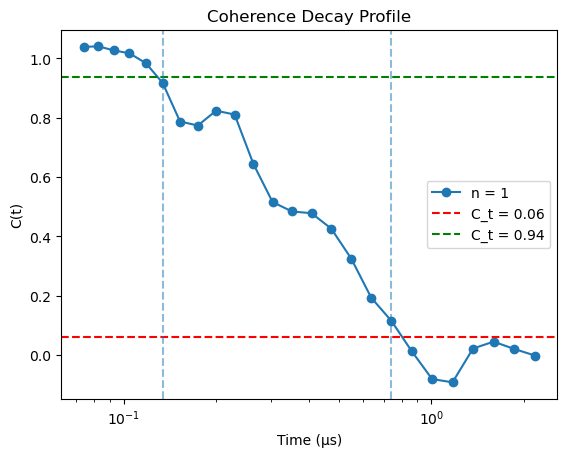

N = 8 C(t) std = 0.03925182944743504
26 70


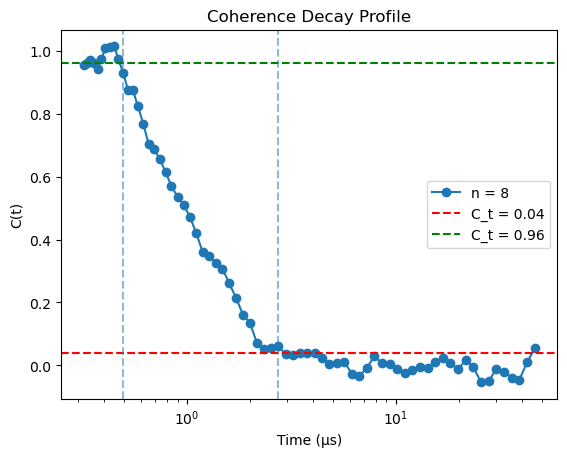

N = 128 C(t) std = 0.10197957240006385
6 35


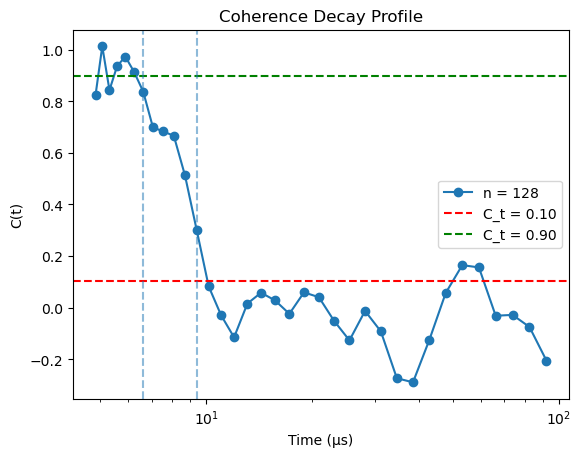

N = 256 C(t) std = 0.07537532562991836
12 26


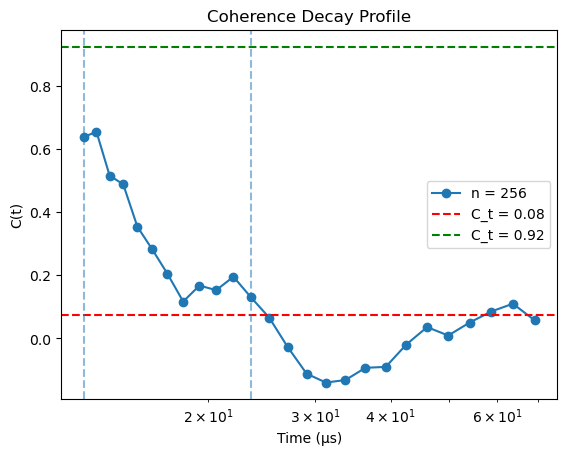

N = 512 C(t) std = 0.16274530391838227
5 11


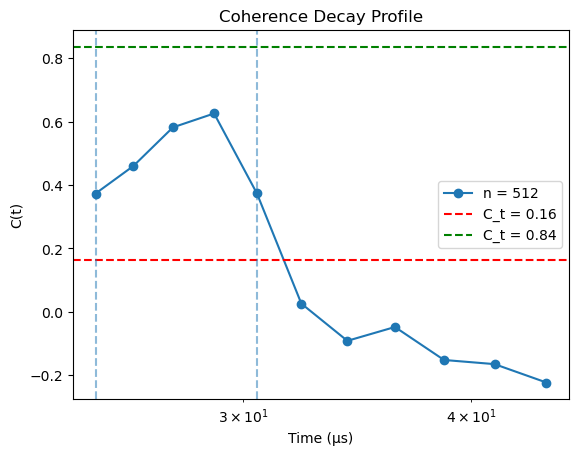

In [6]:
###### Check to see what time ranges we are using for the C(t) data. We want σ < C(t) < 1-σ, where σ is the standard deviation of the residual for the 1/f fit of the C(t) data.

# loads C(t) from data file, which is in the form of a dictionary with keys "N_pi", "time_points", and "C_t".
# with open("XY8data_forNoah.json","r") as file:
with open("data/example_XY8data_normtotpi1.json","r") as file:
    data = json.load(file)
# Re-format as a pandas dataframe for easier handling
del data["y_fit"]
df = pd.DataFrame(data)

##### 
# Hardcoded parameters for the FWFF and delta fits. These are found from the fits of the C(t) data to the power law function. (the /2 is due to a misplaced factor of 2 when I found these values.) 
# For now, these parameters will be used to find σ, so that we can show, σ < C(t) < 1-σ.
# #####

# For N in {1,8,128,256,512}, the parameters [A, alpha] for the 1/f noise spectrum S(ω) = A/ω^α. Replace these with values from your own fits.
# These parameters are found from the fits of the C(t) data to this power law function.
# NOTE: The /2 is due to a misplaced factor of 2 when I found these values.
FWFF_params = {1: [24.53/2,0.73],
    8: [16.18/2,0.69],
    128: [143334052.69/2,5.2],
    256: [31.41/2,1.24],
    512: [118392.921361/2,3.386887]}

delta_params = {1: [31.20/2,0.82],
                8: [39.84/2,0.93],
                128: [128948015.786386/2,5.2],
                256: [477.36/2,1.98],
                512: [3960547.026715/2, 4.323269]}


########################################################

for n in data["N_pi"]:
    FWFF_dict = {
    "N1f": 1, # Number of 1/f noise parameters
    "Nlor": 0, # Number of Lorentzian noise parameters
    "NC": 0, # Number of white noise parameters
    "Ndpl": 0, # Number of combined fraction noise parameters
    "N": int(n), #CPMG-N (test spin echo)
    "tau_p": 0.024, #pi pulse width in mircoseconds
    "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4), 10**8), # The number of peaks to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
    
    }

    n_df = df[df["N_pi"]==n]
    C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
    t_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds

    C_t_FWFF = func_to_fit(t_points, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict) # computes C(t) from 1/f noise spectrum for the Filter-Width Filter Function (FWFF)
    # C_t_delta = func_to_fit(t_points, noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)
    sig = np.std(C_t_observed-C_t_FWFF) # computes sigma from C(t) residual
    print("N =", n, "C(t) std =", sig)
    # time_points = time_points[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
    # C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]

    # If you would instead like to see where C(t) is within some other parameter, x (i.e. x < C(t) < 1-x), then just set sig = x.
    emem = find_widest_contiguous_stretch(C_t_observed, sig, 1-sig) # computes indicies of the widest contiguous stretch of C(t) data that is within the bounds of sig and 1-sig

    print(len(emem),len(t_points))

    plt.plot(t_points,C_t_observed,label=f"n = {int(n)}",marker='o')
    # plt.axvline(x=n*0.024,linestyle='--',label=f"t = n*tau_pi= {n*0.024} µs", alpha=0.5)
    plt.axhline(y=sig, color='r', linestyle='--', label=f'C_t = {sig:.2f}')
    plt.axhline(y=1-sig, color='g', linestyle='--', label=f'C_t = {1-sig:.2f}')
    plt.axvline(x=t_points[emem[0]],linestyle='--', alpha=0.5)
    plt.axvline(x=t_points[emem[-1]],linestyle='--', alpha=0.5)

    plt.title(f"Coherence Decay Profile")
    plt.xscale('log')
    plt.ylabel('C(t)')
    plt.xlabel('Time (µs)')
    plt.legend()
    plt.show()

# The vertical lines show the C(t) points (inclusive of the points on the lines) we will be using for every future computations
# The vertical lines show sig < C(t) < 1-sig, where sig is the standard deviation of the residuals of the C(t) data fit to the power law function.

# The hoirizontal lines show the bounds sig and 1-sig.

## Lets see how well the learned parameters fit $C_N(t)$ for each $N$.

N = 1 C(t) std = 0.06138902539286488
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03925182944743504
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10197957240006385
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07537532562991836
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.16274530391838227
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))


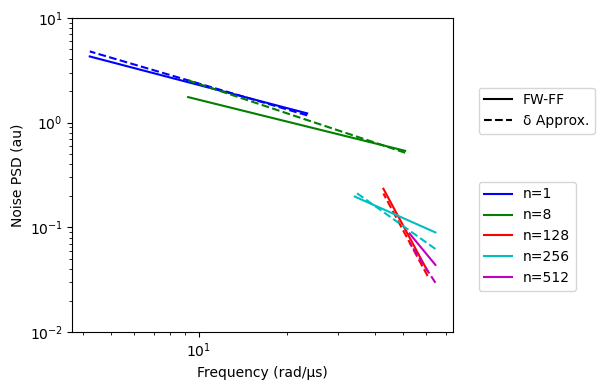

n=1
L2 Norm Difference between FWFF and δ Approx.: 0.7033985937093863
n=8
L2 Norm Difference between FWFF and δ Approx.: 0.9117981082456984
n=128
L2 Norm Difference between FWFF and δ Approx.: 0.5224045683706553
n=256
L2 Norm Difference between FWFF and δ Approx.: 0.8146975792558836
n=512
L2 Norm Difference between FWFF and δ Approx.: 0.6323681099662977


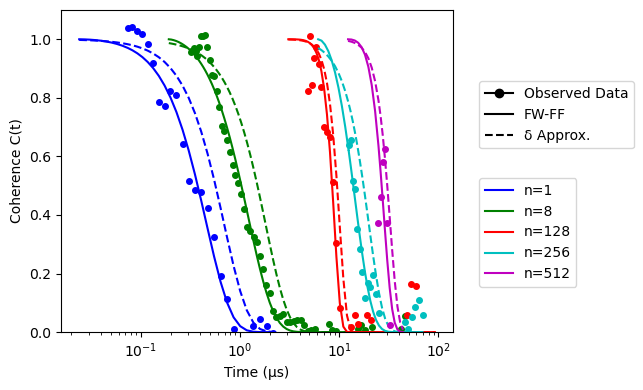

In [7]:
# Shows S(w) for each N, with the FWFF and delta fits overlaid. In the frequency range that corresponds to the above time range via freq_points = (n*np.pi/time_points)
# Also Shows the C(t) profiles that arise from these fits.

# N cases to plot
Ns = [1,8,128,256,512]
tau_p = 0.024 # pi pulse width in microseconds

########################################################

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

with open("data/example_XY8data_normtotpi1.json","r") as file:
    data = json.load(file)

del data["y_fit"]
df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))

combined_S_w = []
combined_frequencies = []

for idx, n in enumerate(Ns):
    FWFF_dict = {
    "N1f": 1, # Number of 1/f noise parameters
    "Nlor": 0, # Number of Lorentzian noise parameters
    "NC": 0, # Number of white noise parameters
    "Ndpl": 0, # Number of combined fraction noise parameters
    "N": n, #CPMG-N (test spin echo)
    "tau_p": tau_p, #pi pulse width in mircoseconds
    "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4), 10**8), # The number of peaks to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
    
    }
    n_df = df[df["N_pi"]==n]
    time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds
    C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
    C_t_FWFF = func_to_fit(time_points, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict)
    C_t_delta = func_to_fit(time_points, ns.noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)
    # sig = np.std(C_t_observed-C_t_delta)
    sig = np.std(C_t_observed-C_t_FWFF) # computes sigma from C(t) residual
    print("N =", n, "C(t) std =", sig)
    time_points = time_points[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)] # restricts time_points to the widest contiguous stretch of C(t) data that is within the bounds of sig and 1-sig
    C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)] # restricts C_t_observed to the same time_points
    # time_points = (1e-3)*np.array(df['time_points'][idx])
    # time_points = np.logspace(np.log10(0.1), np.log10(100), 100)
    
    freq_points = (n*np.pi/time_points)
    print("freq_points", (np.min(freq_points), np.max(freq_points)))
    noise_ff = ns.noise_spectrum_1f(freq_points, *FWFF_params[n])
    noise_delta = ns.noise_spectrum_1f(freq_points, *delta_params[n])
    plt.plot(freq_points, noise_ff,'-', color=colors[idx], label=f'n={n}')
    plt.plot(freq_points, noise_delta,'--', color=colors[idx])

    # combined_S_w.append(noise_ff)
    combined_S_w.append(noise_delta)
    combined_frequencies.append(freq_points)

plt.xscale('log')  
plt.yscale('log')  
plt.xlabel('Frequency (rad/μs)')
plt.ylabel('Noise PSD (au)')
plt.ylim(1e-2, 1e1)

# First legend for line styles (in black)
line_legend_elements = [plt.Line2D([0], [0], color='black', linestyle='-', label='FW-FF'),
                       plt.Line2D([0], [0], color='black', linestyle='--', label='δ Approx.')]
line_legend = plt.legend(handles=line_legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Second legend for colors/n values
color_legend = plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')

# Add the first legend back (matplotlib removes it when creating the second)
plt.gca().add_artist(line_legend)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
for idx, n in enumerate(Ns):
    FWFF_dict = {
        "N1f": 1,
        "Nlor": 0,
        "NC": 0,
        "Ndpl": 0,
        "N": n,
        "tau_p": tau_p,
        "integration_method": "trapezoid",
        "omega_resolution": int(10**5),
        "omega_range" : (10**(-4), 10**8),
        "num_peaks_cutoff": 100,
        "peak_resolution": 100,
    }
    
    n_df = df[df["N_pi"]==n]
    time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds
    time_points_special = np.concatenate((np.logspace(np.log10(n*FWFF_dict["tau_p"]+1e-10),np.log10(time_points[0]),10),time_points))
    C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
    C_t_FWFF = func_to_fit(time_points_special, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict)
    C_t_delta = func_to_fit(time_points_special, ns.noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)

    print(f"n={n}")
    print("L2 Norm Difference between FWFF and δ Approx.:", np.linalg.norm(C_t_FWFF - C_t_delta))

    plt.plot(time_points, C_t_observed, 'o', color=colors[idx], markersize=4)
    plt.plot(time_points_special, C_t_FWFF, '-', color=colors[idx],label=f'n={n}')
    plt.plot(time_points_special, C_t_delta, '--', color=colors[idx])

plt.xscale('log')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence C(t)')
plt.ylim([0, 1.1])
# First legend for line styles (in black)
line_legend_elements = [plt.Line2D([0], [0], color='black', marker='o', label='Observed Data'),
                        plt.Line2D([0], [0], color='black', linestyle='-', label='FW-FF'),
                       plt.Line2D([0], [0], color='black', linestyle='--', label='δ Approx.')]
line_legend = plt.legend(handles=line_legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Second legend for colors/n values
color_legend = plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left')

# Add the first legend back (matplotlib removes it when creating the second)
plt.gca().add_artist(line_legend)

plt.tight_layout()
plt.show()

# Averaging Noise spectra with bootstrapping

In [8]:
# For the paper we bootstrapped the fitting of the experimental C(t) data using the full finite-width filter function by generating multiple synthetic datasets
# using the fit of the experimental C(t) data and it's sigma. We will use these bootstrapped parameters to reproduce the error bars shown in the paper.
# NOTE: in this tutorial notebook, delta_approx=True, which doesn't align with these paramters. If you set delta_approx=False, you should see parameter values closer to these.
# We will still use these parameters thoughm just to reproduce the exercise.
# NOTE: The /2 is due to a misplaced factor of 2 when I generated these values.
# Here are the bootstrapped parameters we obtained from fitting these synthetic datasets. These can be used to reproduce the error bars shown in the paper.
bootstrap_data = {
    1: {
        "run_1": {"A": 18.12/2, "alpha": 0.56},
        "run_2": {"A": 59.07/2, "alpha": 1.12},
        "run_3": {"A": 13.03/2, "alpha": 0.47},
        "run_4": {"A": 24.56/2, "alpha": 0.76},
        "run_5": {"A": 18.12/2, "alpha": 0.56},
        "run_6": {"A": 21.28/2, "alpha": 0.7},
        "run_7": {"A": 21.28/2, "alpha": 0.63},
        "run_8": {"A": 19.02/2, "alpha": 0.62},
        "run_9": {"A": 31.68/2, "alpha": 0.85},
        "run_10": {"A": 23.9/2, "alpha": 0.69},
        "run_11": {"A": 16.08/2, "alpha": 0.55},
        "run_12": {"A": 35.69/2, "alpha": 0.83},
        "run_13": {"A": 33.09/2, "alpha": 0.84},
        "run_14": {"A": 25.72/2, "alpha": 0.76},
        "run_15": {"A": 15.8/2, "alpha": 0.55},
        "run_16": {"A": 23.75/2, "alpha": 0.71}
    },
    8: {
        "run_1": {"A": 18.6/2, "alpha": 0.73},
        "run_2": {"A": 16.52/2, "alpha": 0.69},
        "run_3": {"A": 9.89/2, "alpha": 0.53},
        "run_4": {"A": 18.18/2, "alpha": 0.72},
        "run_5": {"A": 18.2/2, "alpha": 0.74},
        "run_6": {"A": 14.64/2, "alpha": 0.66},
        "run_7": {"A": 17.81/2, "alpha": 0.73},
        "run_8": {"A": 16.63/2, "alpha": 0.71},
        "run_9": {"A": 19.31/2, "alpha": 0.74},
        "run_10": {"A": 14.59/2, "alpha": 0.67},
        "run_11": {"A": 11.92/2, "alpha": 0.6},
        "run_12": {"A": 14.92/2, "alpha": 0.65},
        "run_13": {"A": 13.64/2, "alpha": 0.62}
    },
    128: {
        "run_1": {"A": 78485.38/2, "alpha": 3.23},
        "run_2": {"A": 136395692.19/2, "alpha": 5.76},
        "run_3": {"A": 37994182/2, "alpha": 4.86},
        "run_4": {"A": 3262100.94/2, "alpha": 4.25},
        "run_5": {"A": 2215724579121.38/2, "alpha": 7.69},
        "run_6": {"A": 685256879/2, "alpha": 5.63},
        "run_7": {"A": 3136009338077.56/2, "alpha": 7.81},
        "run_8": {"A": 2706990298.25/2, "alpha": 5.97},
        "run_9": {"A": 83289204.12/2, "alpha": 5.09},
        "run_10": {"A": 191893642.06/2, "alpha": 5.29},
        "run_11": {"A": 4688983.12/2, "alpha": 4.37},
        "run_12": {"A": 19920629/2, "alpha": 4.68},
        "run_13": {"A": 183432807.275245/2, "alpha": 5.25612},
        "run_14": {"A": 35228017.98/2, "alpha": 4.9},
        "run_15": {"A": 975297501.32/2, "alpha": 5.68},
        "run_16": {"A": 312584290.33/2, "alpha": 5.44},
        "run_17": {"A": 145509499.36/2, "alpha": 5.29},
        "run_18": {"A": 589912030.71/2, "alpha": 5.57},
        "run_19": {"A": 18081379.67/2, "alpha": 4.67}
    },
    256: {
        "run_1": {"A": 4.38/2, "alpha": 0.76},
        "run_2": {"A": 13.62/2, "alpha": 1.02},
        "run_3": {"A": 102.87/2, "alpha": 1.55},
        "run_4": {"A": 74.44/2, "alpha": 1.44},
        "run_5": {"A": 8/2, "alpha": 0.89},
        "run_6": {"A": 6.71/2, "alpha": 0.87},
        "run_7": {"A": 16.79/2, "alpha": 1.09},
        "run_8": {"A": 400.77/2, "alpha": 1.91},
        "run_9": {"A": 11.46/2, "alpha": 0.99},
        "run_10": {"A": 119.53/2, "alpha": 1.56},
        "run_11": {"A": 657.12/2, "alpha": 2.01},
        "run_12": {"A": 19.67/2, "alpha": 1.14},
        "run_13": {"A": 7/2, "alpha": 0.86},
        "run_14": {"A": 244.81/2, "alpha": 1.8},
        "run_15": {"A": 26.85/2, "alpha": 1.2}
    },
    512: {
        "run_1": {"A": 2733953534820.44/2, "alpha": 7.47},
        "run_2": {"A": 5985503.94/2, "alpha": 4.34},
        "run_3": {"A": 3460829.88/2, "alpha": 4.25},
        "run_4": {"A": 83426.8125/2, "alpha": 3.310335},
        "run_5": {"A": 79593449.79/2, "alpha": 4.95},
        "run_6": {"A": 461067263.75/2, "alpha": 5.37},
        "run_7": {"A": 4.65/2, "alpha": 0.89},
        "run_8": {"A": 317253.43/2, "alpha": 3.58},
        "run_9": {"A": 8776210780.2/2, "alpha": 6.18},
        "run_10": {"A": 1396.03/2, "alpha": 2.26},
        "run_11": {"A": 1360839.44/2, "alpha": 4.02},
        "run_12": {"A": 1567.34/2, "alpha": 2.32},
        "run_13": {"A": 242839.72/2, "alpha": 3.52},
        "run_14": {"A": 390961.48/2, "alpha": 3.76}
    }
}

In [9]:
# Example usage:
print(f"Total possible unique combinations: {calculate_total_combinations(bootstrap_data)}")

# Generate multiple bootstrap samples
num_bootstrap = 3  # You can change this number
print(f"\nGenerating {num_bootstrap} unique bootstrap samples:")

bootstrap_samples = bootstrap_multiple_samples(bootstrap_data, num_bootstrap)

# # Display all samples
# for i, sample in enumerate(bootstrap_samples):
#     print(f"\nBootstrap sample {i+1}:")
#     print(f"FWFF_params = {sample}")

Total possible unique combinations: 829920

Generating 3 unique bootstrap samples:


  0%|          | 0/3 [00:00<?, ?it/s]

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03933413133776565
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10025663205669995
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.08058875225703825
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17338470991933488
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

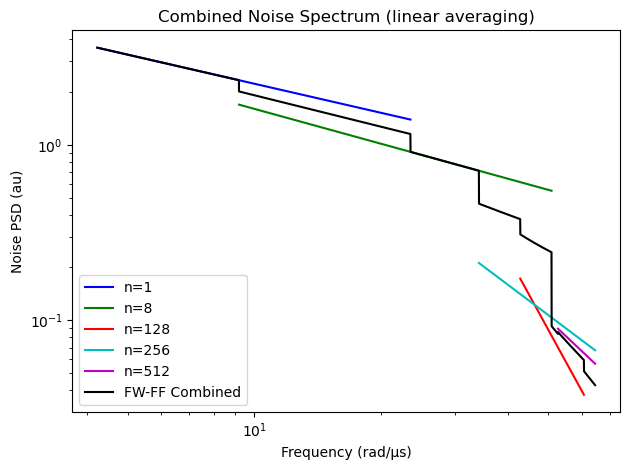

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03933413133776565
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10025663205669995
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.08058875225703825
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17338470991933488
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

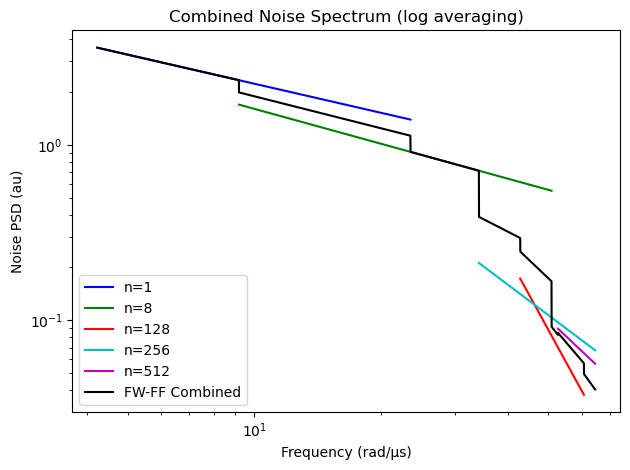

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03921760302214327
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10050444191348926
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07715035173878139
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.22947686131540923
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

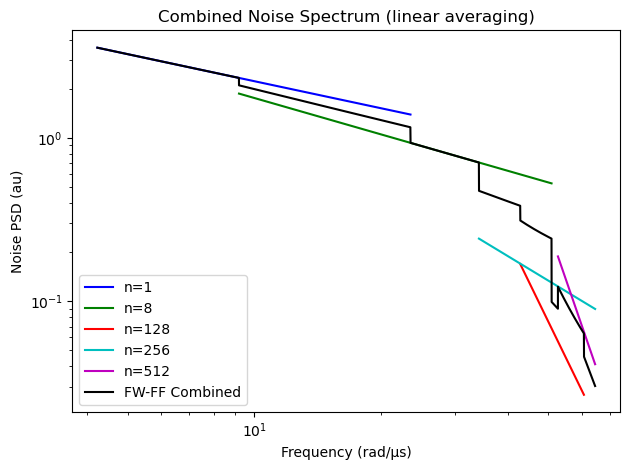

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03921760302214327
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10050444191348926
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07715035173878139
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.22947686131540923
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

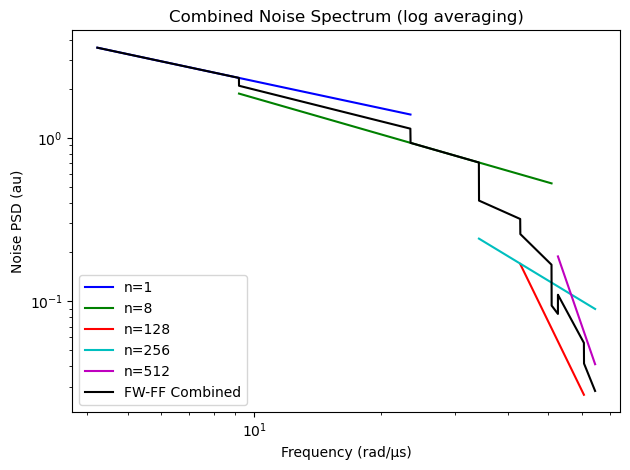

N = 1 C(t) std = 0.06175487114766966
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.039088696948713586
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.0999696718815984
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07536401888654942
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17421195458084981
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

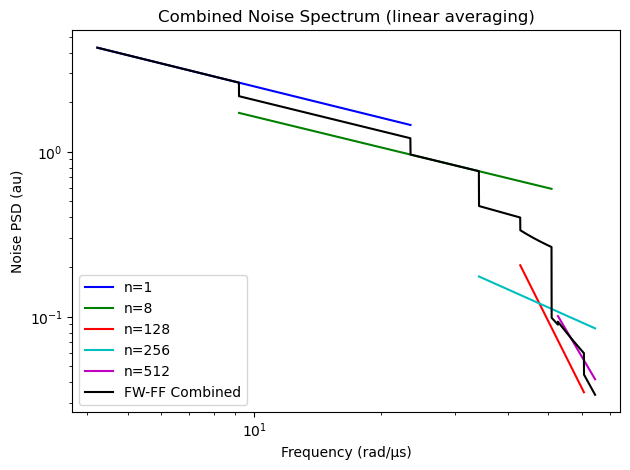

N = 1 C(t) std = 0.06175487114766966
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.039088696948713586
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.0999696718815984
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07536401888654942
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17421195458084981
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))
[[ 4.23512649 23.50650136]
 [ 9.19611864 50.87649162]
 [34.19128628 60.7425569 ]
 [42.86315745 64.57967449]
 [52.68881081 64.57967449]]
Interval Analysis:
Interval 0 only: [4.235, 9.196]
Intervals 0 & 1 overlap: [9.196, 23.507]
Interval 1 only: [23.507, 34.191]
Intervals 1 & 2 overlap: [34.191, 42.863]
Intervals 1 & 2 & 3 overlap: [42.863, 50.876]
Intervals 2 & 3 overlap: [50.876, 52.689]
Intervals 2 & 3 & 4 overlap: [52.689, 60.74

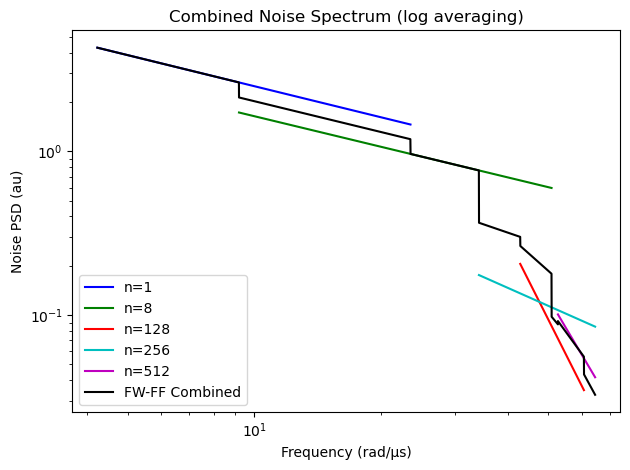

In [10]:
##### Averages the 1/f S(w) spectra for each N case, and plots the combined spectrum. #####
### Total execution time for this cell on my laptop: 30s ###

combined_noise_dict = {}

for i, FWFF_params in tenumerate(bootstrap_samples):

    combined_noise_dict[i] = {}

    # Choose averaging stragey to use to combin 1/f noise spectra for each N case
    # log averaging is the same as geometric averaging
    for average in ["linear","log"]: 

        # N cases to plot
        Ns = [1,8,128,256,512]
        tau_p = 0.024
        ########################################################


        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

        freq_endpoints = []

        for idx, n in enumerate(Ns):
            FWFF_dict = {
            "N1f": 1, # Number of 1/f noise parameters
            "Nlor": 0, # Number of Lorentzian noise parameters
            "NC": 0, # Number of white noise parameters
            "Ndpl": 0, # Number of combined fraction noise parameters
            "N": n, #CPMG-N (test spin echo)
            "tau_p": tau_p, #pi pulse width in mircoseconds
            "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
            "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
            "omega_range" : (10**(-4), 10**8), # The number of peaks to use in the filter function
            "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
            "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
            # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
            # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
            # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
            
            }
            n_df = df[df["N_pi"]==n]
            time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds
            C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
            C_t_FWFF = func_to_fit(time_points, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict)
            C_t_delta = func_to_fit(time_points, ns.noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)
            sig = np.std(C_t_observed-C_t_FWFF) # computes sigma from C(t) residual
            # sig = np.std(C_t_observed-C_t_delta)
            print("N =", n, "C(t) std =", sig)
            time_points = time_points[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
            C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
            # time_points = (1e-3)*np.array(df['time_points'][idx])
            # time_points = np.logspace(np.log10(0.1), np.log10(100), 100)
            
            freq_points = (n*np.pi/time_points)
            noise_ff = ns.noise_spectrum_1f(freq_points, *FWFF_params[n])
            noise_delta = ns.noise_spectrum_1f(freq_points, *delta_params[n])
            plt.plot(freq_points, noise_ff,'-', color=colors[idx], label=f'n={n}')
            # plt.plot(freq_points, noise_delta,'--', color=colors[idx])

            print("freq_points", (np.min(freq_points), np.max(freq_points)))
            freq_endpoints.append((np.min(freq_points), np.max(freq_points)))

        # plt.yscale('log')
        # plt.xscale('log')
        # plt.legend()
        # plt.show()


        ###### Combine intervals #####

        intervals = np.sort(np.array(freq_endpoints), axis=0)
        print(intervals)
        me = analyze_intervals(intervals)

        print(f"\nCombining intervals with {average} averaging")
        S_w_combined_ff = np.array([])
        S_w_combined_delta = np.array([])
        freq_points_combined = np.array([])

        for start, end, containing_intervals in me:
            freq_points = np.linspace(start, end, num=1000)
            # freq_points = np.logspace(np.log10(start), np.log10(end), num=1000)
            freq_points = freq_points[:-1] # Exclude the last point to avoid overlap with next interval
            freq_points_combined = np.concatenate((freq_points_combined, freq_points))

            if len(containing_intervals) >= 1:
                # Get the sorted n values for all containing intervals
                sorted_Ns = [Ns[i] for i in sorted(range(len(Ns)), key=lambda i: freq_endpoints[i][0])]
                n_values = [sorted_Ns[i] for i in containing_intervals]

                if len(containing_intervals) == 1:
                    n = n_values[0]
                    noise_ff = ns.noise_spectrum_1f(freq_points, *FWFF_params[n])
                    noise_delta = ns.noise_spectrum_1f(freq_points, *delta_params[n])
                else:
                    # Handle multiple intervals (2 or more)
                    print(f"Combining intervals for n={n_values}")
                    
                    # Calculate noise for all intervals
                    noise_ff_list = [ns.noise_spectrum_1f(freq_points, *FWFF_params[n]) for n in n_values]
                    noise_delta_list = [ns.noise_spectrum_1f(freq_points, *delta_params[n]) for n in n_values]

                    if average == "linear":
                        # Linear average of all noise spectra
                        noise_ff = np.mean(noise_ff_list, axis=0)
                        noise_delta = np.mean(noise_delta_list, axis=0)
                    elif average == "log":
                        # Logarithmic average (geometric mean) of all noise spectra
                        # Convert to log, average, then convert back
                        log_noise_ff = np.mean([np.log10(noise) for noise in noise_ff_list], axis=0)
                        noise_ff = 10**log_noise_ff
                        
                        log_noise_delta = np.mean([np.log10(noise) for noise in noise_delta_list], axis=0)
                        noise_delta = 10**log_noise_delta
                        
                        # Alternative geometric mean calculation:
                        # noise_ff = np.exp(np.mean([np.log(noise) for noise in noise_ff_list], axis=0))
                        # noise_delta = np.exp(np.mean([np.log(noise) for noise in noise_delta_list], axis=0))
                
                S_w_combined_ff = np.concatenate((S_w_combined_ff, noise_ff))
                S_w_combined_delta = np.concatenate((S_w_combined_delta, noise_delta))


        plt.plot(freq_points_combined, S_w_combined_ff, '-', color='black', label='FW-FF Combined')
        # plt.plot(freq_points_combined, S_w_combined_delta, '--', color='black', label='δ Approx. Combined')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Frequency (rad/μs)')
        plt.ylabel('Noise PSD (au)')
        # plt.ylim(1e-1, 1e1)
        plt.legend()
        plt.title(f"Combined Noise Spectrum ({average} averaging)")
        plt.tight_layout()
        plt.show()


        combined_noise_dict[i][average] = {
            "freq_points": freq_points_combined,
            "S_w_combined_ff": S_w_combined_ff,
            "S_w_combined_delta": S_w_combined_delta,
            "C_t_FWFF": {}
        }

In [11]:
# for i, FWFF_params in enumerate(bootstrap_samples):
#     try:
#         print(np.all(combined_noise_dict[i]["linear"]["S_w_combined_ff"] ==  combined_noise_dict[i+1]["linear"]["S_w_combined_ff"])) # Example to access the combined frequencies for the first bootstrap sample
#     except KeyError:
#         print(np.all(combined_noise_dict[i]["linear"]["S_w_combined_ff"] ==  combined_noise_dict[i-1]["linear"]["S_w_combined_ff"]))

  0%|          | 0/3 [00:00<?, ?it/s]

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03933413133776565
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10025663205669995
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.08058875225703825
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17338470991933488
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.07861805161182142
differential_evolution step 2: f(x)= 0.06861233967621806
differential_evolution step 3: f(x)= 0.06861233967621806
differential_evolution step 4: f(x)= 0.05665258003656599
differential_evolution step 5: f(x)= 0.030944151600819834
differential_evolution step 6: f(x)= 0.030944151600819834
differential_evolution 

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.394839, alpha=0.686063, beta > alpha: True
Optimization successful: True
Final loss: 0.003918830836443548
Optimized parameters:
Double power law params: {'A': [10.011960291015734], 'alpha': [0.6860632083291919], 'beta': [5.394839102220059], 'gamma': [39.04708283683027]}

Mean Squared Error: 3.918831e-03
R-squared: 0.995369

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.04407909731463052
differential_evolution step 2: f(x)= 0.01599791597513053
differential_evolution step 3: f(x)= 0.01599791597513053
differential_evolution step 4: f(x)= 0.01599791597513053
differential_evolution step 5: f(x)= 0.01599791597513053
differential_evolution step 6: f(x)= 0.01599791597513053
differential_evolution step 7: f(x)= 0.01599791597513053
differential_evolution step 8: f(x)= 0.012476702959917608
differential_evolution step 9: f(x)= 0.011166126533495201
differential_evolution step 10: f(x)= 0.01

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=6.221375, alpha=0.719213, beta > alpha: True
Optimization successful: True
Final loss: 0.006990495489856871
Optimized parameters:
Double power law params: {'A': [10.673089792667735], 'alpha': [0.7192134319092993], 'beta': [6.221375089532846], 'gamma': [40.08295200660863]}

Mean Squared Error: 4.181866e-03
R-squared: 0.995058

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.1598656692111393
differential_evolution step 2: f(x)= 0.10560296356950767
differential_evolution step 3: f(x)= 0.10560296356950767
differential_evolution step 4: f(x)= 0.08422555561915485
differential_evolution step 5: f(x)= 0.08422555561915485
differential_evolution step 6: f(x)= 0.08422555561915485
differential_evolution step 7: f(x)= 0.08422555561915485
differential_evolution step 8: f(x)= 0.060242881518353934
differential_evolution step 9: f(x)= 0.060242881518353934
differential_evolution step 10: f(x)= 0.060

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.752282, alpha=0.674536, beta > alpha: True
Optimization successful: True
Final loss: 0.0328194303717764
Optimized parameters:
Double power law params: {'A': [9.721818851928948], 'alpha': [0.6745357024237412], 'beta': [5.7522820085768895], 'gamma': [37.59801524909199]}

Mean Squared Error: 4.503009e-03
R-squared: 0.994678

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.055935980304318574
differential_evolution step 2: f(x)= 0.055935980304318574
differential_evolution step 3: f(x)= 0.055935980304318574
differential_evolution step 4: f(x)= 0.04927321287894744
differential_evolution step 5: f(x)= 0.04927321287894744
differential_evolution step 6: f(x)= 0.01647831709066348
differential_evolution step 7: f(x)= 0.01647831709066348
differential_evolution step 8: f(x)= 0.01647831709066348
differential_evolution step 9: f(x)= 0.01647831709066348
differential_evolution step 10: f(x)= 0.0164783

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.630859, alpha=0.691408, beta > alpha: True
Optimization successful: True
Final loss: 0.0038827495918987796
Optimized parameters:
Double power law params: {'A': [10.095810510647015], 'alpha': [0.6914081063375034], 'beta': [5.630859414688842], 'gamma': [37.33003019680604]}

Mean Squared Error: 3.882750e-03
R-squared: 0.995476

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.03540110097492654
differential_evolution step 2: f(x)= 0.027198598732164795
differential_evolution step 3: f(x)= 0.027198598732164795
differential_evolution step 4: f(x)= 0.02265844960196698
differential_evolution step 5: f(x)= 0.010533808573183442
differential_evolution step 6: f(x)= 0.010533808573183442
differential_evolution step 7: f(x)= 0.00985940012663794
differential_evolution step 8: f(x)= 0.00985940012663794
differential_evolution step 9: f(x)= 0.008464055424422953
differential_evolution step 10: f(x)= 

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.375272, alpha=0.666349, beta > alpha: True
Optimization successful: True
Final loss: 0.0034307944731224852
Optimized parameters:
Double power law params: {'A': [9.592049012589207], 'alpha': [0.6663490647172599], 'beta': [5.375271893083665], 'gamma': [36.18316763824635]}

Mean Squared Error: 4.016803e-03
R-squared: 0.995320

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.18265099318255648
differential_evolution step 2: f(x)= 0.14441095783464028
differential_evolution step 3: f(x)= 0.1433609783760465
differential_evolution step 4: f(x)= 0.09780524609556211
differential_evolution step 5: f(x)= 0.09780524609556211
differential_evolution step 6: f(x)= 0.09780524609556211
differential_evolution step 7: f(x)= 0.09780524609556211
differential_evolution step 8: f(x)= 0.09780524609556211
differential_evolution step 9: f(x)= 0.062317880899650555
differential_evolution step 10: f(x)= 0.0623

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.195503, alpha=0.652720, beta > alpha: True
Optimization successful: True
Final loss: 0.017407791985485654
Optimized parameters:
Double power law params: {'A': [9.315941858622297], 'alpha': [0.6527195859200153], 'beta': [5.195502546448505], 'gamma': [35.12767435273692]}

Mean Squared Error: 4.381809e-03
R-squared: 0.994894


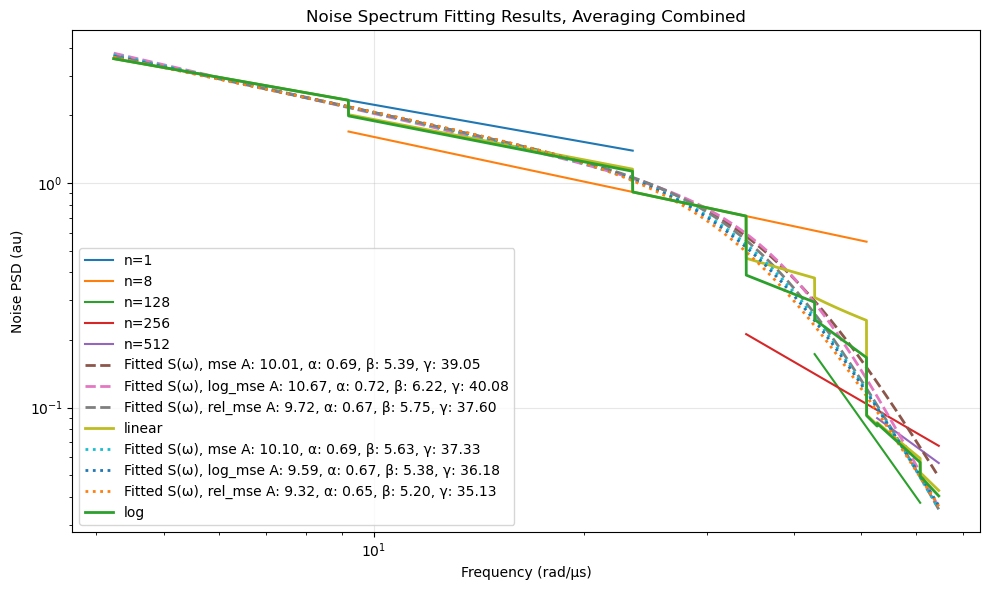

N = 1 C(t) std = 0.06440560126161297
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.03921760302214327
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.10050444191348926
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07715035173878139
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.22947686131540923
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.05203060145107751
differential_evolution step 2: f(x)= 0.05203060145107751
differential_evolution step 3: f(x)= 0.05203060145107751
differential_evolution step 4: f(x)= 0.021788003525906006
differential_evolution step 5: f(x)= 0.021788003525906006
differential_evolution step 6: f(x)= 0.021788003525906006
differential_evolution

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.143300, alpha=0.661359, beta > alpha: True
Optimization successful: True
Final loss: 0.0030702648575632106
Optimized parameters:
Double power law params: {'A': [9.598653960734971], 'alpha': [0.6613593300953038], 'beta': [5.143300488618655], 'gamma': [38.34973862236316]}

Mean Squared Error: 3.070265e-03
R-squared: 0.996395

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.02320919898147822
differential_evolution step 2: f(x)= 0.02320919898147822
differential_evolution step 3: f(x)= 0.02320919898147822
differential_evolution step 4: f(x)= 0.021471444554590442
differential_evolution step 5: f(x)= 0.012439224555561328
differential_evolution step 6: f(x)= 0.012439224555561328
differential_evolution step 7: f(x)= 0.009249184051430496
differential_evolution step 8: f(x)= 0.009249184051430496
differential_evolution step 9: f(x)= 0.009249184051430496
differential_evolution step 10: f(x)= 

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=7.106981, alpha=0.782191, beta > alpha: True
Optimization successful: True
Final loss: 0.005643330974803237
Optimized parameters:
Double power law params: {'A': [12.291078381601379], 'alpha': [0.7821910684482347], 'beta': [7.1069812224574385], 'gamma': [42.69106457901044]}

Mean Squared Error: 5.845477e-03
R-squared: 0.993136

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.19584594128984206
differential_evolution step 2: f(x)= 0.19584594128984206
differential_evolution step 3: f(x)= 0.15112537256340441
differential_evolution step 4: f(x)= 0.15112537256340441
differential_evolution step 5: f(x)= 0.15112537256340441
differential_evolution step 6: f(x)= 0.15112537256340441
differential_evolution step 7: f(x)= 0.10832241108041264
differential_evolution step 8: f(x)= 0.10832241108041264
differential_evolution step 9: f(x)= 0.059341104445329015
differential_evolution step 10: f(x)= 0.05

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=6.618106, alpha=0.747326, beta > alpha: True
Optimization successful: True
Final loss: 0.027378806431756574
Optimized parameters:
Double power law params: {'A': [11.386819820956516], 'alpha': [0.7473260620024837], 'beta': [6.618106356713585], 'gamma': [40.73127804936673]}

Mean Squared Error: 4.498078e-03
R-squared: 0.994718

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.055833525058490235
differential_evolution step 2: f(x)= 0.055833525058490235
differential_evolution step 3: f(x)= 0.055833525058490235
differential_evolution step 4: f(x)= 0.055833525058490235
differential_evolution step 5: f(x)= 0.055833525058490235
differential_evolution step 6: f(x)= 0.024786836344017085
differential_evolution step 7: f(x)= 0.00904767286401391
differential_evolution step 8: f(x)= 0.00904767286401391
differential_evolution step 9: f(x)= 0.00904767286401391
differential_evolution step 10: f(x)= 0.00

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.422608, alpha=0.666671, beta > alpha: True
Optimization successful: True
Final loss: 0.0028283543336881326
Optimized parameters:
Double power law params: {'A': [9.682424930115614], 'alpha': [0.6666708748628727], 'beta': [5.422608255958661], 'gamma': [36.95355366821369]}

Mean Squared Error: 2.828354e-03
R-squared: 0.996731

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.04513454393501143
differential_evolution step 2: f(x)= 0.04513454393501143
differential_evolution step 3: f(x)= 0.019438566589767878
differential_evolution step 4: f(x)= 0.018371158728392074
differential_evolution step 5: f(x)= 0.012291557947606575
differential_evolution step 6: f(x)= 0.012291557947606575
differential_evolution step 7: f(x)= 0.011537689302668203
differential_evolution step 8: f(x)= 0.011537689302668203
differential_evolution step 9: f(x)= 0.011537689302668203
differential_evolution step 10: f(x)=

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=6.293091, alpha=0.743206, beta > alpha: True
Optimization successful: True
Final loss: 0.0034804762751088733
Optimized parameters:
Double power law params: {'A': [11.32017846399289], 'alpha': [0.7432064564265711], 'beta': [6.293090523713018], 'gamma': [39.39633054733327]}

Mean Squared Error: 3.893671e-03
R-squared: 0.995499

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.07503206736694028
differential_evolution step 2: f(x)= 0.07503206736694028
differential_evolution step 3: f(x)= 0.07503206736694028
differential_evolution step 4: f(x)= 0.07503206736694028
differential_evolution step 5: f(x)= 0.07503206736694028
differential_evolution step 6: f(x)= 0.07503206736694028
differential_evolution step 7: f(x)= 0.03976887881205137
differential_evolution step 8: f(x)= 0.03976887881205137
differential_evolution step 9: f(x)= 0.03976887881205137
differential_evolution step 10: f(x)= 0.0397

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)



Constraint verification:
Component 0: beta=6.123090, alpha=0.733755, beta > alpha: True
Optimization successful: True
Final loss: 0.01782137512023144
Optimized parameters:
Double power law params: {'A': [11.078479302263208], 'alpha': [0.7337554268530636], 'beta': [6.123090183951248], 'gamma': [38.54732593513432]}

Mean Squared Error: 3.674312e-03
R-squared: 0.995753


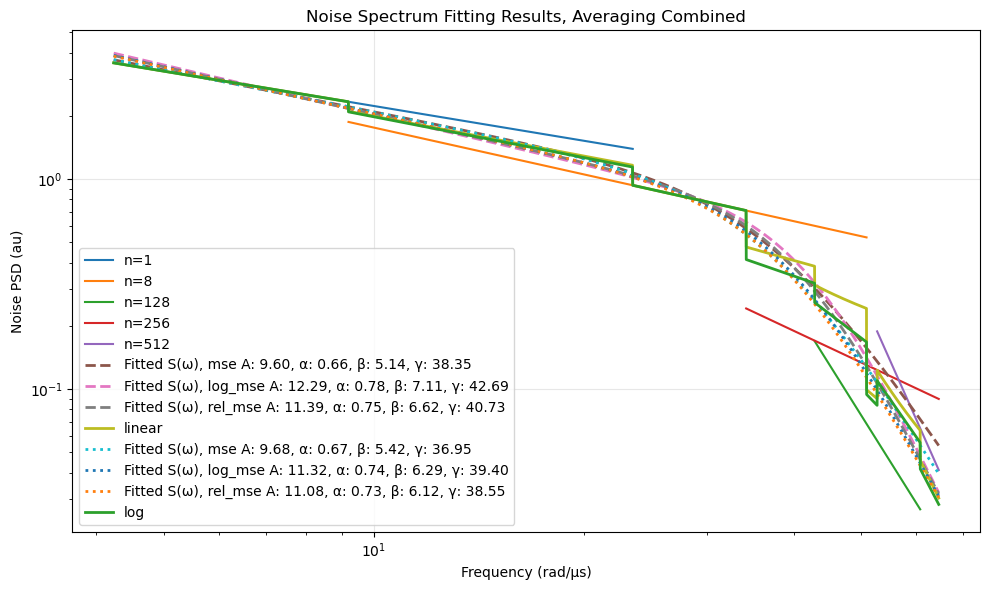

N = 1 C(t) std = 0.06175487114766966
freq_points (np.float64(4.23512649066821), np.float64(23.50650136048471))
N = 8 C(t) std = 0.039088696948713586
freq_points (np.float64(9.196118635830597), np.float64(50.87649161614278))
N = 128 C(t) std = 0.0999696718815984
freq_points (np.float64(42.86315744639821), np.float64(60.74255690282027))
N = 256 C(t) std = 0.07536401888654942
freq_points (np.float64(34.19128628343317), np.float64(64.57967449131452))
N = 512 C(t) std = 0.17421195458084981
freq_points (np.float64(52.68881080917576), np.float64(64.57967449131452))

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.036213082849111296
differential_evolution step 2: f(x)= 0.036213082849111296
differential_evolution step 3: f(x)= 0.036213082849111296
differential_evolution step 4: f(x)= 0.036213082849111296
differential_evolution step 5: f(x)= 0.02102163882755178
differential_evolution step 6: f(x)= 0.02102163882755178
differential_evolutio

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.827908, alpha=0.781062, beta > alpha: True
Optimization successful: True
Final loss: 0.005750100803725163
Optimized parameters:
Double power law params: {'A': [13.815861523355498], 'alpha': [0.7810619918476374], 'beta': [5.827907845265402], 'gamma': [40.6678643492734]}

Mean Squared Error: 5.750101e-03
R-squared: 0.994923

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.02914672327942291
differential_evolution step 2: f(x)= 0.02914672327942291
differential_evolution step 3: f(x)= 0.021184058902911505
differential_evolution step 4: f(x)= 0.016321390218484323
differential_evolution step 5: f(x)= 0.016321390218484323
differential_evolution step 6: f(x)= 0.012220431951234121
differential_evolution step 7: f(x)= 0.012220431951234121
differential_evolution step 8: f(x)= 0.012220431951234121
differential_evolution step 9: f(x)= 0.011269743033799033
differential_evolution step 10: f(x)= 

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=7.228325, alpha=0.843421, beta > alpha: True
Optimization successful: True
Final loss: 0.006628776811617881
Optimized parameters:
Double power law params: {'A': [15.675015402846979], 'alpha': [0.8434207968621336], 'beta': [7.228325131235496], 'gamma': [42.699911817622876]}

Mean Squared Error: 6.793912e-03
R-squared: 0.994001

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.23750684270560593
differential_evolution step 2: f(x)= 0.06090286517968724
differential_evolution step 3: f(x)= 0.06090286517968724
differential_evolution step 4: f(x)= 0.06090286517968724
differential_evolution step 5: f(x)= 0.06090286517968724
differential_evolution step 6: f(x)= 0.06090286517968724
differential_evolution step 7: f(x)= 0.06090286517968724
differential_evolution step 8: f(x)= 0.06090286517968724
differential_evolution step 9: f(x)= 0.06090286517968724
differential_evolution step 10: f(x)= 0.060

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=6.587533, alpha=0.806610, beta > alpha: True
Optimization successful: True
Final loss: 0.02979723361656868
Optimized parameters:
Double power law params: {'A': [14.46853734037759], 'alpha': [0.8066096993824663], 'beta': [6.587532926960689], 'gamma': [40.395670000706936]}

Mean Squared Error: 6.317878e-03
R-squared: 0.994421

Fitting with loss type: mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.09363365597595064
differential_evolution step 2: f(x)= 0.08122662749062844
differential_evolution step 3: f(x)= 0.08122662749062844
differential_evolution step 4: f(x)= 0.08122662749062844
differential_evolution step 5: f(x)= 0.04277685430509622
differential_evolution step 6: f(x)= 0.015223219627475524
differential_evolution step 7: f(x)= 0.015223219627475524
differential_evolution step 8: f(x)= 0.015223219627475524
differential_evolution step 9: f(x)= 0.015223219627475524
differential_evolution step 10: f(x)= 0.01522

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.989437, alpha=0.785732, beta > alpha: True
Optimization successful: True
Final loss: 0.006514630392442859
Optimized parameters:
Double power law params: {'A': [13.909693070229292], 'alpha': [0.7857316203622509], 'beta': [5.989437223568843], 'gamma': [38.34484159385938]}

Mean Squared Error: 6.514630e-03
R-squared: 0.994329

Fitting with loss type: log_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.00710953313111772
differential_evolution step 2: f(x)= 0.00710953313111772
differential_evolution step 3: f(x)= 0.00710953313111772
differential_evolution step 4: f(x)= 0.00710953313111772
differential_evolution step 5: f(x)= 0.00710953313111772
differential_evolution step 6: f(x)= 0.00710953313111772
differential_evolution step 7: f(x)= 0.00710953313111772
differential_evolution step 8: f(x)= 0.00710953313111772
differential_evolution step 9: f(x)= 0.00710953313111772
differential_evolution step 10: f(x)= 0.0071

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=6.019761, alpha=0.808653, beta > alpha: True
Optimization successful: True
Final loss: 0.003958473323420754
Optimized parameters:
Double power law params: {'A': [14.57399781627633], 'alpha': [0.808652637125161], 'beta': [6.019760654772339], 'gamma': [38.785847198404774]}

Mean Squared Error: 6.690295e-03
R-squared: 0.994176

Fitting with loss type: rel_mse
Created 1 constraints for beta > alpha
differential_evolution step 1: f(x)= 0.1383178058080719
differential_evolution step 2: f(x)= 0.04158595470825637
differential_evolution step 3: f(x)= 0.04158595470825637
differential_evolution step 4: f(x)= 0.04158595470825637
differential_evolution step 5: f(x)= 0.04158595470825637
differential_evolution step 6: f(x)= 0.04158595470825637
differential_evolution step 7: f(x)= 0.026834189071504103
differential_evolution step 8: f(x)= 0.026834189071504103
differential_evolution step 9: f(x)= 0.026834189071504103
differential_evolution step 10: f(x)= 0.026

/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)



Constraint verification:
Component 0: beta=5.726415, alpha=0.802589, beta > alpha: True
Optimization successful: True
Final loss: 0.019887720689985962
Optimized parameters:
Double power law params: {'A': [14.356038942707533], 'alpha': [0.8025893250207036], 'beta': [5.72641454452364], 'gamma': [37.638894539474336]}

Mean Squared Error: 7.033827e-03
R-squared: 0.993877


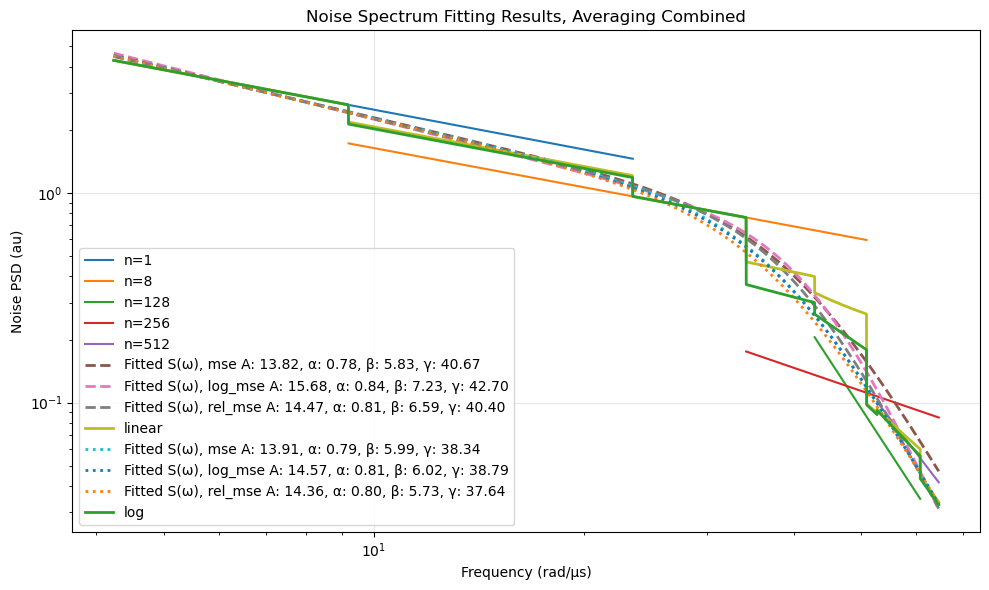

In [12]:
for q, FWFF_params in tenumerate(bootstrap_samples):

    ### Time this cell on my laptop: 3m  if you do all 6 optimizations (3 loss functions)*(2 averaging strategies)###

    # N cases to plot
    Ns = [1, 8, 128, 256, 512]
    tau_p = 0.024  # pi pulse width in microseconds

    #########################################################

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    plt.figure(figsize=(10, 6))
    for idx, n in enumerate(Ns):
        FWFF_dict = {
        "N1f": 1, # Number of 1/f noise parameters
        "Nlor": 0, # Number of Lorentzian noise parameters
        "NC": 0, # Number of white noise parameters
        "Ndpl": 0, # Number of combined fraction noise parameters
        "N": n, #CPMG-N (test spin echo)
        "tau_p": tau_p, #pi pulse width in mircoseconds
        "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
        "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
        "omega_range" : (10**(-4), 10**8), # The number of peaks to use in the filter function
        "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
        "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
        # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
        # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
        # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
        
        }
        n_df = df[df["N_pi"]==n]
        time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten() # multiply by 10**-3 to convert from nanoseconds to microseconds
        C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
        C_t_FWFF = func_to_fit(time_points, ns.noise_spectrum_1f, *FWFF_params[n], delta=False, **FWFF_dict)
        C_t_delta = func_to_fit(time_points, ns.noise_spectrum_1f, *delta_params[n], delta=True, **FWFF_dict)
        sig = np.std(C_t_observed-C_t_FWFF) # computes sigma from C(t) residual
        # sig = np.std(C_t_observed-C_t_delta)
        print("N =", n, "C(t) std =", sig)
        time_points = time_points[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
        C_t_observed = C_t_observed[find_widest_contiguous_stretch(C_t_observed, sig, 1-sig)]
        # time_points = (1e-3)*np.array(df['time_points'][idx])
        # time_points = np.logspace(np.log10(0.1), np.log10(100), 100)
        
        freq_points = (n*np.pi/time_points)
        print("freq_points", (np.min(freq_points), np.max(freq_points)))
        noise_ff = ns.noise_spectrum_1f(freq_points, *FWFF_params[n])
        noise_delta = ns.noise_spectrum_1f(freq_points, *delta_params[n])
        plt.plot(freq_points, noise_ff,'-', label=f'n={n}')
        # plt.plot(freq_points, noise_delta,'-')

    ########### CHANGE WHICH AVERAGING STRATEGY YOU WANT TO USE HERE ###########
    for j, average in enumerate(["linear","log"]):

        freq_points_combined = combined_noise_dict[q][average]["freq_points"]
        S_w_combined_ff = combined_noise_dict[q][average]["S_w_combined_ff"]
        S_w_combined_delta = combined_noise_dict[q][average]["S_w_combined_delta"]

        combined_noise_dict[q][average]["optimized_args"] = {}

        ############### CHANGE WHICH LOSS TYPE YOU WANT TO USE HERE ###############
        for loss_type in ["mse",'log_mse','rel_mse']:
        # for loss_type in ['log_mse']:
        # for loss_type in ['mse']:
            print(f"\nFitting with loss type: {loss_type}")
            # Fit with combined fraction noise and constraints
            optimized_args, opt_result = fit_noise_spectrum(
                freq_points_combined, 
                S_w_combined_ff, # uses FW-FF combined data
                # S_w_combined_delta,  # uses delta approximation combined data
                N1f=0, 
                Nlor=0, 
                NC=0, 
                Ndpl=1,
                method='diff_ev',  # or 'L-BFGS-B'
                loss_type=loss_type,
                use_constraints=True,  # Enable beta > alpha constraint
                population=500,
                iterations=2000
            )

            combined_noise_dict[q][average]["optimized_args"][loss_type] = optimized_args

            print("Optimization successful:", opt_result.success)
            print("Final loss:", opt_result.fun)
            print("Optimized parameters:")
            for i, arg_dict in enumerate(optimized_args):
                if arg_dict:  # Only print non-empty dictionaries
                    param_names = ["1/f params", "Lorentzian params", "White noise params", "Double power law params"]
                    print(f"{param_names[i]}: {arg_dict}")

            formatted_string = f"A: {optimized_args[-1]['A'][0]:.2f}, α: {optimized_args[-1]['alpha'][0]:.2f}, β: {optimized_args[-1]['beta'][0]:.2f}, γ: {optimized_args[-1]['gamma'][0]:.2f}"

            # Generate fitted noise spectrum for plotting
            S_w_fitted = ns.noise_spectrum_combination(freq_points_combined, *optimized_args)
            if average == "linear":
                plt.plot(freq_points_combined, S_w_fitted, '--', linewidth=2, 
                        label=f'Fitted S(ω), {loss_type} {formatted_string}')
            elif average == "log":
                plt.plot(freq_points_combined, S_w_fitted, ':', linewidth=2, 
                        label=f'Fitted S(ω), {loss_type} {formatted_string}')
            else:
                plt.plot(freq_points_combined, S_w_fitted, '--', linewidth=2, 
                        label=f'Fitted S(ω), {loss_type} {formatted_string}')

            # Print fitting quality
            mse = mean_squared_error(S_w_combined_ff, S_w_fitted)
            print(f"\nMean Squared Error: {mse:.6e}")

            ##### Change S_w_combined_ff to S_w_combined_delta if you want to use the delta approximation combined data instead #####
            # Calculate R-squared
            ss_res = np.sum((S_w_combined_ff - S_w_fitted) ** 2)
            ss_tot = np.sum((S_w_combined_ff - np.mean(S_w_combined_ff)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            print(f"R-squared: {r_squared:.6f}")

        # Plot comparison
        plt.plot(freq_points_combined, S_w_combined_ff, '-', linewidth=2, label=f'{average}')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency (rad/μs)')
    plt.ylabel('Noise PSD (au)')
    plt.legend()
    plt.title(f'Noise Spectrum Fitting Results, Averaging Combined')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Next we compute all of the $C_N(t)$ that result from the noise fitting.

  0%|          | 0/3 [00:00<?, ?it/s]


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


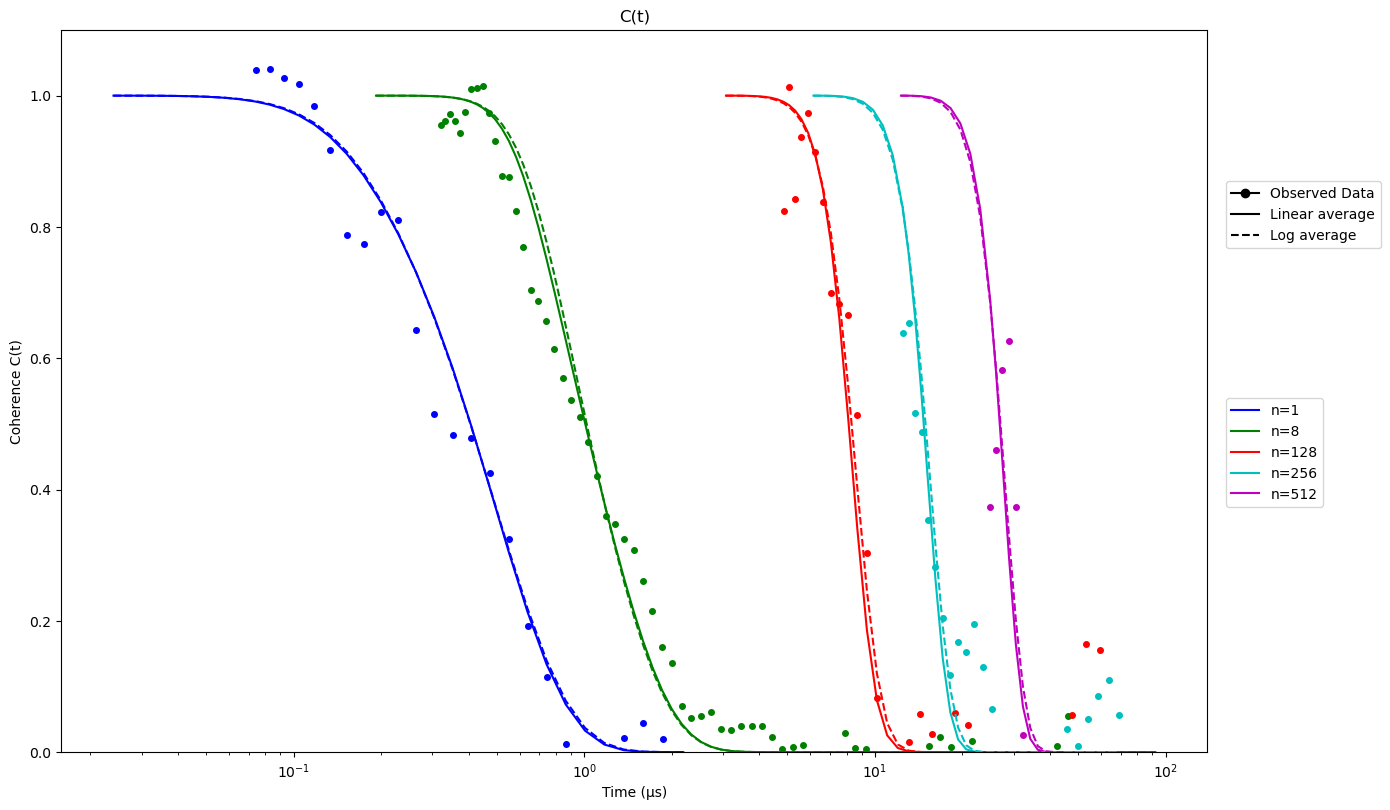


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


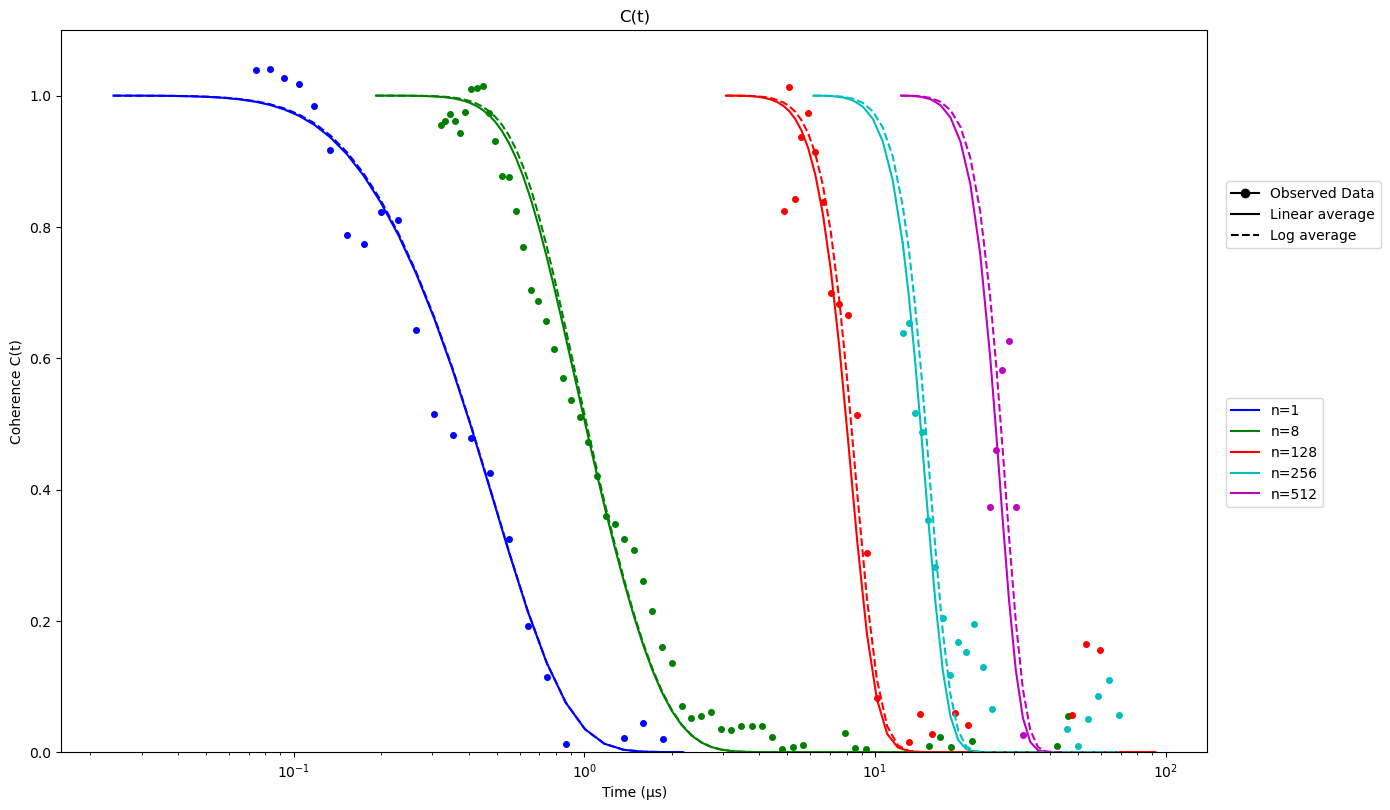


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


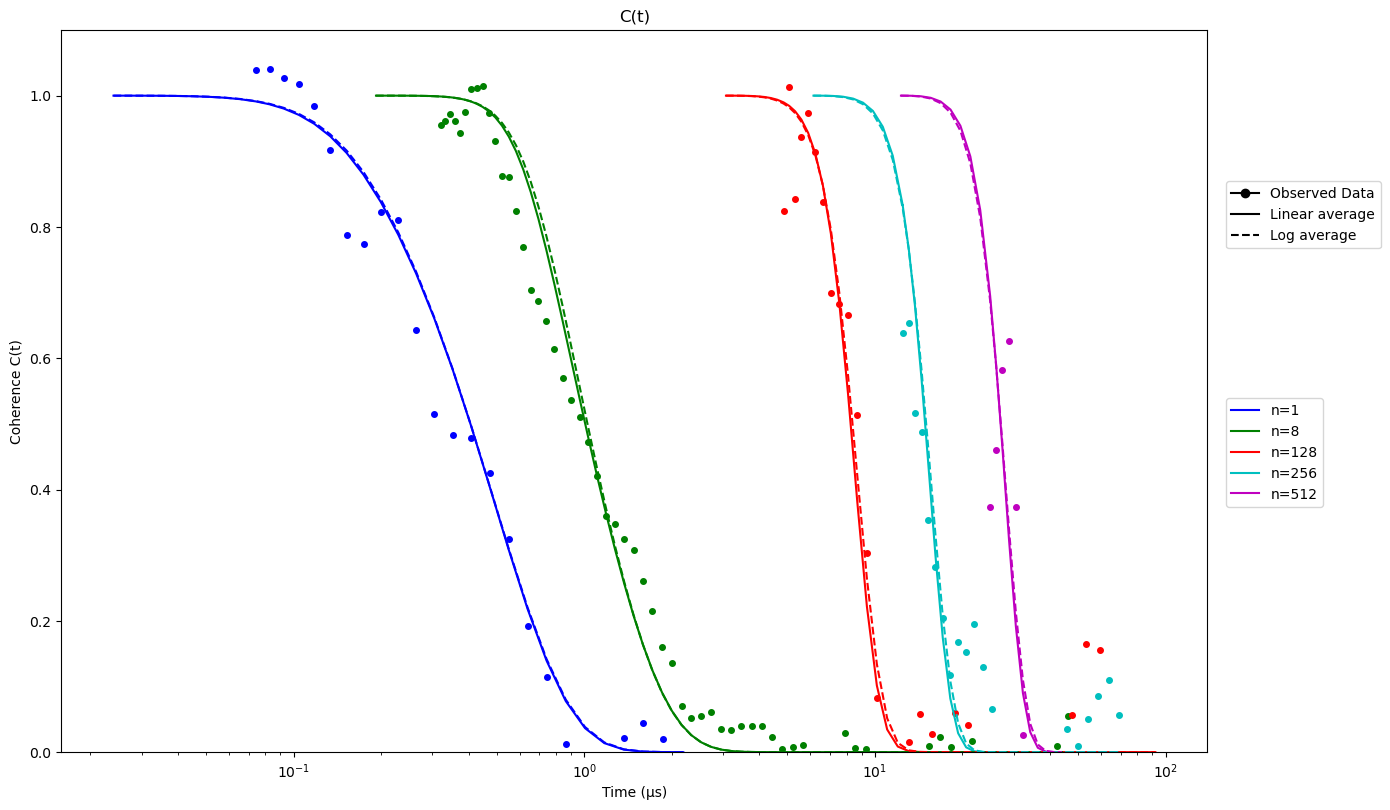


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


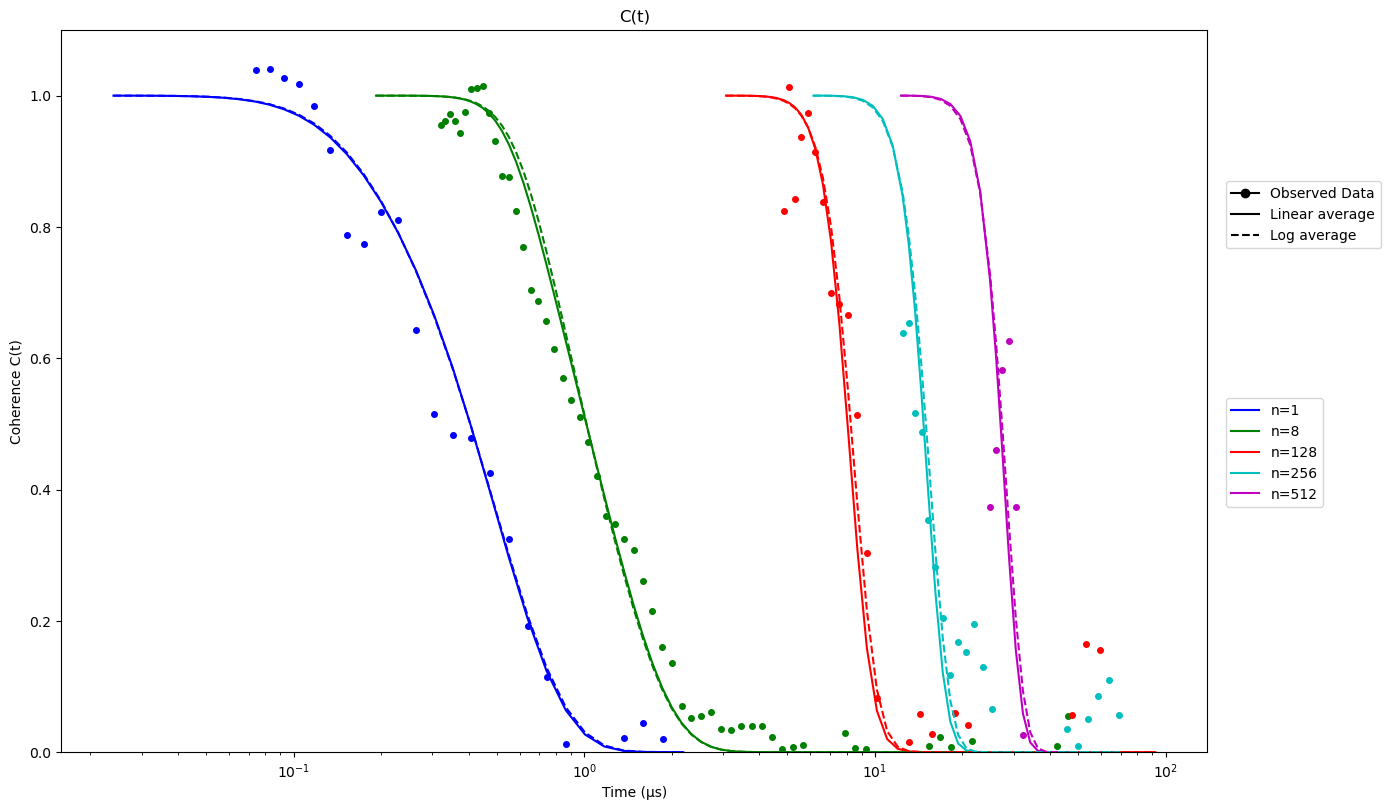


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


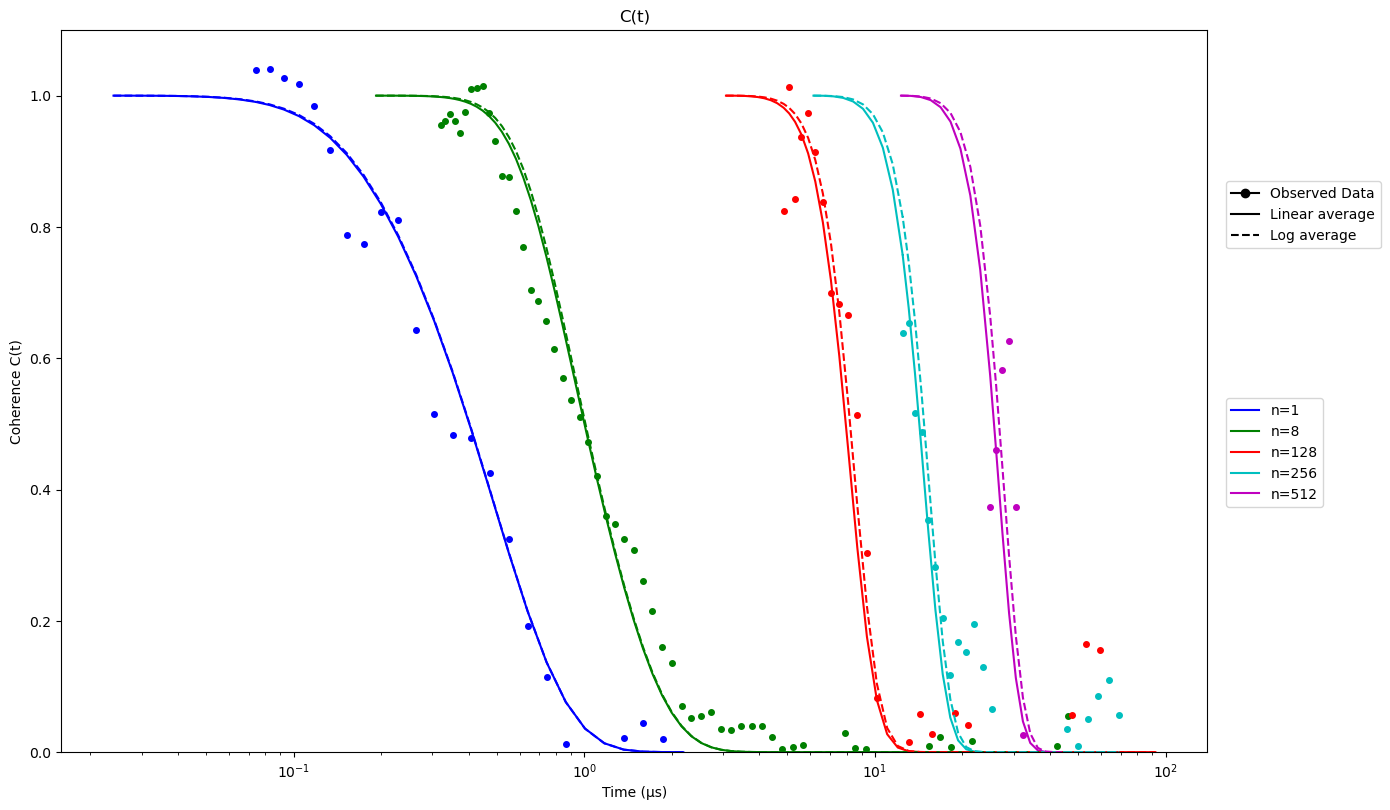


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


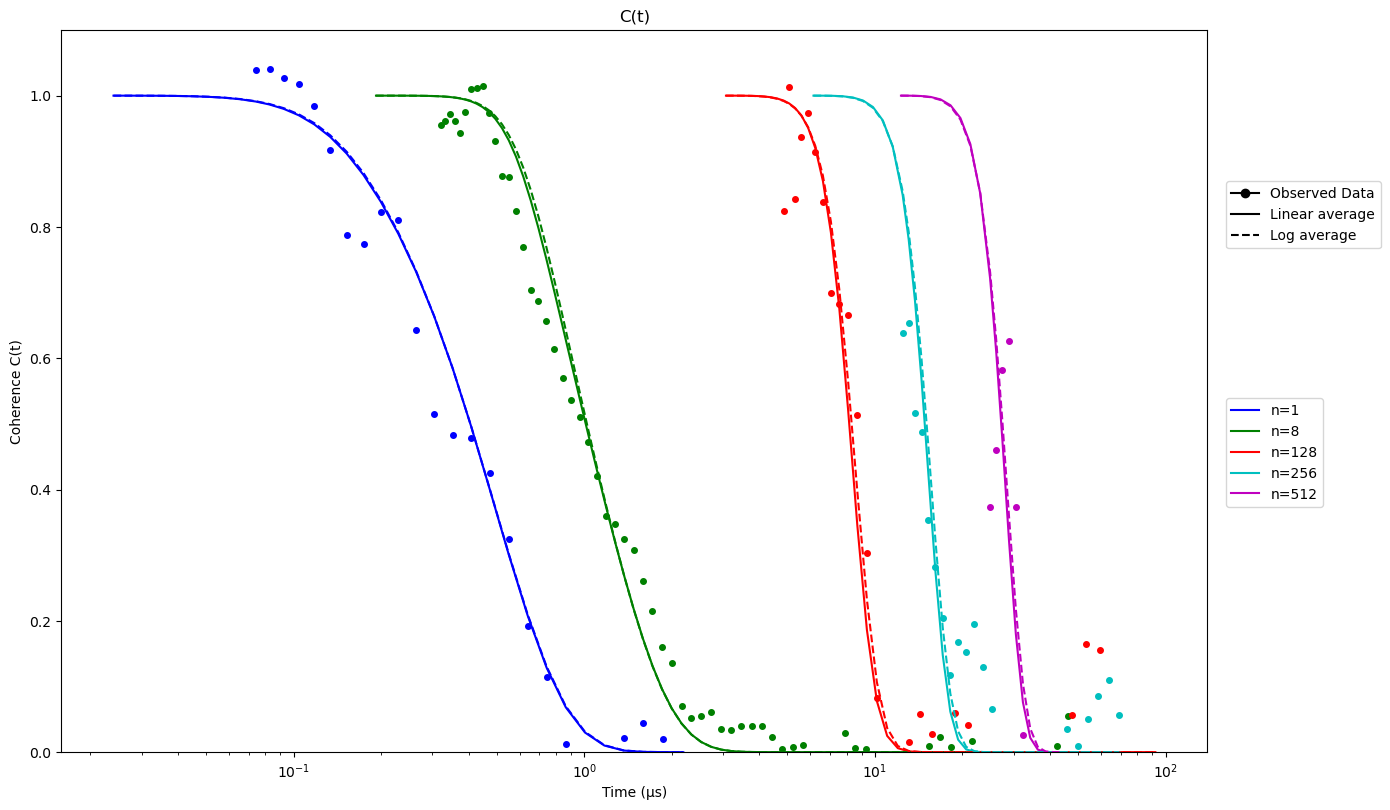


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


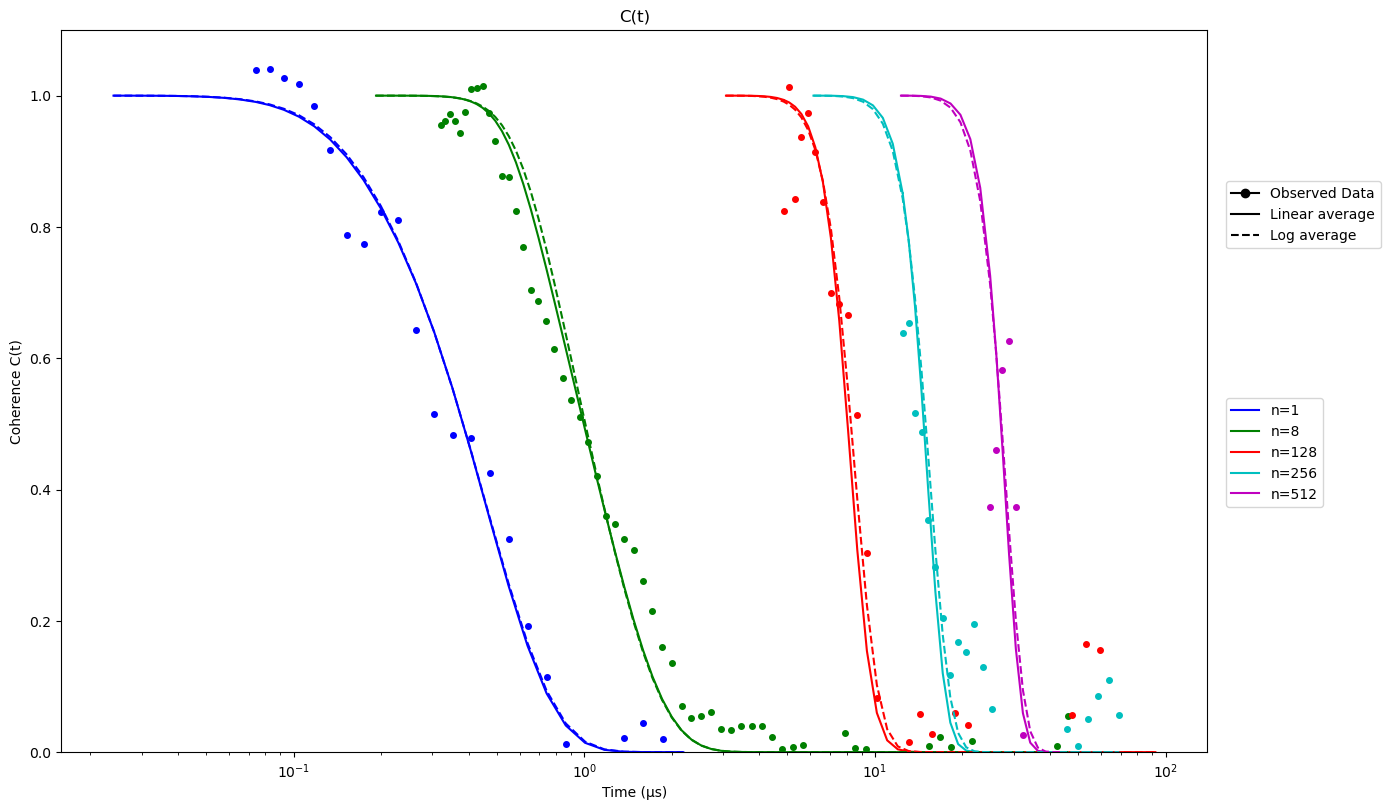


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


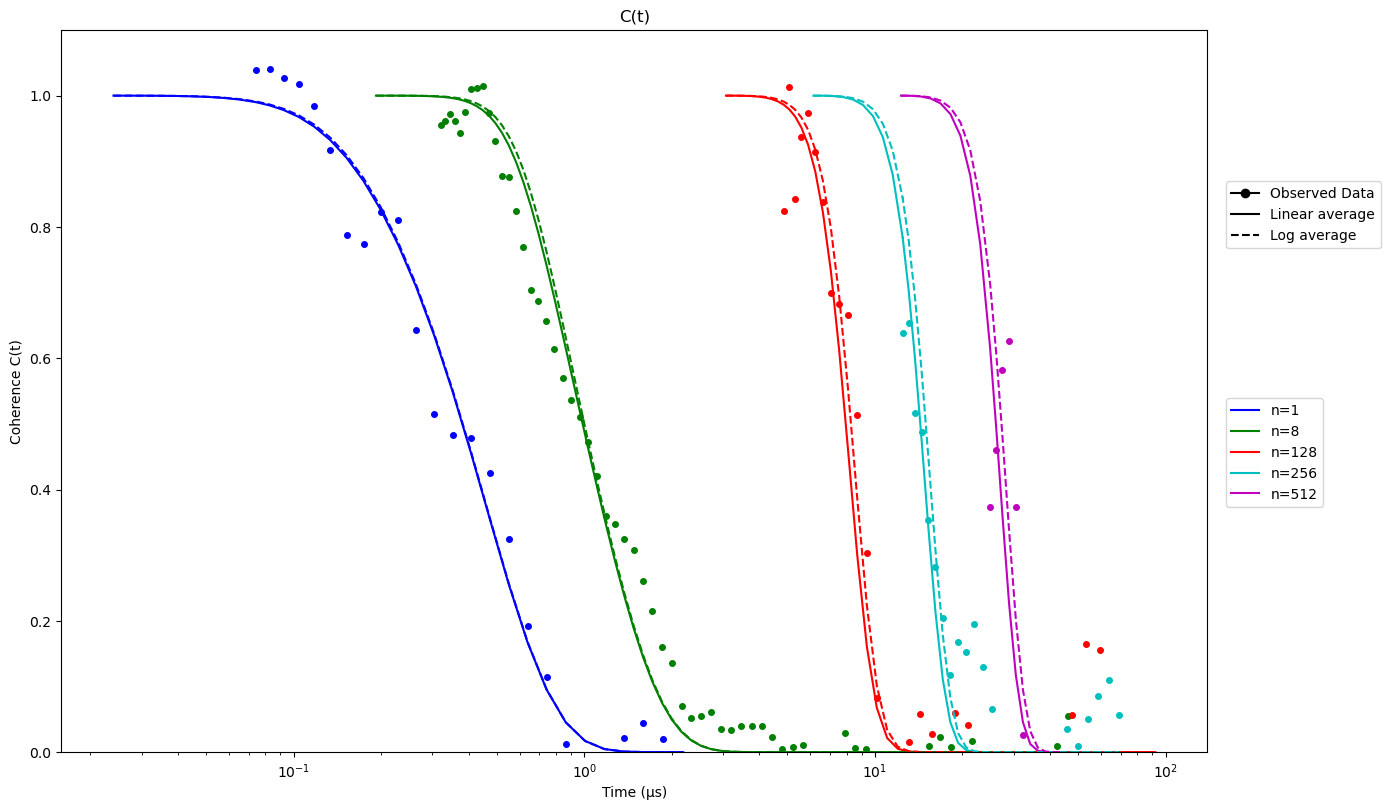


Averaging method: linear
n=1
n=8
n=128
n=256
n=512

Averaging method: log
n=1
n=8
n=128
n=256
n=512


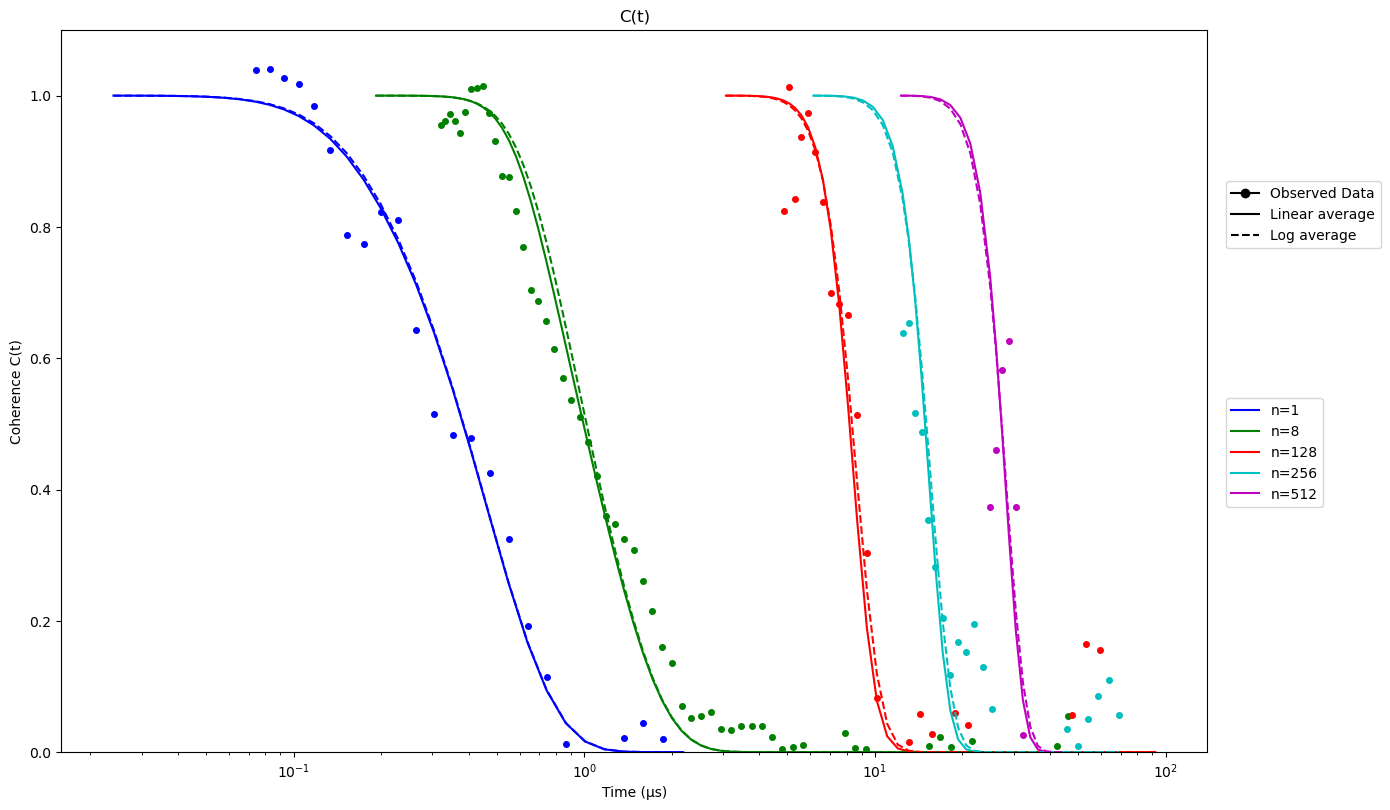

In [13]:
for q, FWFF_params in tenumerate(bootstrap_samples):

    ##### Given the Double Power Law fit parameters, from the previous cell, plot the noise spectrum and coherence decay profile #####

    ### Time this cell on my laptop: 1m  if you do both linear and log averages ###

    ##### Choose which optimization loss function parameters to use #####

    for loss_type in ['log_mse','mse','rel_mse']:
        ########### S(w) plots, helpful to compare the noise learned from different combinatinons of averaging strategy and loss function ##########

        # plt.figure(figsize=(14,8))
        # ########### CHANGE WHICH AVERAGING STRATEGY YOU WANT TO USE HERE ###########
        # for idx, average in enumerate(["linear", "log"]):
        #     combined_S_w = []
        #     combined_frequencies = []
        #     print(f"\nAveraging method: {average}")
        #     # Define the frequency range for plotting
        #         # 1/f noise, individual fitting:

        #     if average == "linear":
        #         # linear
        #         Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
        #         # Ct_delta_params = [{},{},{},{'A': [27.21/2], 'alpha': [0.76], 'beta': [6.57], 'gamma': [40]}]
        #     elif average == "log":
        #         # log
        #         Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
        #         # Ct_delta_params = [{},{},{},{'A': [25.82/2], 'alpha': [0.73], 'beta': [6.17], 'gamma': [38.06]}]
        #     else:
        #         # @souvkik ignore this for now
        #         # yellow line
        #         Ct_delta_params = [{},{},{},{'A': [31.053425953233358], 'alpha': [0.8646663970527808], 'beta': [7.539874168582798], 'gamma': [41.316595893676684]}]


        #     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

        #     with open("XY8data_normtotpi1_v3.json","r") as file:
        #         data = json.load(file)

        #     del data["y_fit"]
        #     df = pd.DataFrame(data)

        #     Ns = [int(n) for n in df["N_pi"]]
        #     # Ns = [1,8, 128]
        #     freq_points = np.logspace(0, 2, 1000)
        #     noise_ff = noise_spectrum_combination(freq_points, *Ct_FWFF_params)
        #     if average == "linear":
        #         plt.plot(freq_points, noise_ff,'-', label=f'{average}')
        #     else:
        #         plt.plot(freq_points, noise_ff,'--', label=f'{average}')

        # plt.xscale('log')  
        # plt.yscale('log')  
        # plt.xlabel('Frequency (rad/μs)')
        # plt.ylabel('Noise PSD (au)')
        # plt.ylim(1e-1, 1e1)
        # plt.title((f"S(w) for, {loss_type} loss function"))
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

        ########## C(t) plots ##########

        plt.figure(figsize=(14,8))
        ########### CHANGE WHICH AVERAGING STRATEGY YOU WANT TO USE HERE ###########
        for average in ["linear", "log"]:
            print(f"\nAveraging method: {average}")
            # Define the frequency range for plotting
                # 1/f noise, individual fitting:

            if average == "linear":
                # linear
                Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
                # Ct_delta_params = [{},{},{},{'A': [27.21/2], 'alpha': [0.76], 'beta': [6.57], 'gamma': [40]}]
            elif average == "log":
                # log
                Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
                # Ct_delta_params = [{},{},{},{'A': [25.82/2], 'alpha': [0.73], 'beta': [6.17], 'gamma': [38.06]}]
            else:
                # yellow line
                # # Ct_delta_params = [{},{},{},{'A': [31.489138214797908/2], 'alpha': [0.8674390760764802], 'beta': [18.14256555129588], 'gamma': [44.37699777661546]}]
                Ct_delta_params = [{},{},{},{'A': [31.053425953233358/2], 'alpha': [0.8646663970527808], 'beta': [7.539874168582798], 'gamma': [41.316595893676684]}]


            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

            with open("data/example_XY8data_normtotpi1.json","r") as file:
                data = json.load(file)

            del data["y_fit"]
            df = pd.DataFrame(data)

            Ns = [int(n) for n in df["N_pi"]]
            # Ns = [1,8, 128]

            tau_p = 0.024

            combined_noise_dict[q][average]["C_t_FWFF"][loss_type] = {}

            for idx, n in enumerate(Ns):
                FWFF_dict = {
                    "N1f": 0,
                    "Nlor": 0,
                    "NC": 0,
                    "Ndpl": 1,
                    "N": n,
                    "tau_p": tau_p,
                    "integration_method": "trapezoid",
                    "omega_resolution": int(10**5),
                    "omega_range" : (10**(-4), 10**8),
                    "num_peaks_cutoff": 100,
                    "peak_resolution": 100,
                }
                
                n_df = df[df["N_pi"]==n]
                time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten()
                time_points_plus = np.append(np.logspace(np.log10(n*FWFF_dict["tau_p"]+1e-10),np.log10(time_points[0]),10), time_points)
                C_t_observed = np.array(n_df["C_t"].to_list()).flatten()
                C_t_FWFF = func_to_fit(time_points_plus, ns.noise_spectrum_combination, *Ct_FWFF_params, delta=False, **FWFF_dict)

                combined_noise_dict[q][average]["C_t_FWFF"][loss_type][n] = C_t_FWFF

                print(f"n={n}")
                # print(np.linalg.norm(C_t_FWFF - C_t_delta))
                
                if average == "linear":
                    plt.plot(time_points, C_t_observed, 'o', color=colors[idx], markersize=4)
                    plt.plot(time_points_plus, C_t_FWFF, '-', color=colors[idx],label=f'n={n}')
                elif average == "log":
                    plt.plot(time_points_plus, C_t_FWFF, '--', color=colors[idx])
                else:
                    plt.plot(time_points_plus, C_t_FWFF, ':', color=colors[idx])

        plt.xscale('log')
        plt.xlabel('Time (μs)')
        plt.ylabel('Coherence C(t)')
        plt.ylim([0, 1.1])

        # Second legend for colors/n values
        color_legend = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left')

        # First legend for line styles (in black)
        line_legend_elements = [plt.Line2D([0], [0], color='black', marker='o', label='Observed Data'),
                                plt.Line2D([0], [0], color='black', linestyle='-', label='Linear average'),
                                plt.Line2D([0], [0], color='black', linestyle='--', label='Log average'),
                                # plt.Line2D([0], [0], color='black', linestyle=':', label='Yellow line')
                            ]
        line_legend = plt.legend(handles=line_legend_elements, bbox_to_anchor=(1.01, 0.8), loc='upper left')

        # Add the first legend back (matplotlib removes it when creating the second)
        plt.gca().add_artist(color_legend)

        plt.tight_layout()
        plt.title(f'C(t)')
        plt.show()

In [14]:
def calculate_stats_numpy(data):
    """Calculate mean and std for each parameter using numpy."""
    # Extract values for each parameter
    parameters = {}
    
    # Get all parameter names from first dictionary
    param_names = data[0].keys()
    
    for param in param_names:
        # Extract all values for this parameter (flatten the lists)
        values = []
        for sample in data:
            values.extend(sample[param])  # extend because values are in lists
        parameters[param] = values
    
    # Calculate statistics
    stats = {}
    for param, values in parameters.items():
        stats[param] = {
            'mean': np.mean(values),
            'std': np.std(values, ddof=1),  # ddof=1 for sample std deviation
            'values': values
        }
    
    return stats


parm_uncertainties = {}

averaging_types = ["linear","log"]
loss_types = ['log_mse', 'mse', 'rel_mse']  # You can add more loss types if needed

for q in range(len(combined_noise_dict)):
    for average in averaging_types:
        if q == 0:
            parm_uncertainties[average] = {}
        for loss_type in loss_types:
            if q == 0:
                parm_uncertainties[average][loss_type] = []
            # print(f"\nAveraging method: {average}, Loss type: {loss_type}")
            # print("Optimized parameters:")
            optimized_args = combined_noise_dict[q][average]["optimized_args"][loss_type]
            for i, arg_dict in enumerate(optimized_args):
                if arg_dict:  # Only print non-empty dictionaries
                    param_names = ["1/f params", "Lorentzian params", "White noise params", "Double power law params"]
                    # print(f"{param_names[i]}: {arg_dict}")
                    parm_uncertainties[average][loss_type].append(arg_dict)



for average in averaging_types:
    for loss_type in loss_types:
        print(f"\nAveraging method: {average}, Loss type: {loss_type}")
        stats = calculate_stats_numpy(parm_uncertainties[average][loss_type])
        for param, values in stats.items():
            print(f"{param} - Mean: {values['mean']:.4f}, Std: {values['std']:.4f}")


Averaging method: linear, Loss type: log_mse
A - Mean: 12.8797, Std: 2.5524
alpha - Mean: 0.7816, Std: 0.0621
beta - Mean: 6.8522, Std: 0.5497
gamma - Mean: 41.8246, Std: 1.5084

Averaging method: linear, Loss type: mse
A - Mean: 11.1422, Std: 2.3247
alpha - Mean: 0.7095, Std: 0.0632
beta - Mean: 5.4553, Std: 0.3463
gamma - Mean: 39.3549, Std: 1.1893

Averaging method: linear, Loss type: rel_mse
A - Mean: 11.8591, Std: 2.4083
alpha - Mean: 0.7428, Std: 0.0662
beta - Mean: 6.3193, Std: 0.4913
gamma - Mean: 39.5750, Std: 1.7203

Averaging method: log, Loss type: log_mse
A - Mean: 11.8287, Std: 2.5296
alpha - Mean: 0.7394, Std: 0.0712
beta - Mean: 5.8960, Std: 0.4713
gamma - Mean: 38.1218, Std: 1.7064

Averaging method: log, Loss type: mse
A - Mean: 11.2293, Std: 2.3305
alpha - Mean: 0.7146, Std: 0.0628
beta - Mean: 5.6810, Std: 0.2867
gamma - Mean: 37.5428, Std: 0.7196

Averaging method: log, Loss type: rel_mse
A - Mean: 11.5835, Std: 2.5577
alpha - Mean: 0.7297, Std: 0.0750
beta - Mean

In [15]:
# Save to a file
# with open(os.path.join(save_dir, 'bootstrap_data.pkl'), 'wb') as f:
#     pickle.dump(combined_noise_dict, f)

# Units and Conversion

The units we used for $\omega$ above are (rad/$\mu s$). To convert to Hz, to consider $S(f)$ instead of $S(\omega)$ we can convert by multiplying the scale parameter A ($S_0$ in the paper) by $2\pi$ to convert from radians to MHz since $S(f) = 2\pi S(\omega)$,  then multiply by $10**6$ to convert to Hz. Finally, we must also multiply by a factor of $10^\alpha$ since when converting the frequency $f$ to Hz, we have $(f*10^6)^\alpha$. The units of $\gamma$ are the same as those for $\omega$, so we perform the same manipulations on $\gamma$ as $\omega$. Values reported here may differ from the paper due to variance in learned parameters in the optimization.

In [16]:
print(f"A (Hz): {stats['A']['mean']*(2*np.pi)*10**(6*stats['alpha']['mean']):.2e} +/- {stats['A']['std']*(2*np.pi)*10**(6*stats['alpha']['mean']):.2e}")
print(f"γ (Hz): {stats['gamma']['mean']/(2*np.pi)*10**6:.2e} +/- {stats['gamma']['std']/(2*np.pi)*10**6:.2e}")

A (Hz): 1.74e+06 +/- 3.84e+05
γ (Hz): 5.91e+06 +/- 2.82e+05


# (Bonus) Streched Exponentail Fitting

Given the $C_N(t)$ found from the fitted parameters, you may want to see how well  these fit to a streched exponential of the form $C(t) = \exp(-(t / T_1)^\beta)$. Below is code to do that and observe the parameters change with respect to the number of dynamical decoupling $\pi$ pulses, $N$.


Averaging method: linear, Loss type: log_mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [15.675015402846979], 'alpha': [0.8434207968621336], 'beta': [7.228325131235496], 'gamma': [42.699911817622876]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


<Figure size 1400x800 with 0 Axes>

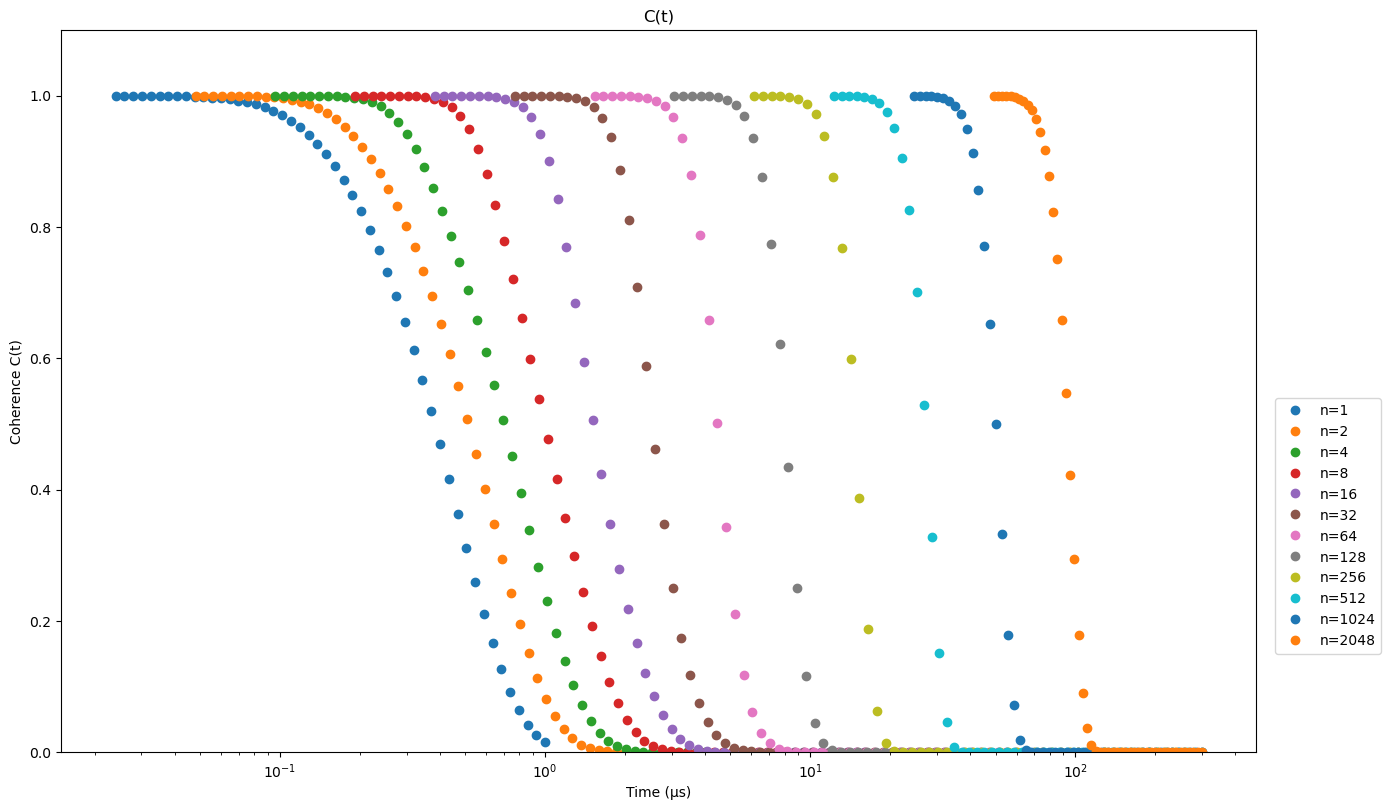


Averaging method: linear, Loss type: mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [13.815861523355498], 'alpha': [0.7810619918476374], 'beta': [5.827907845265402], 'gamma': [40.6678643492734]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


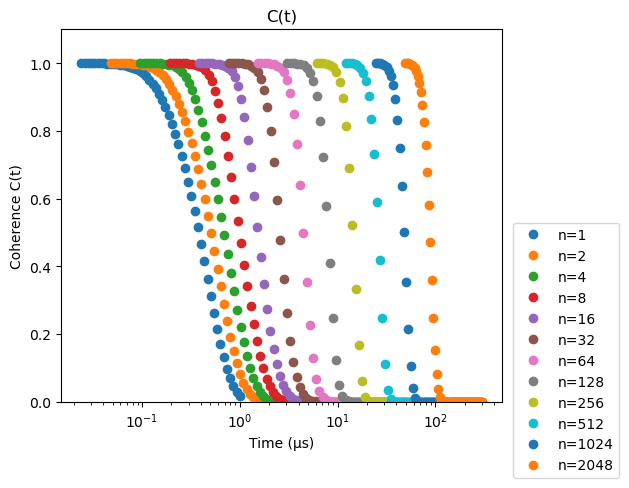


Averaging method: linear, Loss type: rel_mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [14.46853734037759], 'alpha': [0.8066096993824663], 'beta': [6.587532926960689], 'gamma': [40.395670000706936]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


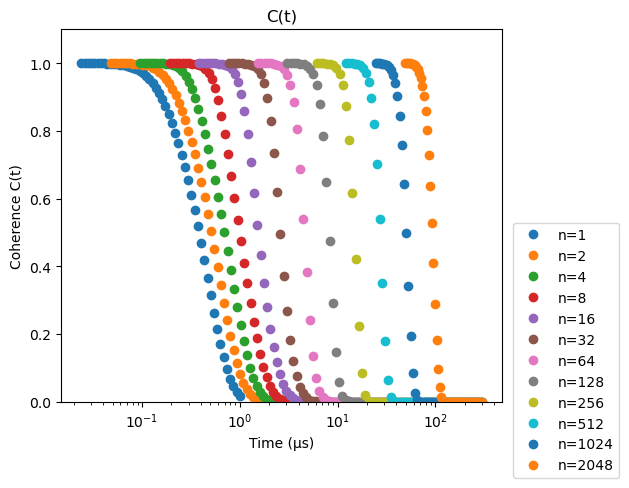


Averaging method: log, Loss type: log_mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [14.57399781627633], 'alpha': [0.808652637125161], 'beta': [6.019760654772339], 'gamma': [38.785847198404774]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


/tmp/ipykernel_3151/2379885374.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left')


<Figure size 1400x800 with 0 Axes>

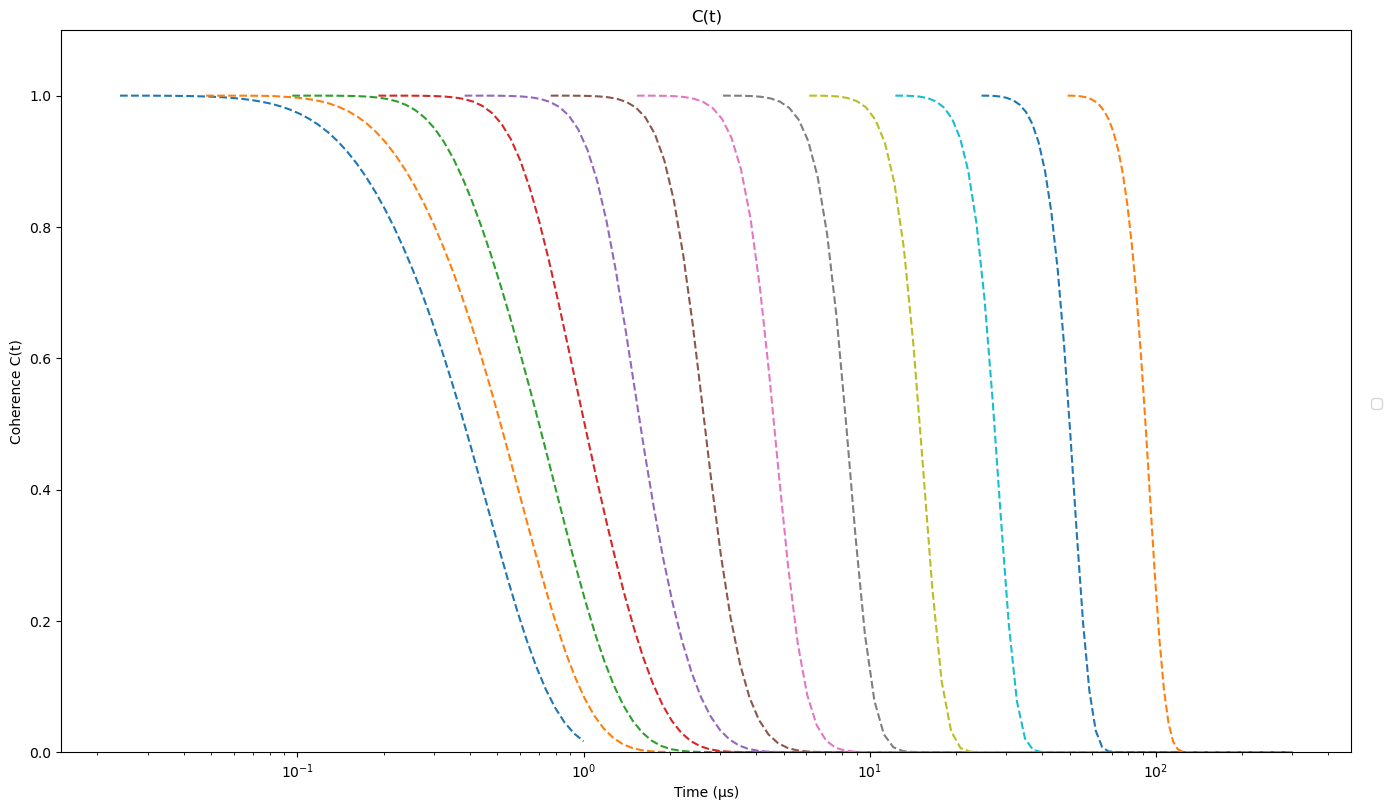


Averaging method: log, Loss type: mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [13.909693070229292], 'alpha': [0.7857316203622509], 'beta': [5.989437223568843], 'gamma': [38.34484159385938]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


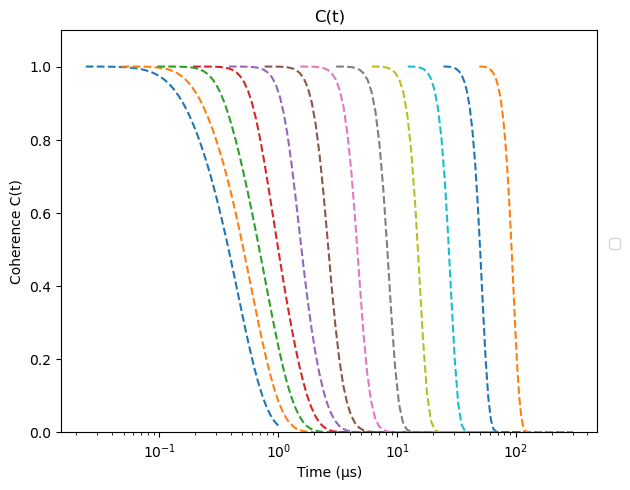


Averaging method: log, Loss type: rel_mse
Optimal Parameters for FW-FF fit: [{}, {}, {}, {'A': [14.356038942707533], 'alpha': [0.8025893250207036], 'beta': [5.72641454452364], 'gamma': [37.638894539474336]}]


  0%|          | 0/12 [00:00<?, ?it/s]

n=1
n=2
n=4
n=8
n=16
n=32
n=64
n=128
n=256
n=512
n=1024
n=2048


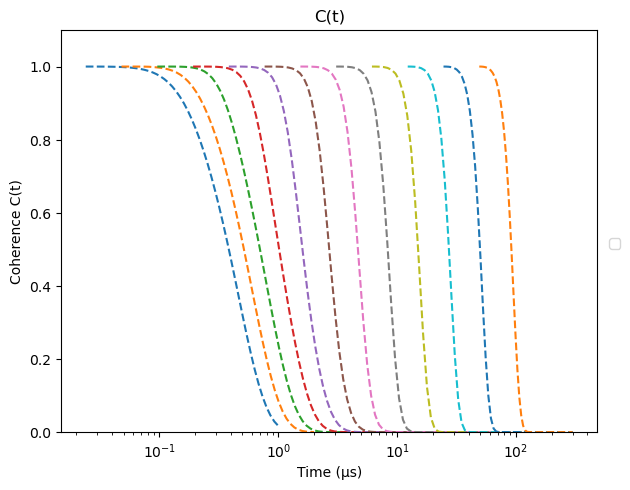

In [17]:
C_t_save_me = {}

for average in ["linear", "log"]:
    ########### S(w) plots, helpful to compare the noise learned from different combinatinons of averaging strategy and loss function ##########

    plt.figure(figsize=(14,8))

    C_t_save_me[average] = {}
    ########## C(t) plots ##########

    plt.figure(figsize=(14,8))
    ########### CHANGE WHICH AVERAGING STRATEGY YOU WANT TO USE HERE ###########
    for loss_type in ['log_mse','mse','rel_mse']:
        C_t_save_me[average][loss_type] = {}
        print(f"\nAveraging method: {average}, Loss type: {loss_type}")
        # Define the frequency range for plotting
            # 1/f noise, individual fitting:

        if average == "linear":
            # linear
            Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
            # Ct_delta_params = [{},{},{},{'A': [27.21/2], 'alpha': [0.76], 'beta': [6.57], 'gamma': [40]}]
        elif average == "log":
            # log
            Ct_FWFF_params = combined_noise_dict[q][average]["optimized_args"][loss_type] 
            # Ct_delta_params = [{},{},{},{'A': [25.82/2], 'alpha': [0.73], 'beta': [6.17], 'gamma': [38.06]}]
        else:
            # yellow line
            # # Ct_delta_params = [{},{},{},{'A': [31.489138214797908/2], 'alpha': [0.8674390760764802], 'beta': [18.14256555129588], 'gamma': [44.37699777661546]}]
            Ct_delta_params = [{},{},{},{'A': [31.053425953233358/2], 'alpha': [0.8646663970527808], 'beta': [7.539874168582798], 'gamma': [41.316595893676684]}]

        print("Optimal Parameters for FW-FF fit:", Ct_FWFF_params)


        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

        with open("data/example_XY8data_normtotpi1.json","r") as file:
            data = json.load(file)

        del data["y_fit"]
        df = pd.DataFrame(data)

        # Ns = [int(n) for n in df["N_pi"]]
        # Ns = [int(n) for n in np.concatenate(([1],np.linspace(5, 2050, 410)))]
        Ns = [2**i for i in range(12)]
        # Ns = [1000,2050]

        tau_p = 0.024

        # combined_noise_dict[q][average]["C_t_FWFF"][loss_type] = {}

        for idx, n in tenumerate(Ns):
            FWFF_dict = {
                "N1f": 0,
                "Nlor": 0,
                "NC": 0,
                "Ndpl": 1,
                "N": n,
                "tau_p": tau_p,
                "integration_method": "trapezoid",
                "omega_resolution": int(10**5),
                "omega_range" : (10**(-4), 10**8),
                "num_peaks_cutoff": 100,
                "peak_resolution": 100,
            }
            
            # n_df = df[df["N_pi"]==n]
            # time_points = (10**-3)*np.array(n_df["time_points"].to_list()).flatten()
            # time_points_plus = np.append(np.logspace(np.log10(n*FWFF_dict["tau_p"]+1e-10),np.log10(time_points[0]),10), time_points)
            # C_t_observed = np.array(n_df["C_t"].to_list()).flatten()

            time_points_plus = np.logspace(np.log10(n*FWFF_dict["tau_p"]+1e-10), np.log10(np.min((FWFF_dict["N"],300))), 50)
            C_t_FWFF = func_to_fit(time_points_plus, ns.noise_spectrum_combination, *Ct_FWFF_params, delta=False, **FWFF_dict)

            C_t_save_me[average][loss_type][n] = C_t_FWFF

            # combined_noise_dict[q][average]["C_t_FWFF"][loss_type][n] = C_t_FWFF

            print(f"n={n}")
            # print(np.linalg.norm(C_t_FWFF - C_t_delta))
            
            if average == "linear":
                # plt.plot(time_points, C_t_observed, 'o', color=colors[idx], markersize=4)
                plt.plot(time_points_plus, C_t_FWFF, 'o', label=f'n={n}')
            elif average == "log":
                plt.plot(time_points_plus, C_t_FWFF, '--')
            else:
                plt.plot(time_points_plus, C_t_FWFF, ':')

        plt.xscale('log')
        plt.xlabel('Time (μs)')
        plt.ylabel('Coherence C(t)')
        plt.ylim([0, 1.1])

        # Second legend for colors/n values
        plt.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left')

        # # First legend for line styles (in black)
        # line_legend_elements = [plt.Line2D([0], [0], color='black', marker='o', label='Observed Data'),
        #                         plt.Line2D([0], [0], color='black', linestyle='-', label='Linear average'),
        #                         plt.Line2D([0], [0], color='black', linestyle='--', label='Log average'),
        #                         # plt.Line2D([0], [0], color='black', linestyle=':', label='Yellow line')
        #                     ]
        # line_legend = plt.legend(handles=line_legend_elements, bbox_to_anchor=(1.01, 0.8), loc='upper left')

        # Add the first legend back (matplotlib removes it when creating the second)
        # plt.gca().add_artist(color_legend)

        plt.tight_layout()
        plt.title(f'C(t)')
        plt.show()

# Save to a file
with open(os.path.join(save_dir, 'stretched_exponential.pkl'), 'wb') as f:
    pickle.dump(C_t_save_me, f)

Fitted Parameters:
N = 1
T_1/e = 0.4399 ± 0.0011
β = 1.8352 ± 0.0100
T2 = 0.4639 ± 0.0011
R² = 0.9997
----------------------------------------


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

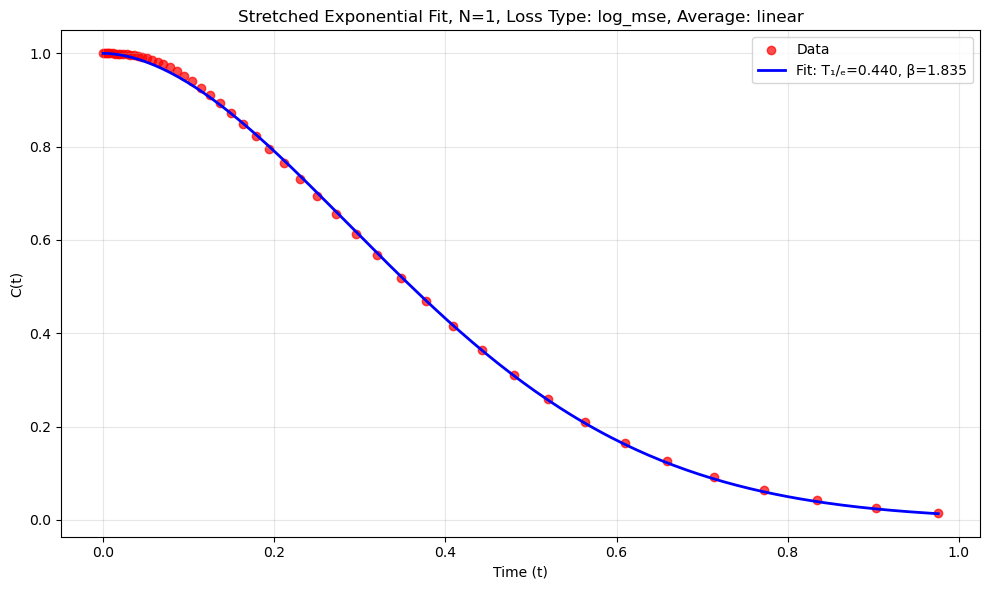

Fitted Parameters:
N = 2
T_1/e = 0.5727 ± 0.0017
β = 1.8457 ± 0.0126
T2 = 0.6207 ± 0.0017
R² = 0.9997
----------------------------------------


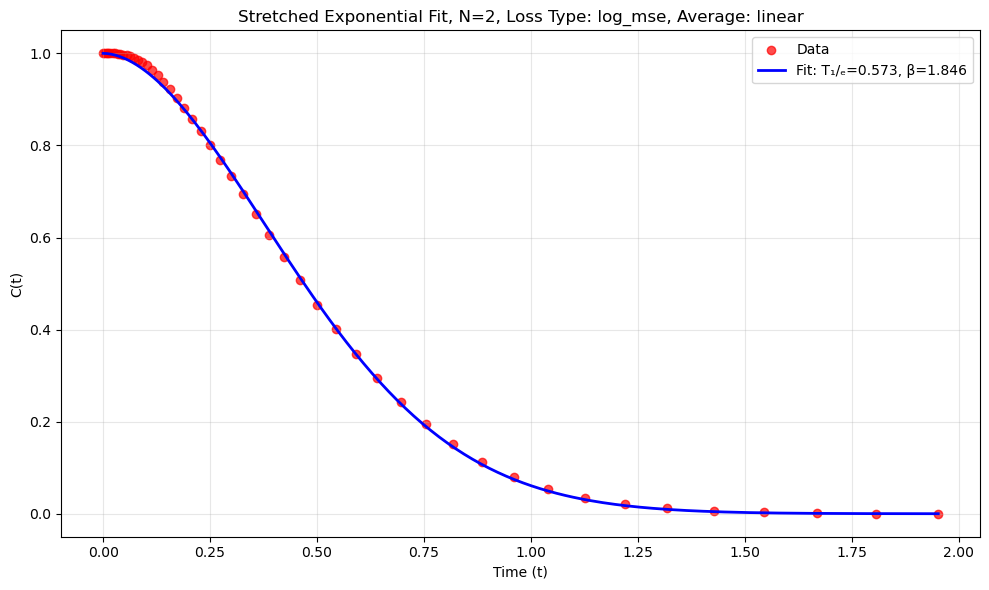

Fitted Parameters:
N = 4
T_1/e = 0.7444 ± 0.0040
β = 1.9002 ± 0.0240
T2 = 0.8404 ± 0.0040
R² = 0.9992
----------------------------------------


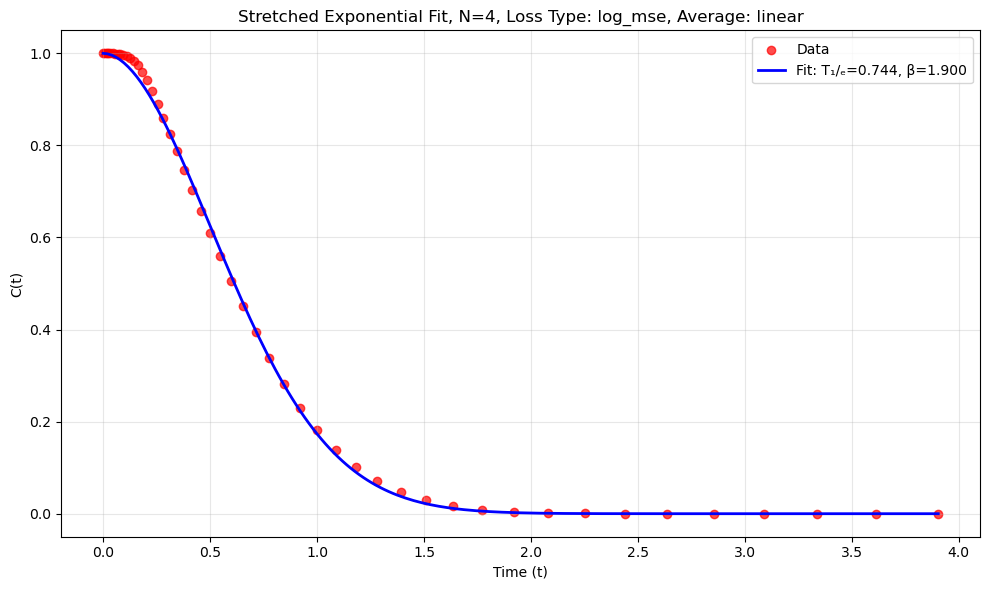

Fitted Parameters:
N = 8
T_1/e = 0.9981 ± 0.0082
β = 2.0724 ± 0.0441
T2 = 1.1901 ± 0.0082
R² = 0.9982
----------------------------------------


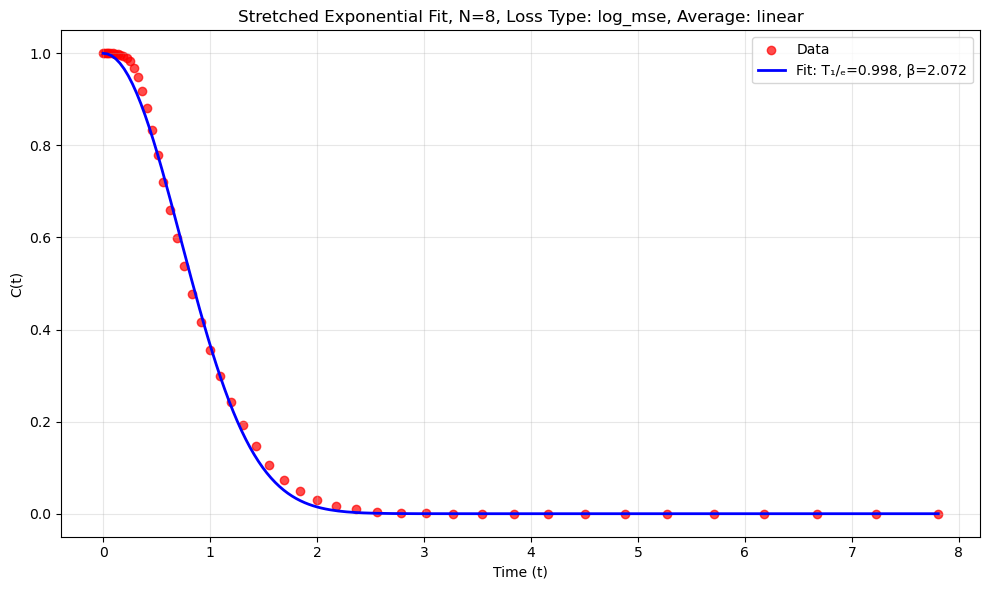

Fitted Parameters:
N = 16
T_1/e = 1.3839 ± 0.0123
β = 2.4939 ± 0.0695
T2 = 1.7679 ± 0.0123
R² = 0.9976
----------------------------------------


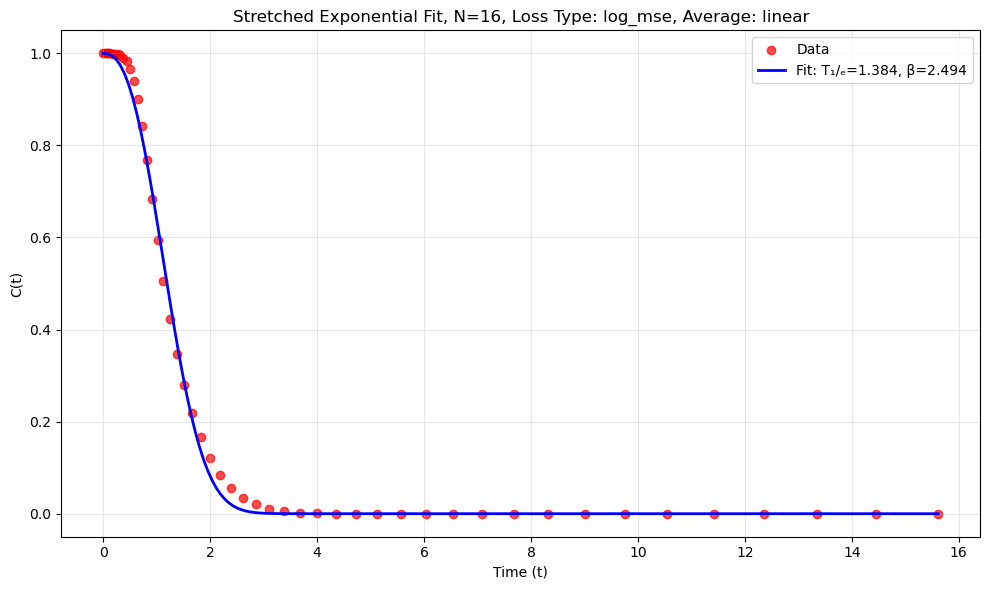

Fitted Parameters:
N = 32
T_1/e = 2.0486 ± 0.0132
β = 3.1954 ± 0.0818
T2 = 2.8166 ± 0.0132
R² = 0.9985
----------------------------------------


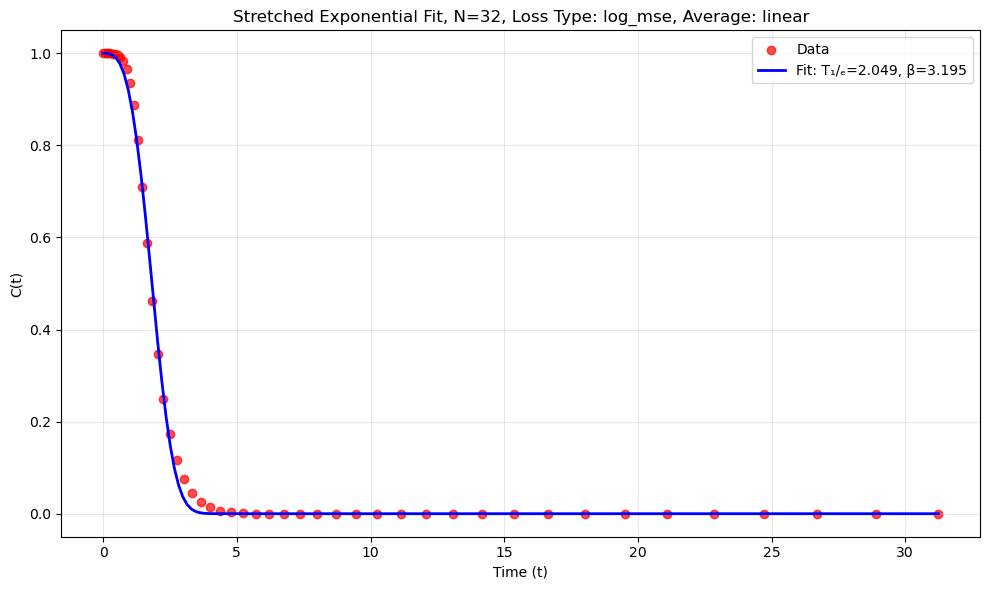

Fitted Parameters:
N = 64
T_1/e = 3.2638 ± 0.0112
β = 3.9116 ± 0.0649
T2 = 4.7998 ± 0.0112
R² = 0.9995
----------------------------------------


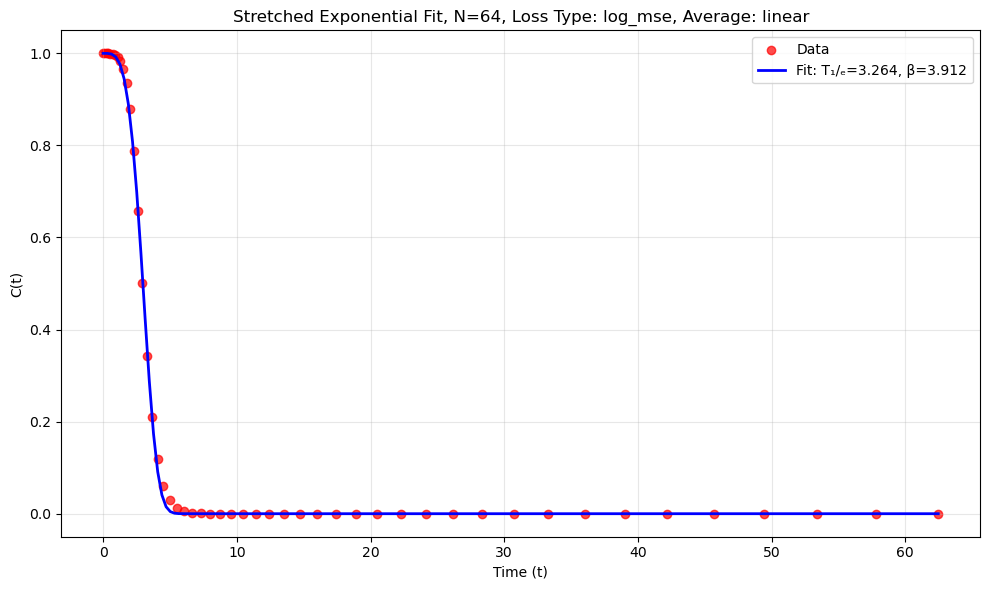

Fitted Parameters:
N = 128
T_1/e = 5.4486 ± 0.0084
β = 4.3979 ± 0.0370
T2 = 8.5206 ± 0.0084
R² = 0.9999
----------------------------------------


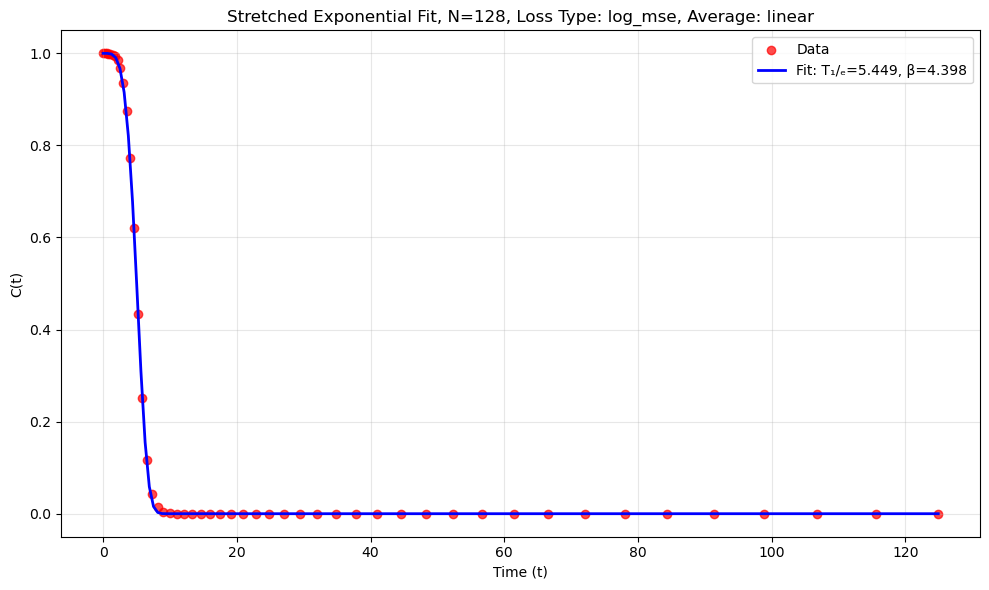

Fitted Parameters:
N = 256
T_1/e = 9.3021 ± 0.0055
β = 4.6416 ± 0.0158
T2 = 15.4461 ± 0.0055
R² = 1.0000
----------------------------------------


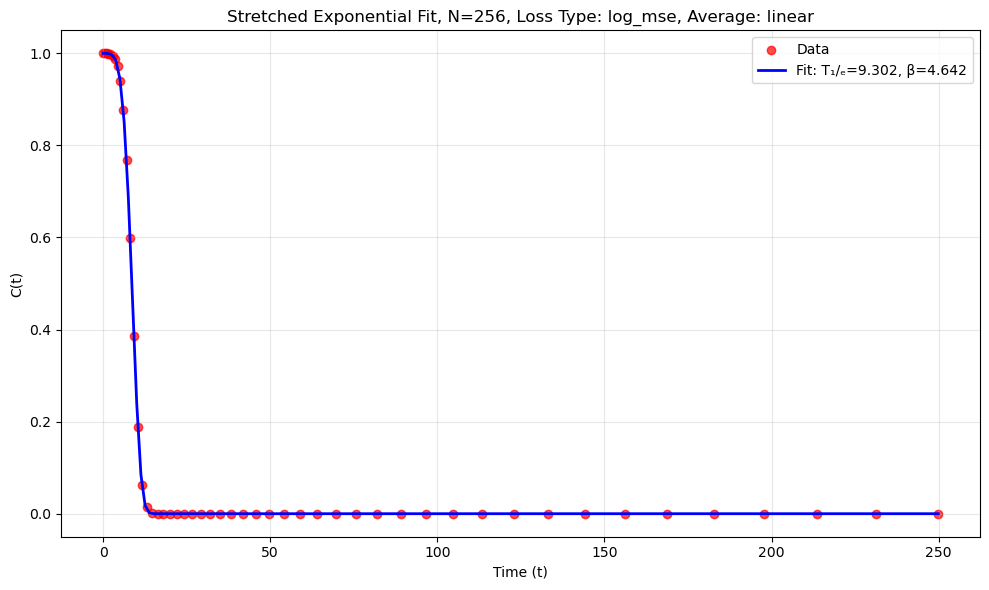

Fitted Parameters:
N = 512
T_1/e = 16.0301 ± 0.0057
β = 4.7107 ± 0.0097
T2 = 28.3181 ± 0.0057
R² = 1.0000
----------------------------------------


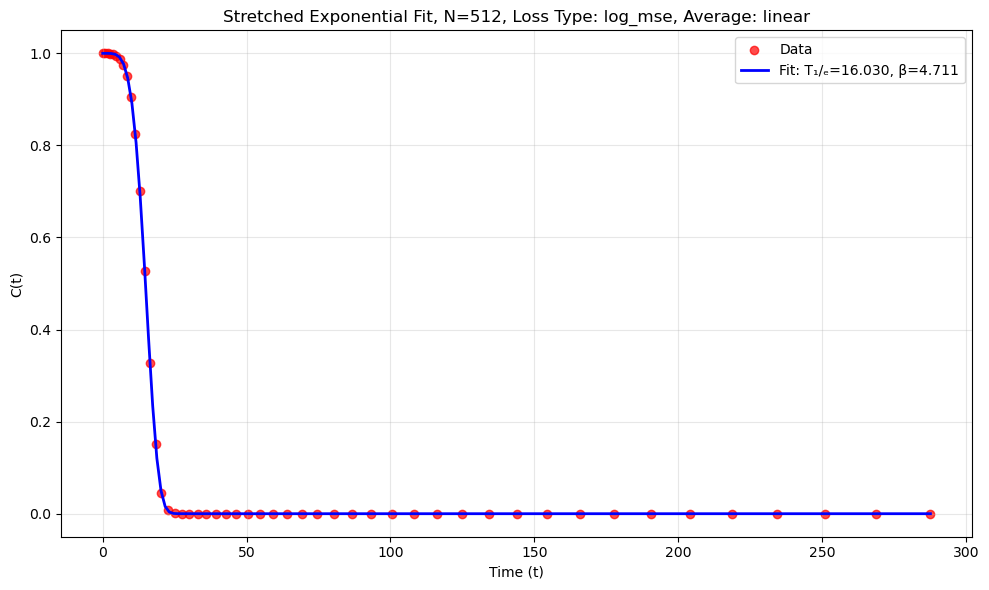

Fitted Parameters:
N = 1024
T_1/e = 27.6938 ± 0.0158
β = 4.6675 ± 0.0155
T2 = 52.2698 ± 0.0158
R² = 1.0000
----------------------------------------


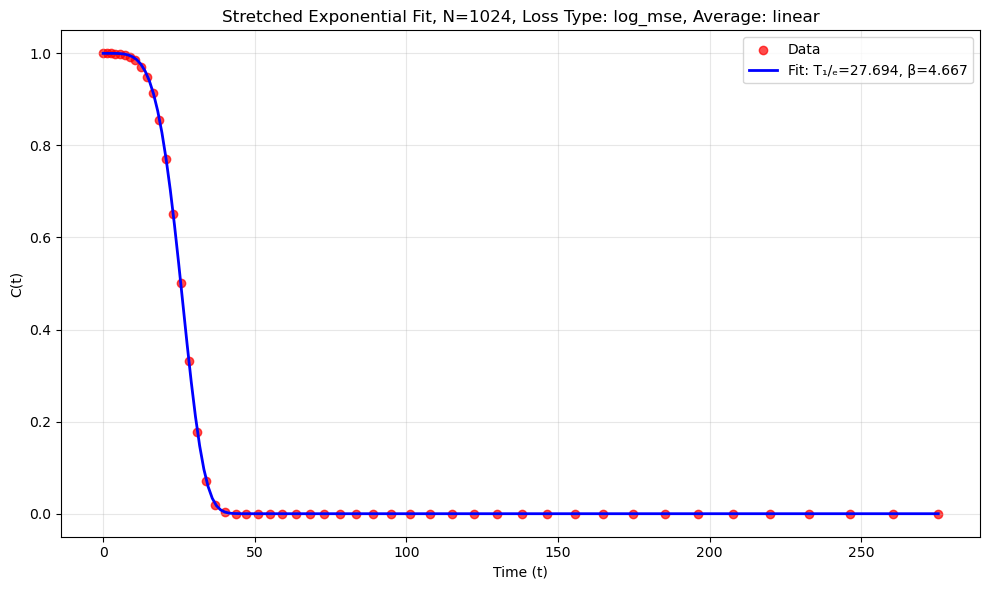

Fitted Parameters:
N = 2048
T_1/e = 47.7622 ± 0.0377
β = 4.5550 ± 0.0205
T2 = 96.9142 ± 0.0377
R² = 1.0000
----------------------------------------


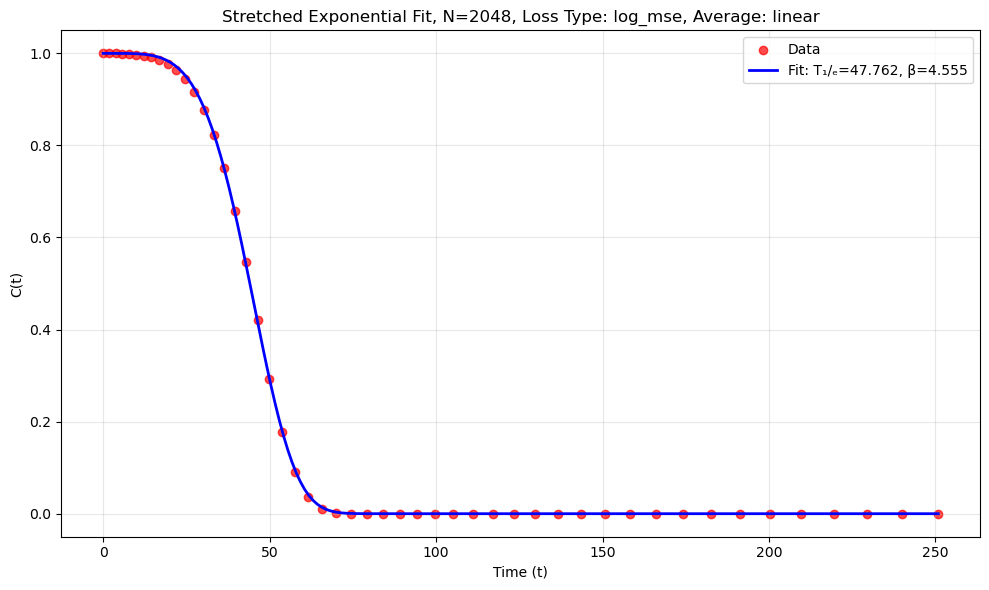

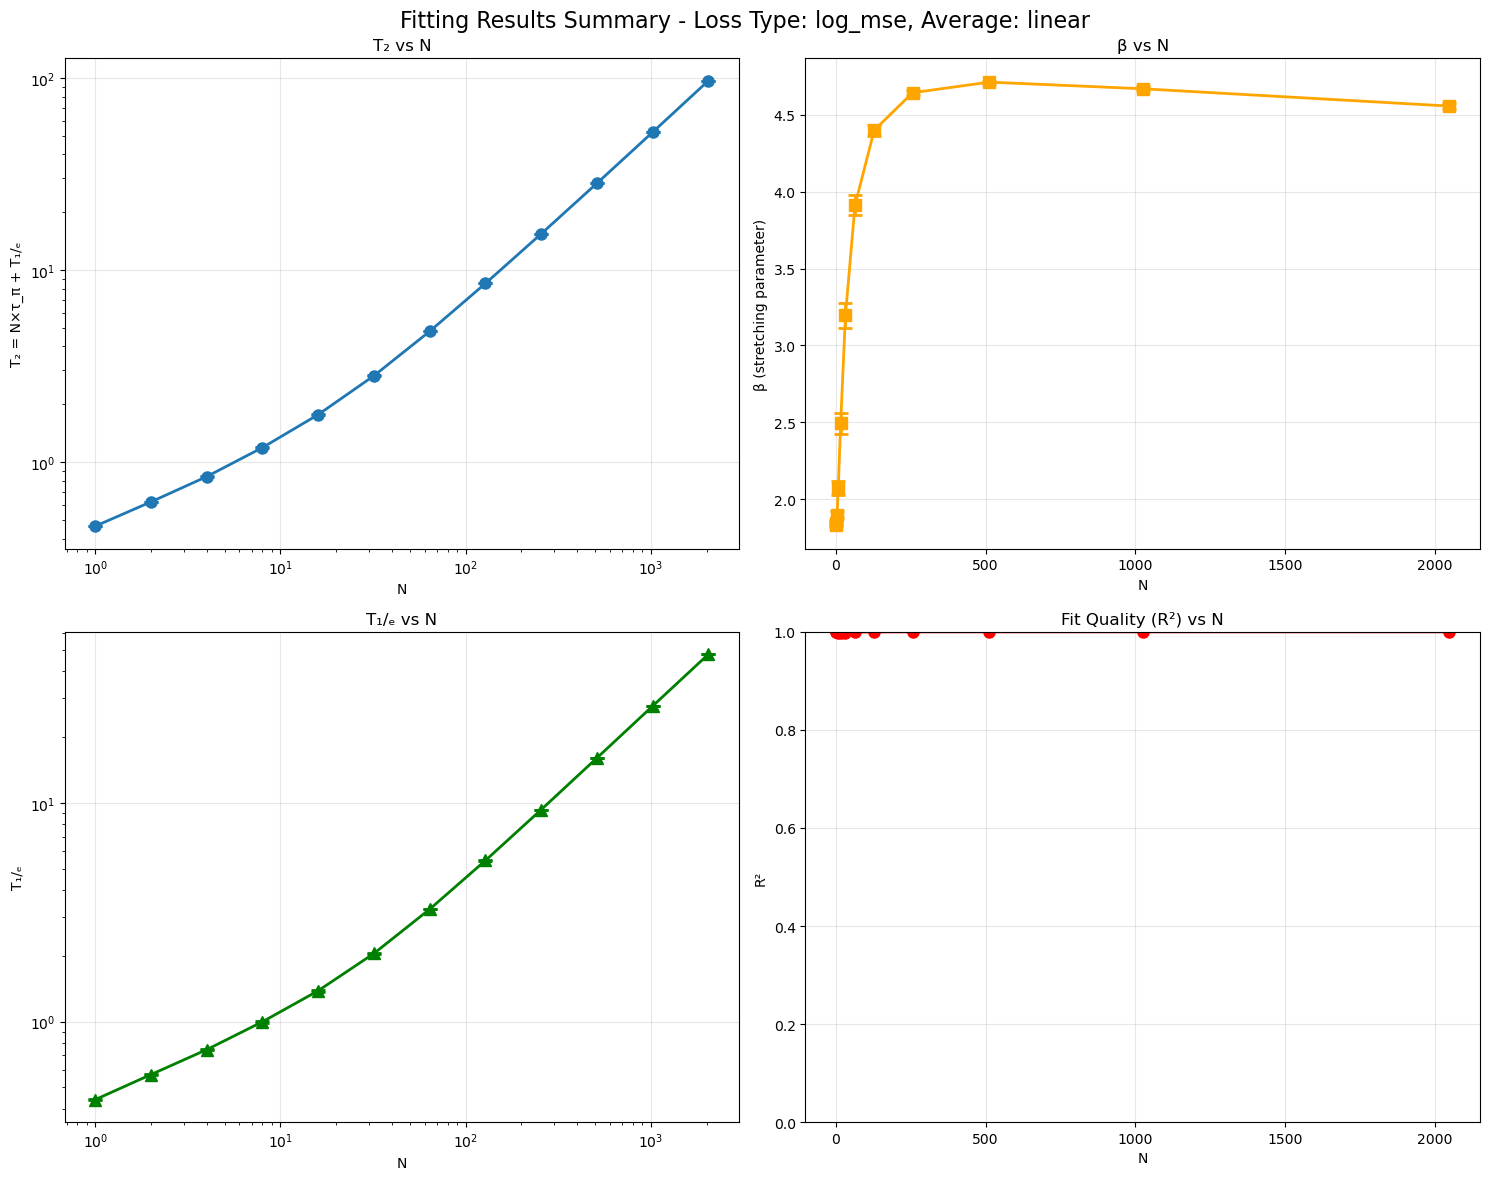


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.464 to 96.914
β range: 1.835 to 4.711
Average R²: 0.999 ± 0.001
Fitted Parameters:
N = 1
T_1/e = 0.4405 ± 0.0013
β = 1.8058 ± 0.0117
T2 = 0.4645 ± 0.0013
R² = 0.9996
----------------------------------------


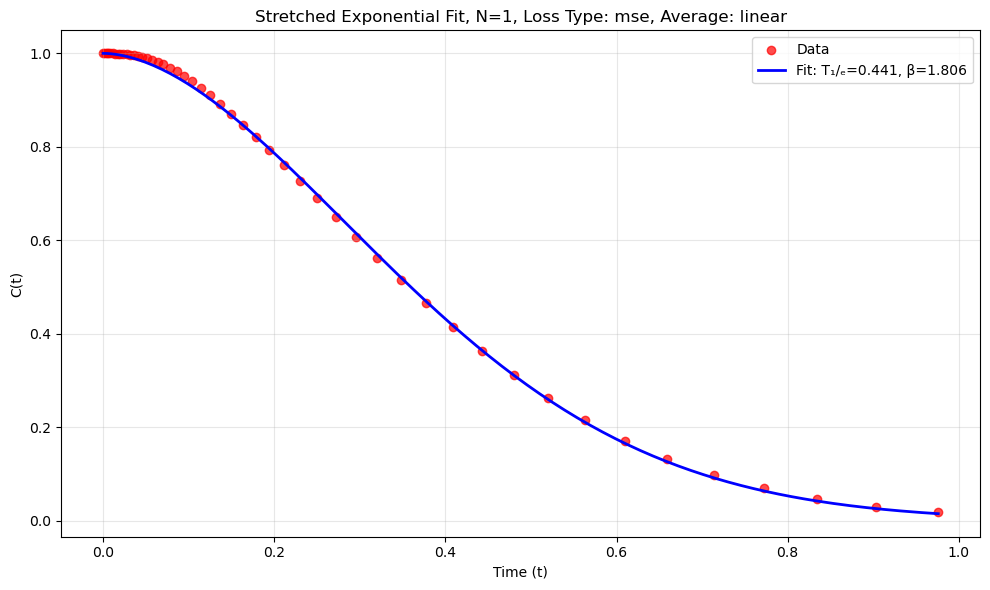

Fitted Parameters:
N = 2
T_1/e = 0.5679 ± 0.0020
β = 1.8287 ± 0.0146
T2 = 0.6159 ± 0.0020
R² = 0.9996
----------------------------------------


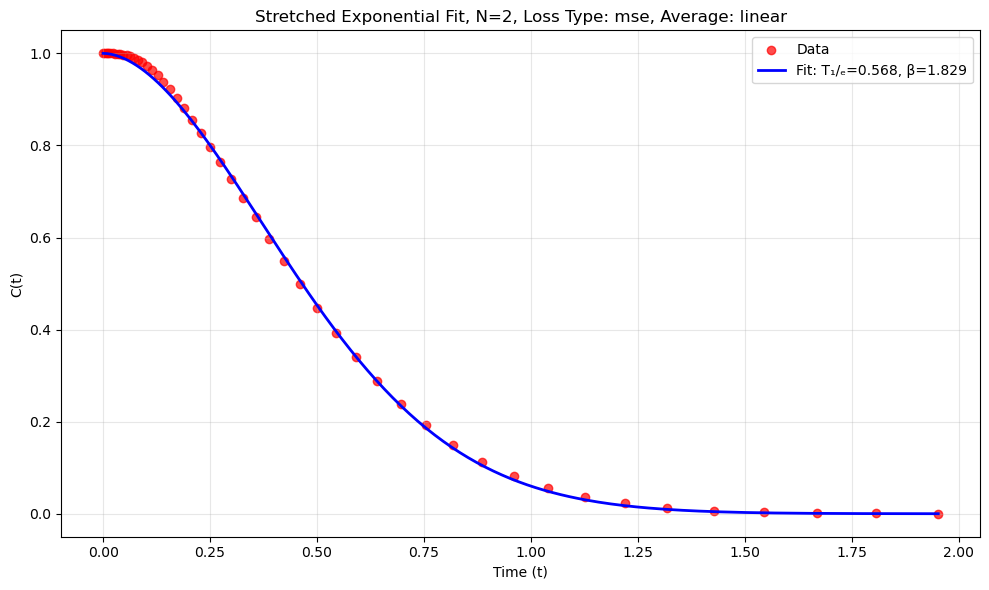

Fitted Parameters:
N = 4
T_1/e = 0.7333 ± 0.0042
β = 1.9108 ± 0.0261
T2 = 0.8293 ± 0.0042
R² = 0.9991
----------------------------------------


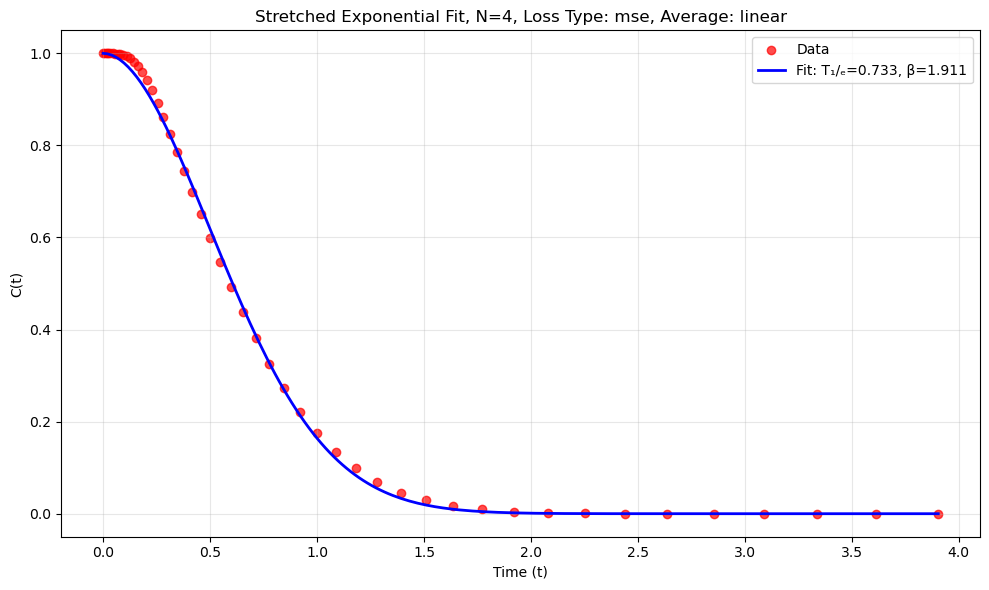

Fitted Parameters:
N = 8
T_1/e = 0.9839 ± 0.0075
β = 2.1229 ± 0.0432
T2 = 1.1759 ± 0.0075
R² = 0.9984
----------------------------------------


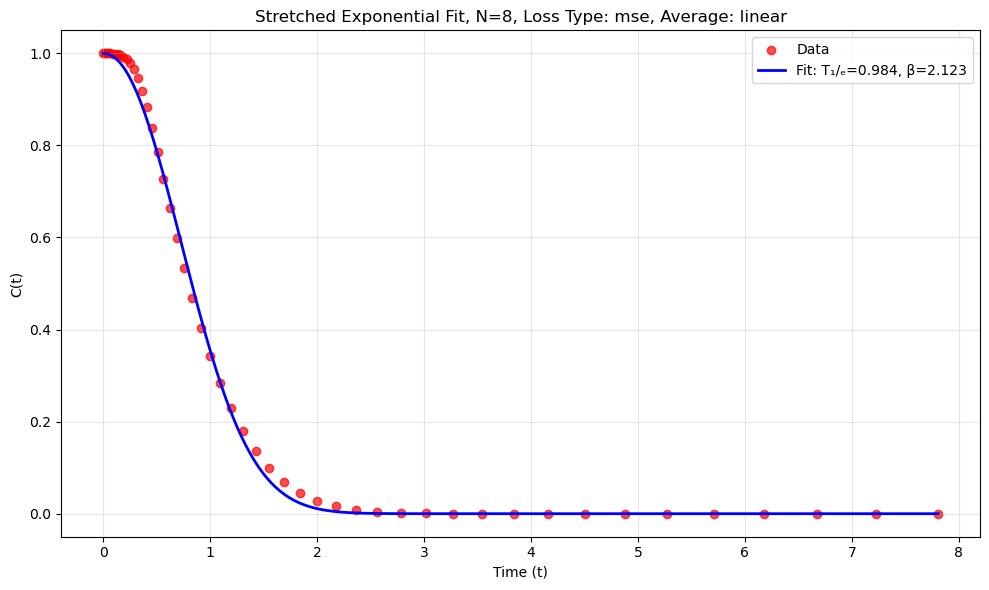

Fitted Parameters:
N = 16
T_1/e = 1.3797 ± 0.0100
β = 2.5400 ± 0.0584
T2 = 1.7637 ± 0.0100
R² = 0.9984
----------------------------------------


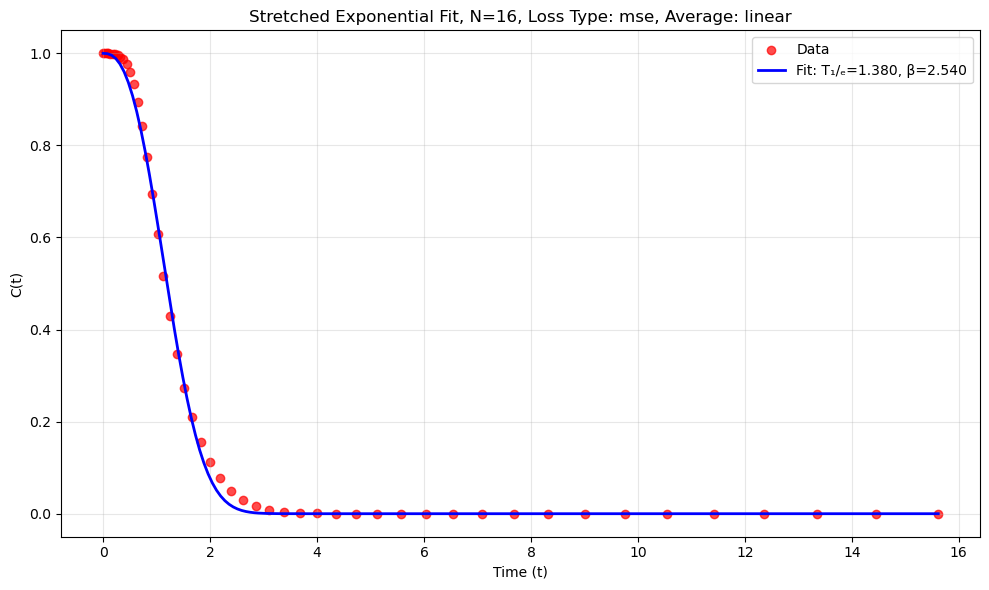

Fitted Parameters:
N = 32
T_1/e = 2.0652 ± 0.0099
β = 3.0862 ± 0.0573
T2 = 2.8332 ± 0.0099
R² = 0.9992
----------------------------------------


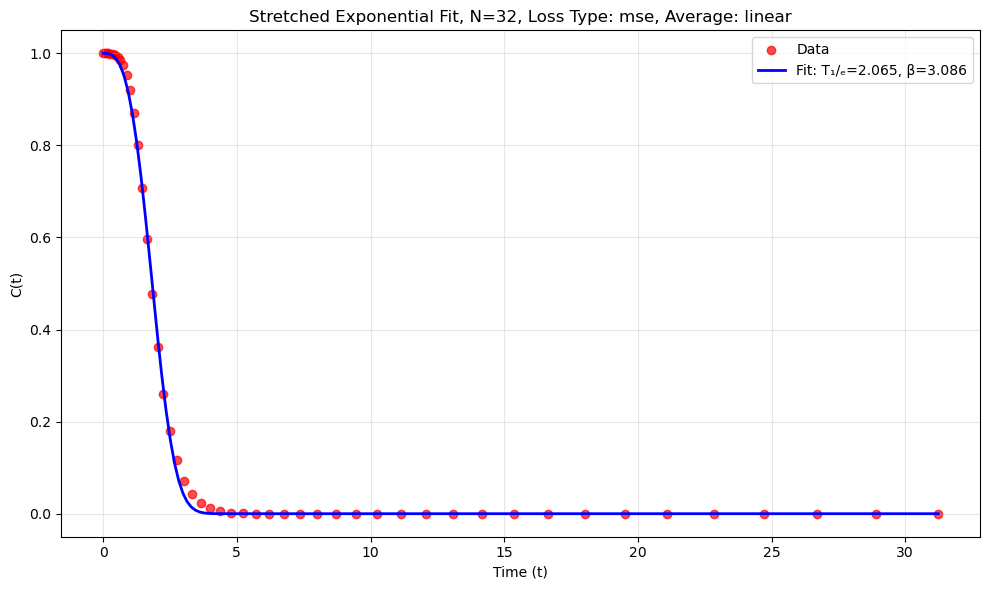

Fitted Parameters:
N = 64
T_1/e = 3.2759 ± 0.0083
β = 3.5546 ± 0.0400
T2 = 4.8119 ± 0.0083
R² = 0.9997
----------------------------------------


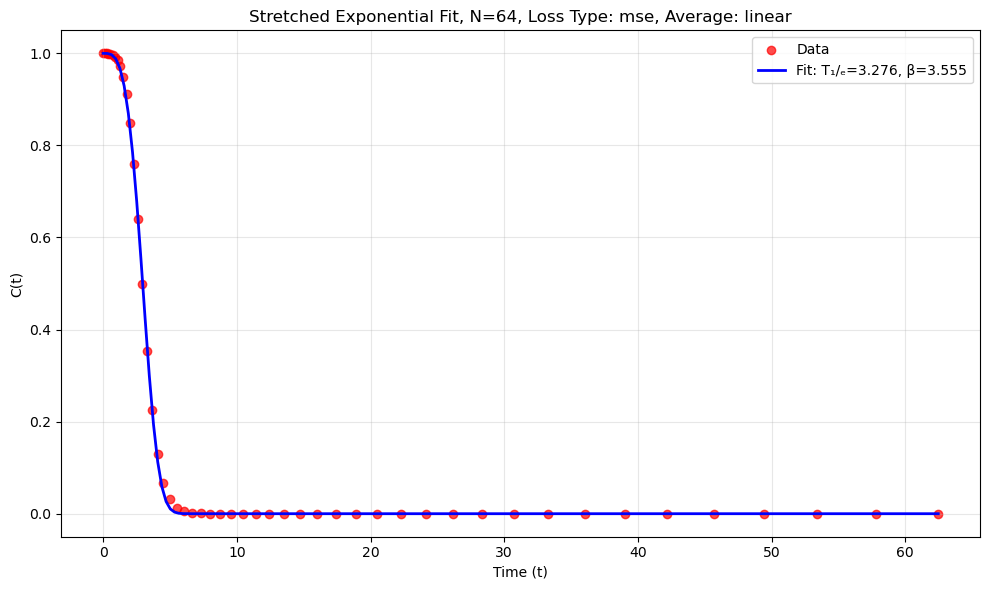

Fitted Parameters:
N = 128
T_1/e = 5.3789 ± 0.0061
β = 3.8426 ± 0.0208
T2 = 8.4509 ± 0.0061
R² = 0.9999
----------------------------------------


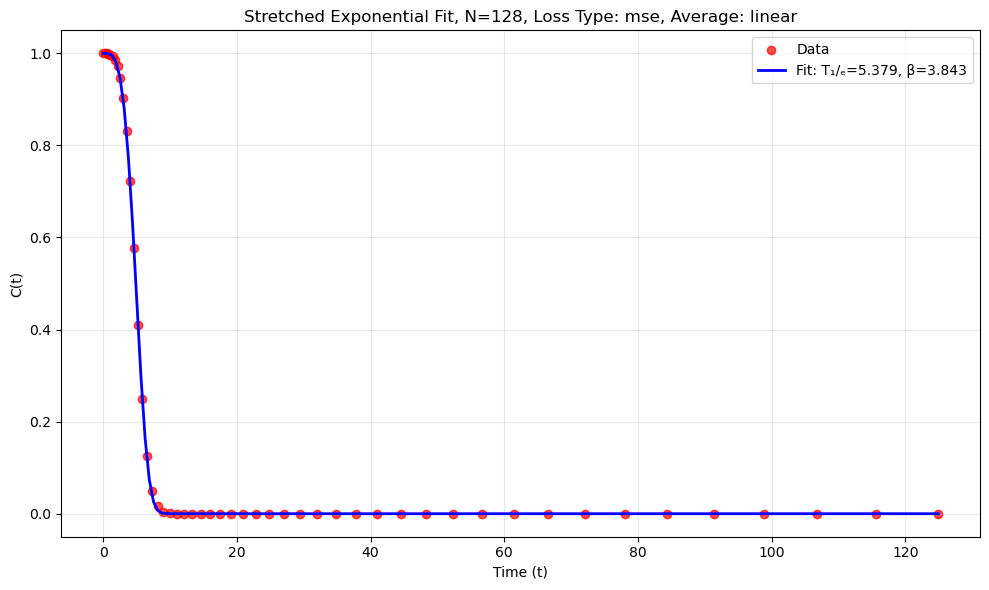

Fitted Parameters:
N = 256
T_1/e = 8.9805 ± 0.0039
β = 3.9671 ± 0.0087
T2 = 15.1245 ± 0.0039
R² = 1.0000
----------------------------------------


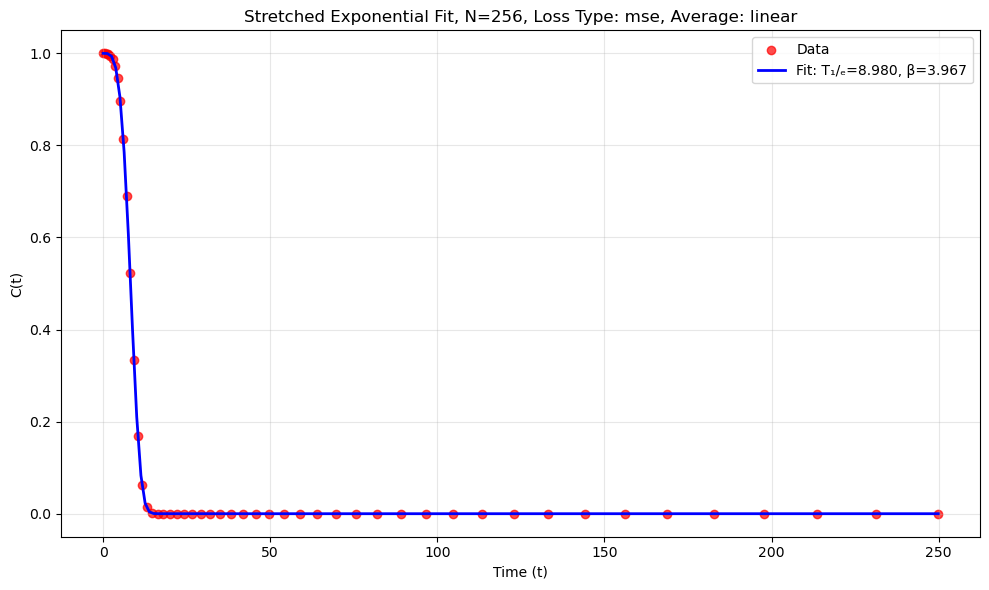

Fitted Parameters:
N = 512
T_1/e = 15.0911 ± 0.0077
β = 3.9755 ± 0.0101
T2 = 27.3791 ± 0.0077
R² = 1.0000
----------------------------------------


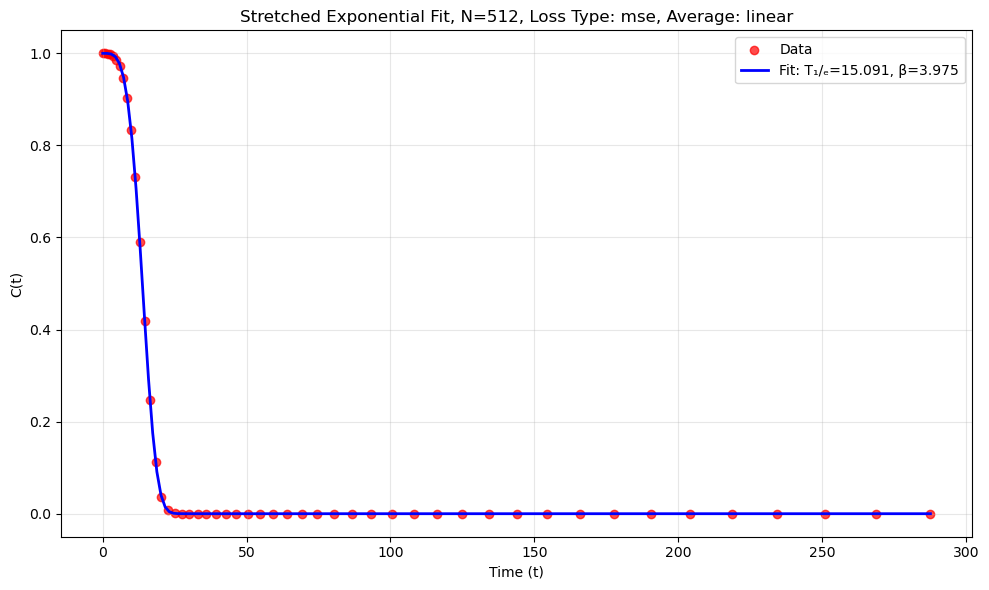

Fitted Parameters:
N = 1024
T_1/e = 25.3739 ± 0.0198
β = 3.9082 ± 0.0151
T2 = 49.9499 ± 0.0198
R² = 1.0000
----------------------------------------


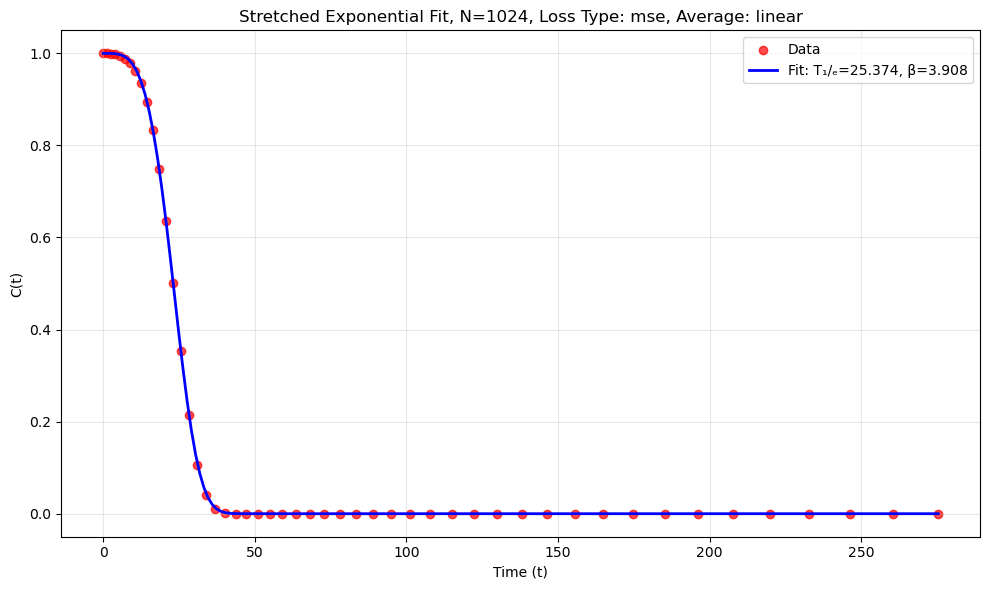

Fitted Parameters:
N = 2048
T_1/e = 42.5139 ± 0.0431
β = 3.7941 ± 0.0186
T2 = 91.6659 ± 0.0431
R² = 0.9999
----------------------------------------


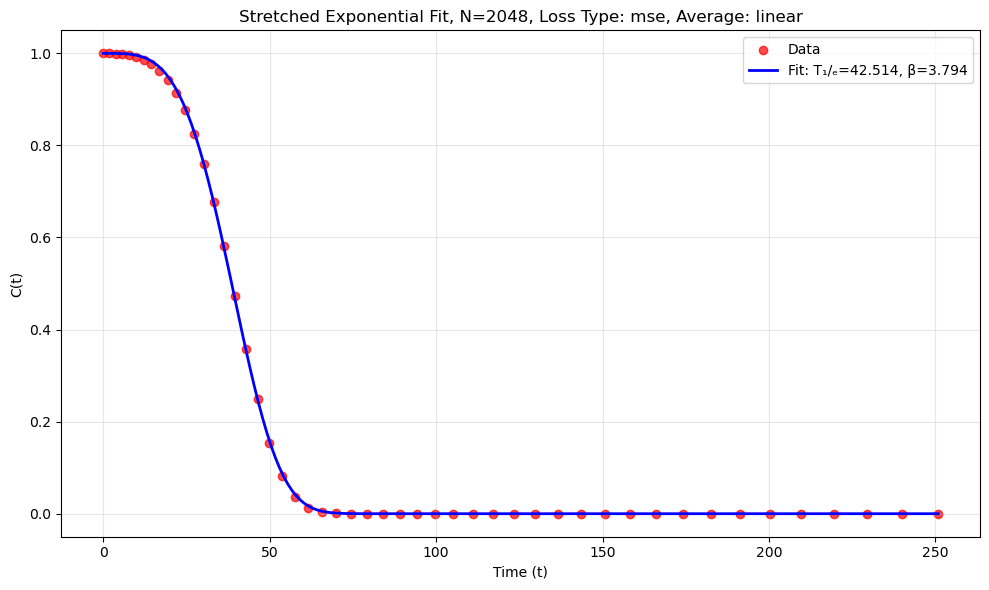

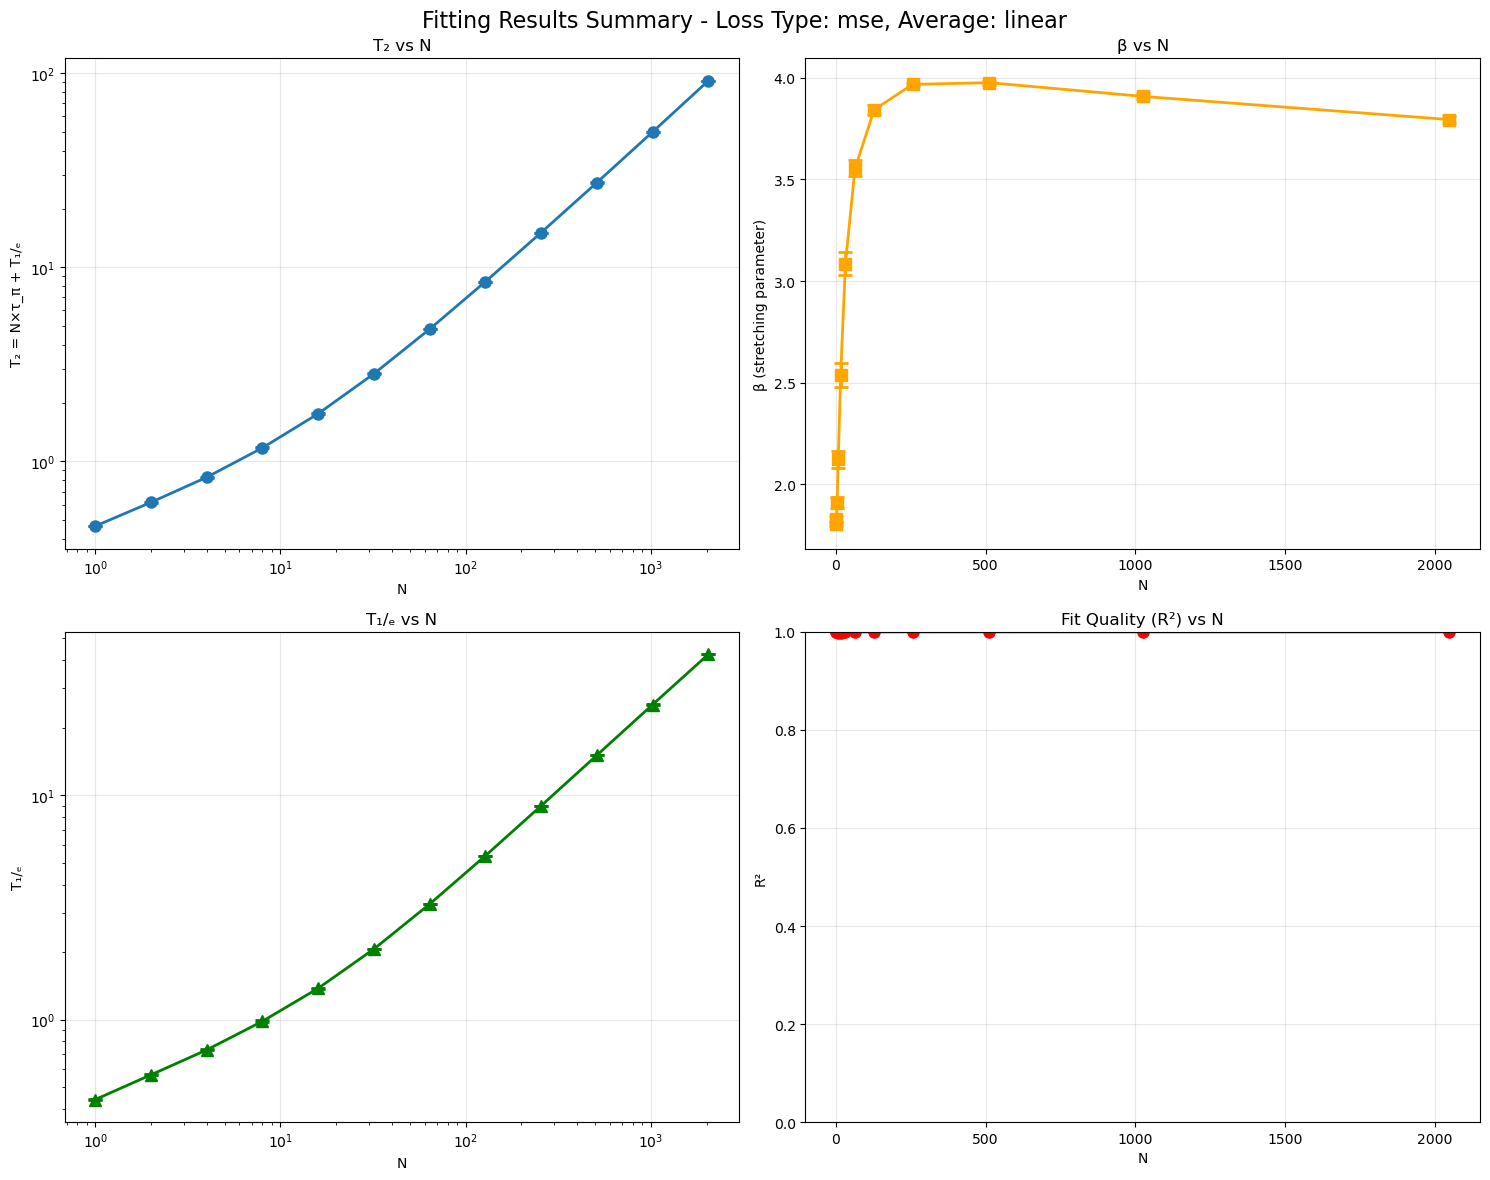


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.465 to 91.666
β range: 1.806 to 3.975
Average R²: 0.999 ± 0.001
Fitted Parameters:
N = 1
T_1/e = 0.4417 ± 0.0013
β = 1.8209 ± 0.0116
T2 = 0.4657 ± 0.0013
R² = 0.9996
----------------------------------------


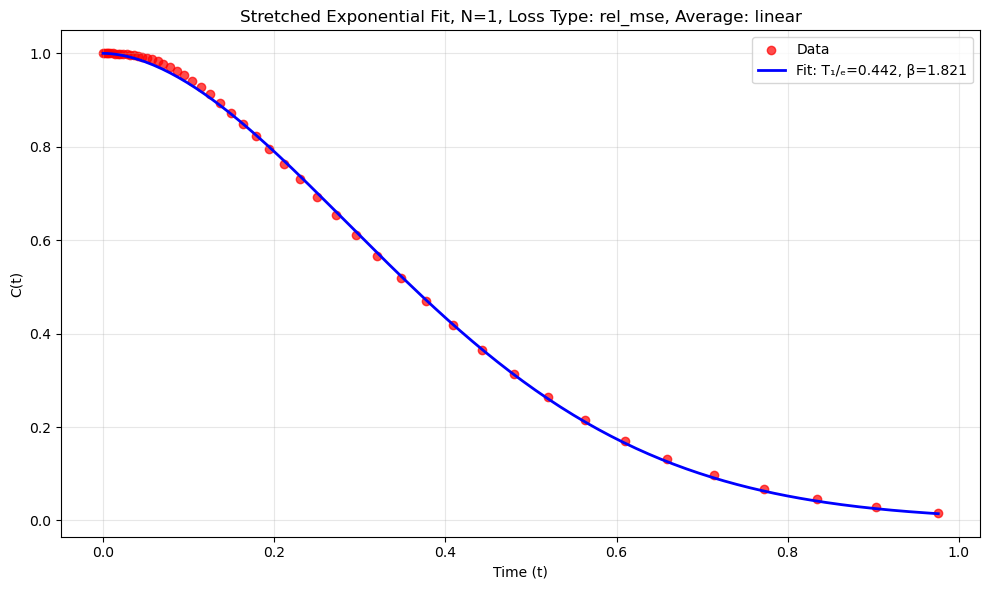

Fitted Parameters:
N = 2
T_1/e = 0.5719 ± 0.0020
β = 1.8408 ± 0.0146
T2 = 0.6199 ± 0.0020
R² = 0.9996
----------------------------------------


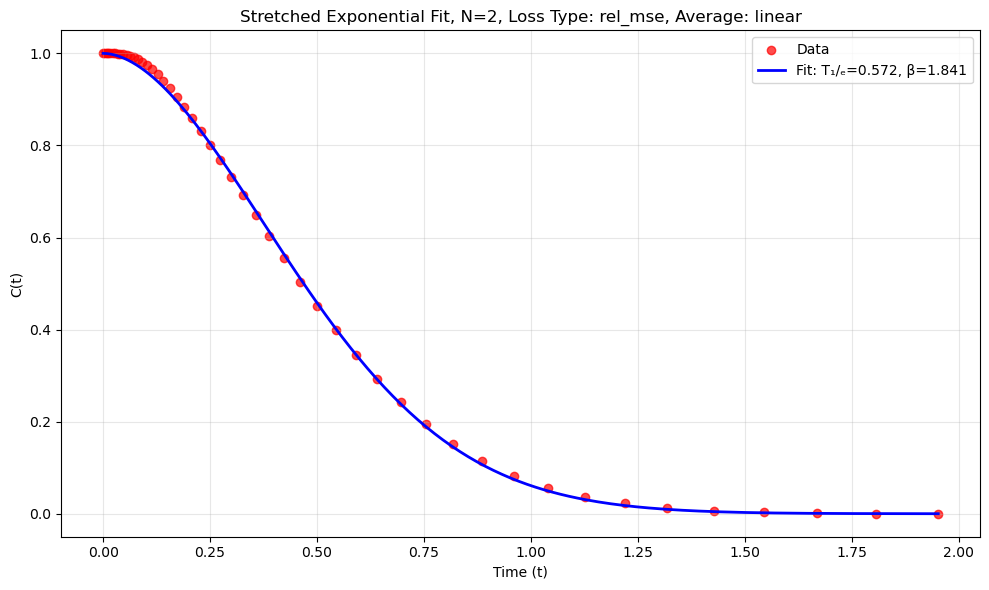

Fitted Parameters:
N = 4
T_1/e = 0.7407 ± 0.0044
β = 1.9173 ± 0.0271
T2 = 0.8367 ± 0.0044
R² = 0.9990
----------------------------------------


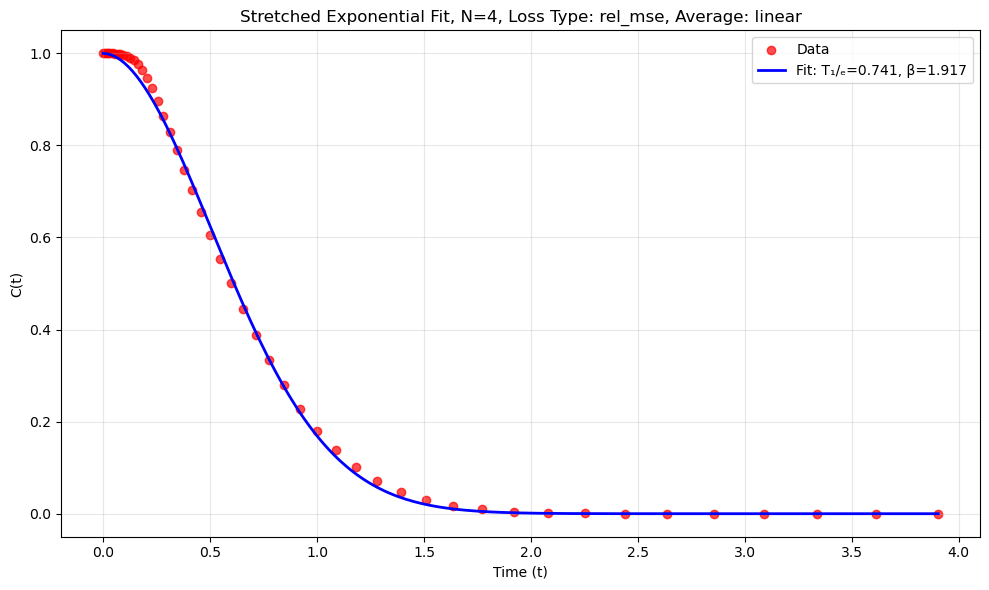

Fitted Parameters:
N = 8
T_1/e = 0.9941 ± 0.0083
β = 2.1319 ± 0.0474
T2 = 1.1861 ± 0.0083
R² = 0.9981
----------------------------------------


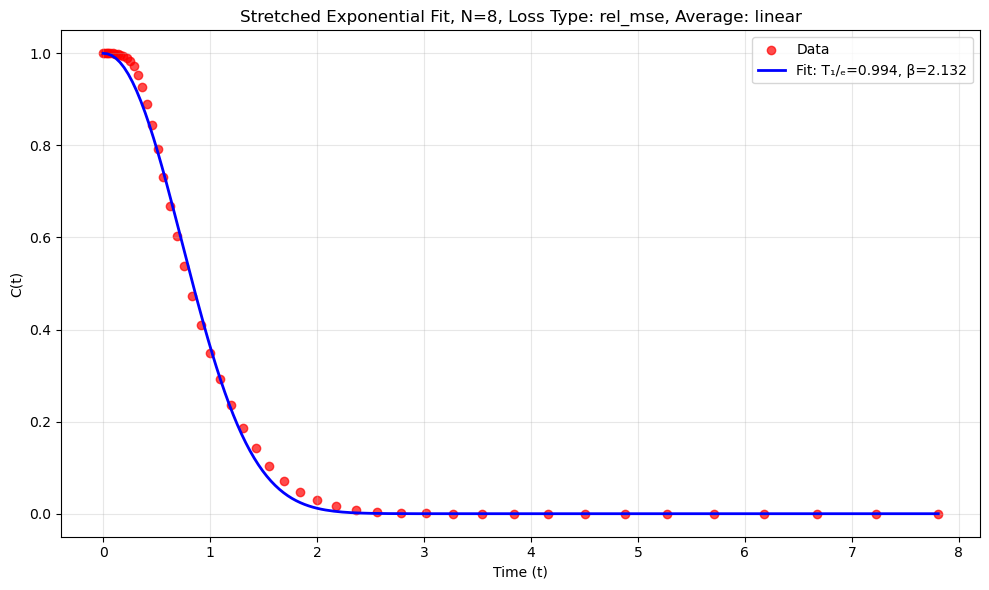

Fitted Parameters:
N = 16
T_1/e = 1.3920 ± 0.0113
β = 2.5977 ± 0.0686
T2 = 1.7760 ± 0.0113
R² = 0.9979
----------------------------------------


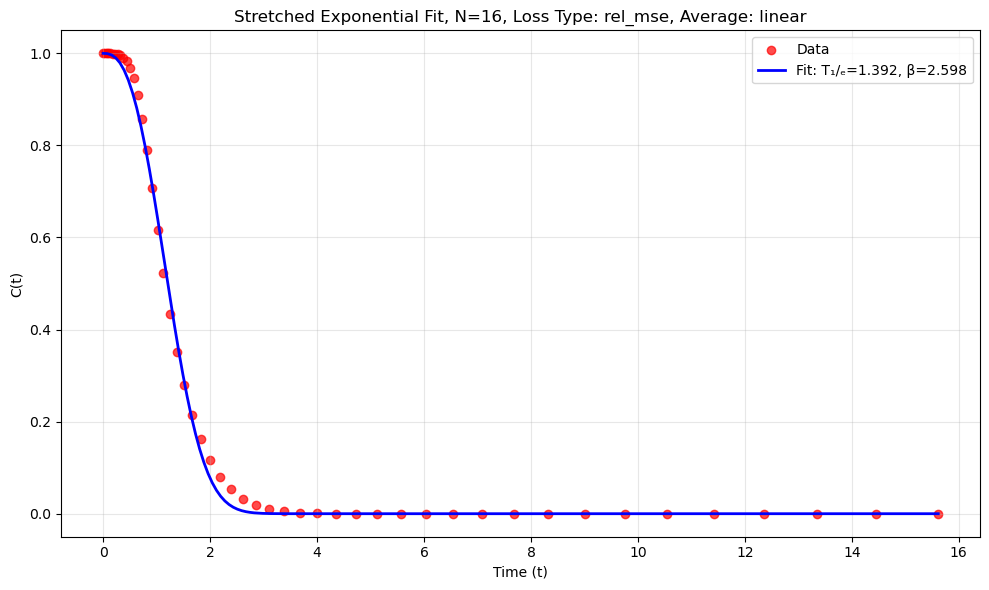

Fitted Parameters:
N = 32
T_1/e = 2.0907 ± 0.0113
β = 3.2648 ± 0.0717
T2 = 2.8587 ± 0.0113
R² = 0.9989
----------------------------------------


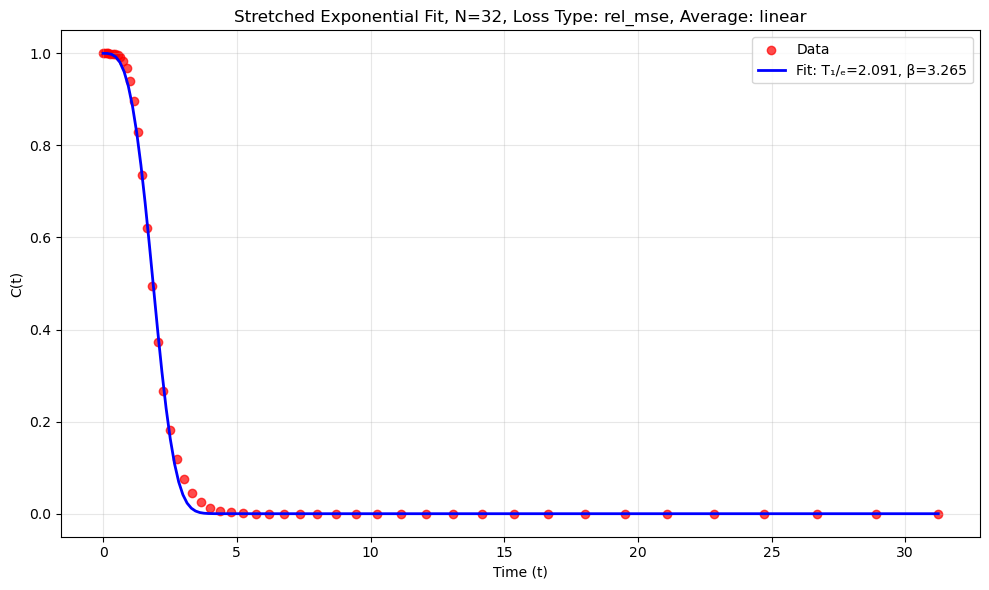

Fitted Parameters:
N = 64
T_1/e = 3.3539 ± 0.0094
β = 3.8640 ± 0.0517
T2 = 4.8899 ± 0.0094
R² = 0.9997
----------------------------------------


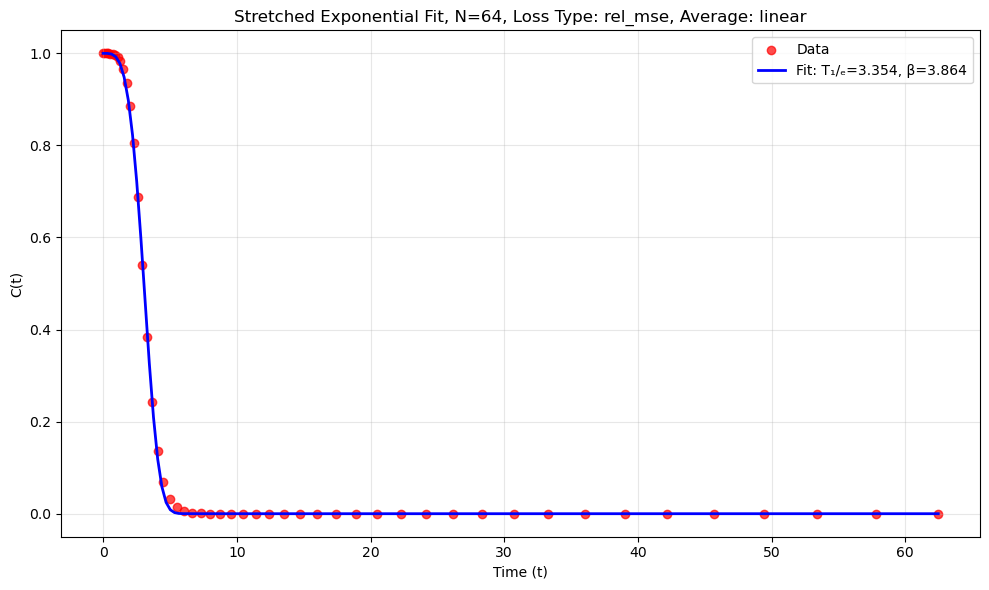

Fitted Parameters:
N = 128
T_1/e = 5.5918 ± 0.0069
β = 4.2409 ± 0.0276
T2 = 8.6638 ± 0.0069
R² = 0.9999
----------------------------------------


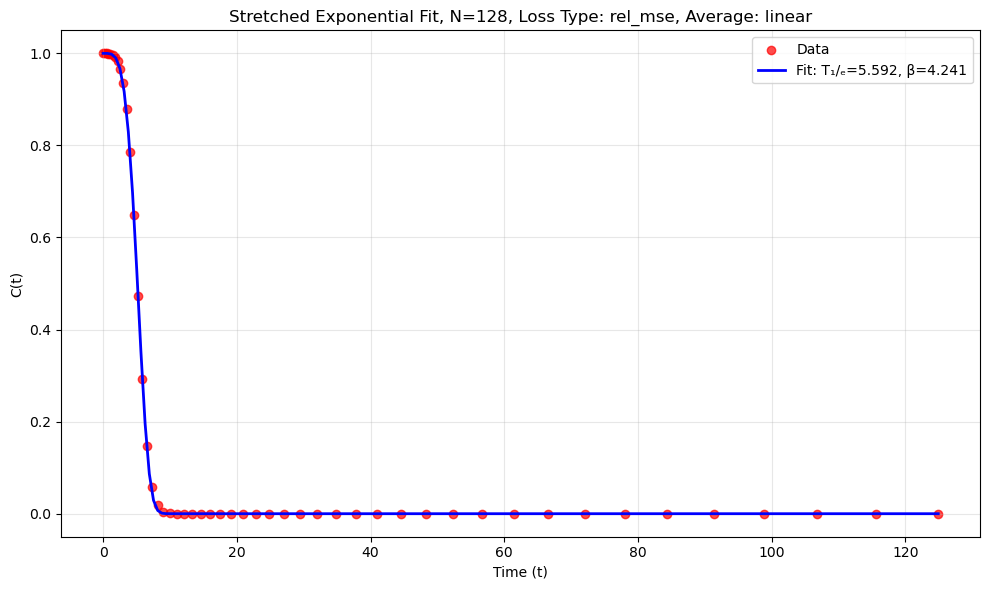

Fitted Parameters:
N = 256
T_1/e = 9.4944 ± 0.0044
β = 4.4139 ± 0.0112
T2 = 15.6384 ± 0.0044
R² = 1.0000
----------------------------------------


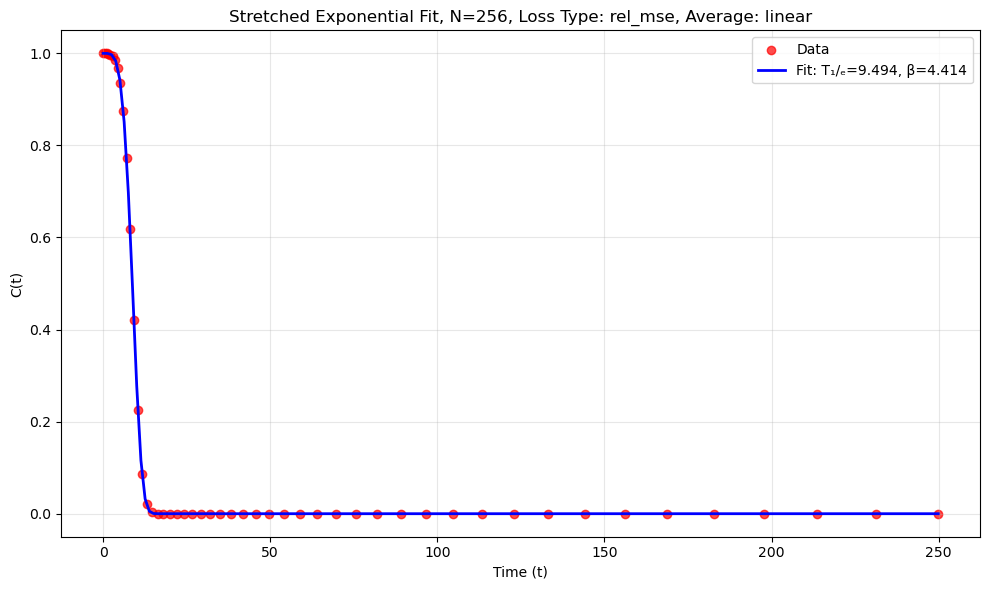

Fitted Parameters:
N = 512
T_1/e = 16.2384 ± 0.0067
β = 4.4442 ± 0.0102
T2 = 28.5264 ± 0.0067
R² = 1.0000
----------------------------------------


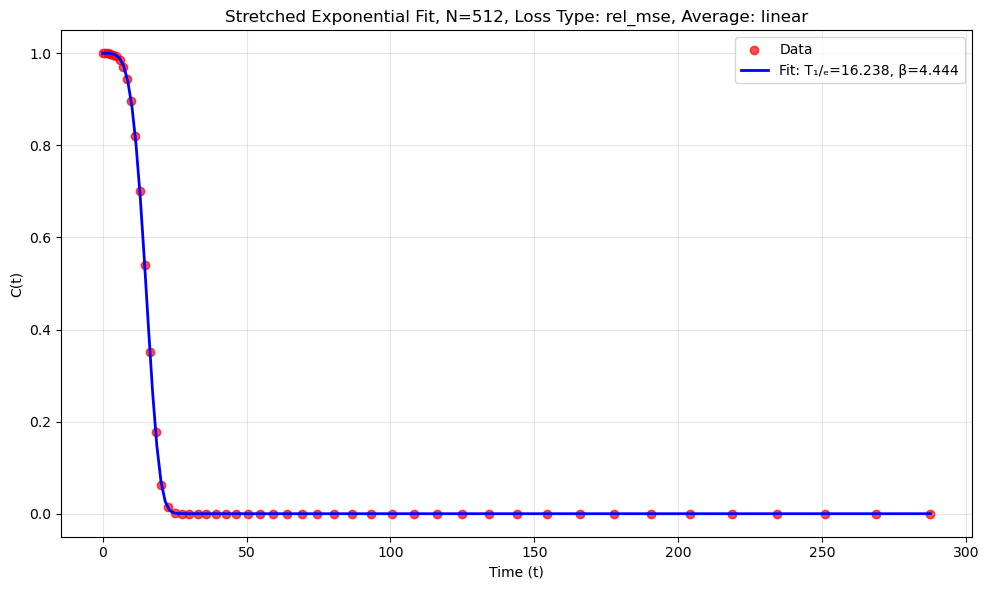

Fitted Parameters:
N = 1024
T_1/e = 27.8094 ± 0.0184
β = 4.3830 ± 0.0159
T2 = 52.3854 ± 0.0184
R² = 1.0000
----------------------------------------


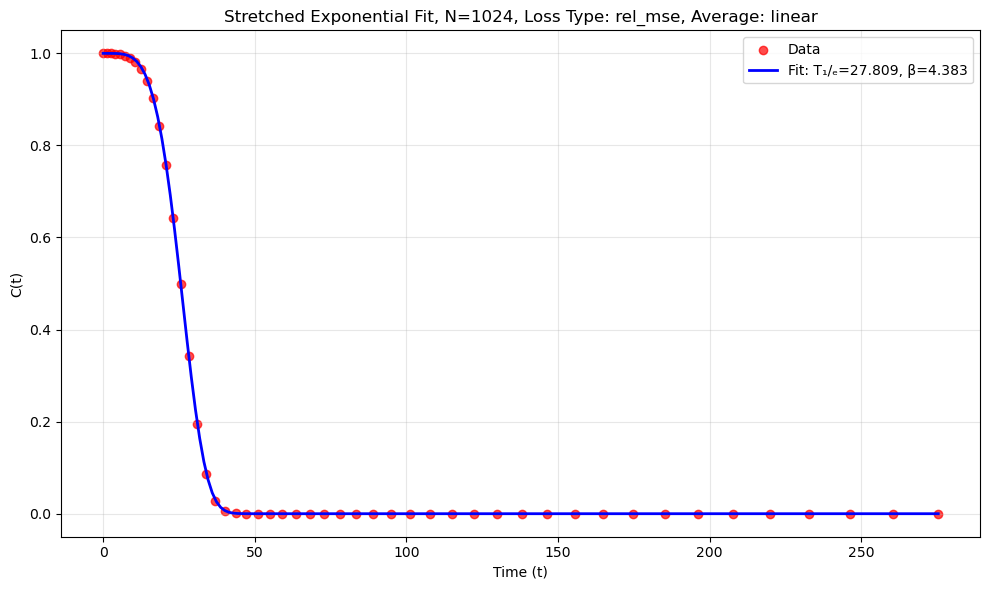

Fitted Parameters:
N = 2048
T_1/e = 47.5017 ± 0.0417
β = 4.2650 ± 0.0201
T2 = 96.6537 ± 0.0417
R² = 0.9999
----------------------------------------


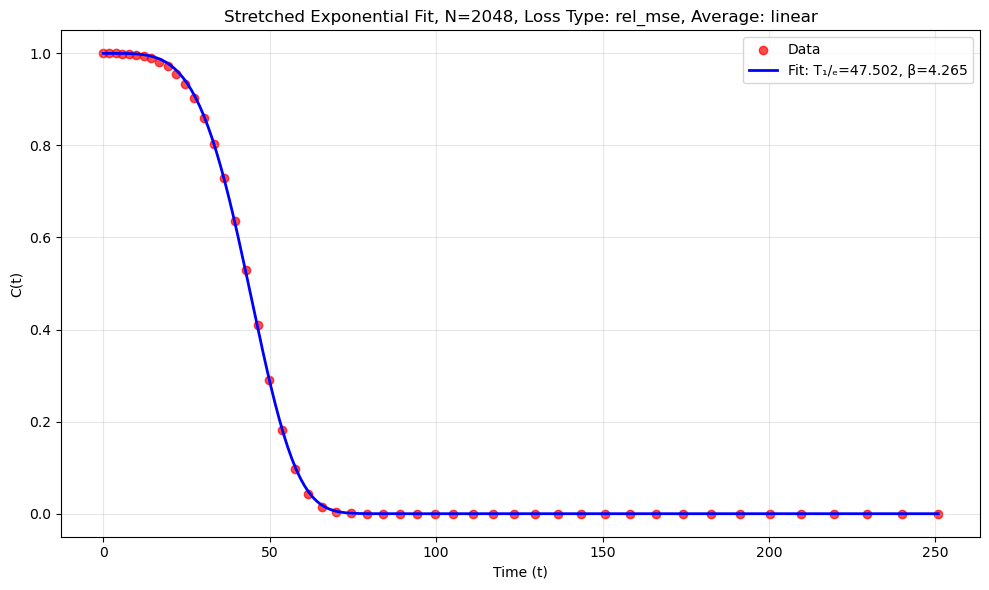

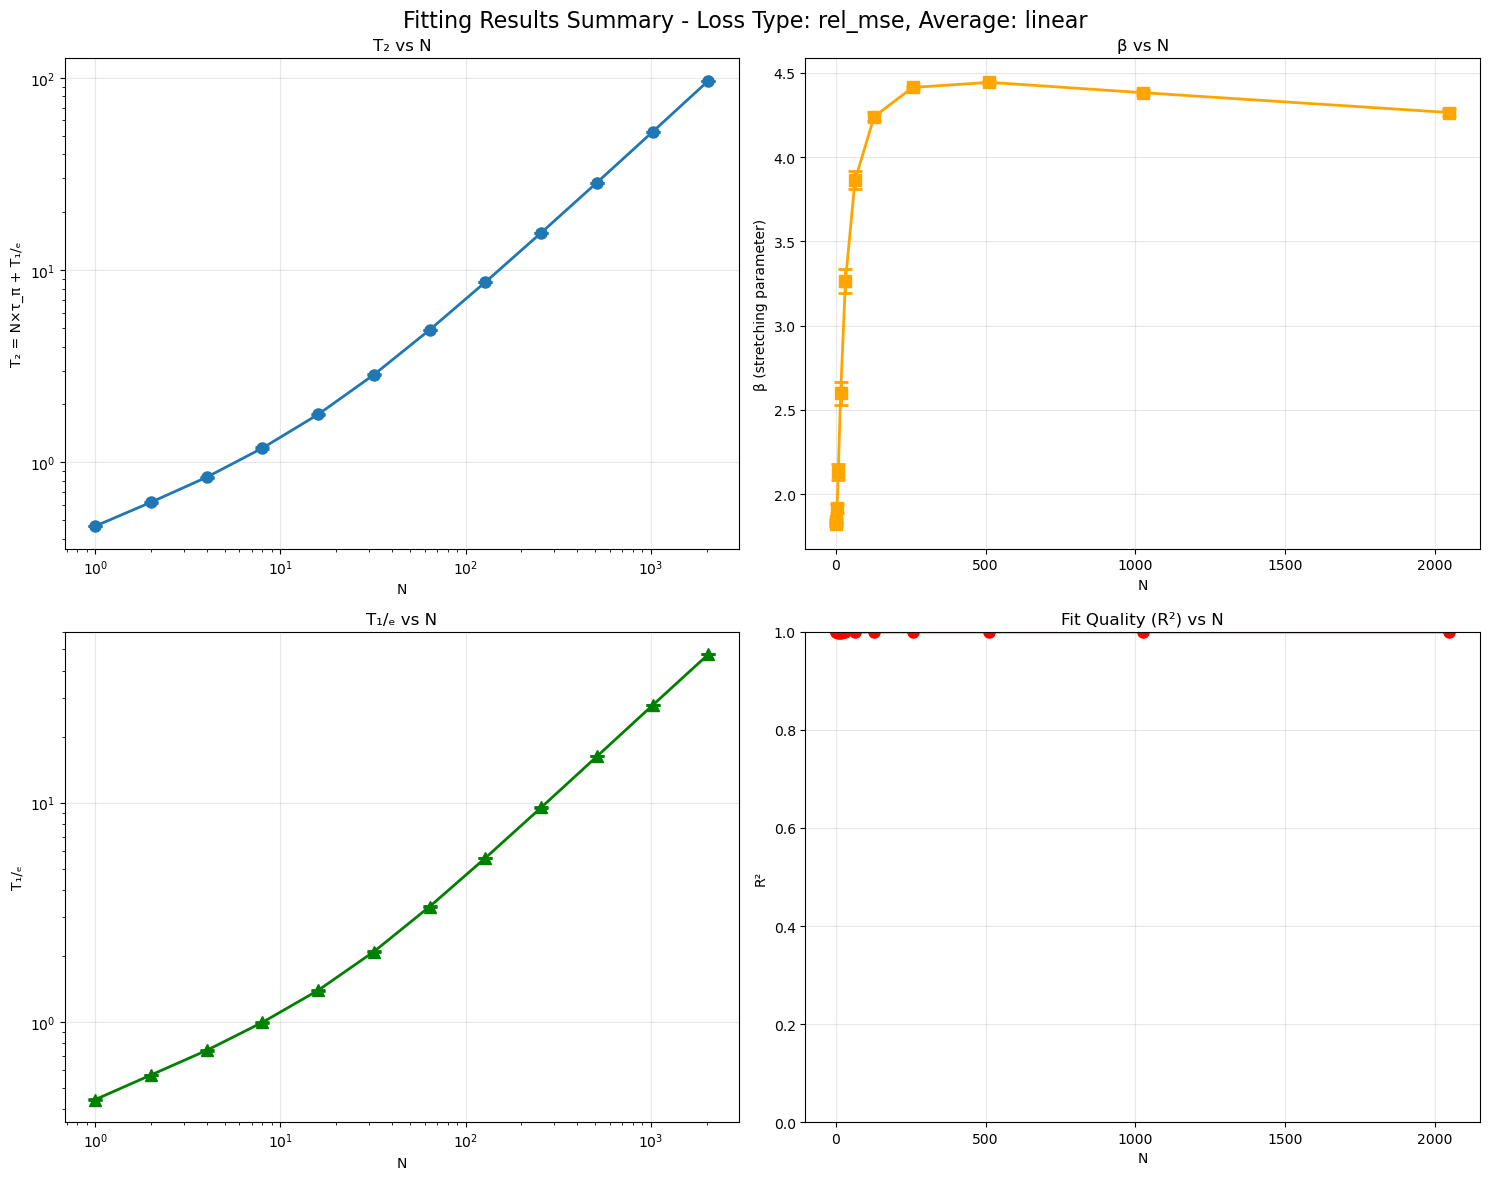


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.466 to 96.654
β range: 1.821 to 4.444
Average R²: 0.999 ± 0.001
Fitted Parameters:
N = 1
T_1/e = 0.4419 ± 0.0013
β = 1.8371 ± 0.0123
T2 = 0.4659 ± 0.0013
R² = 0.9996
----------------------------------------


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

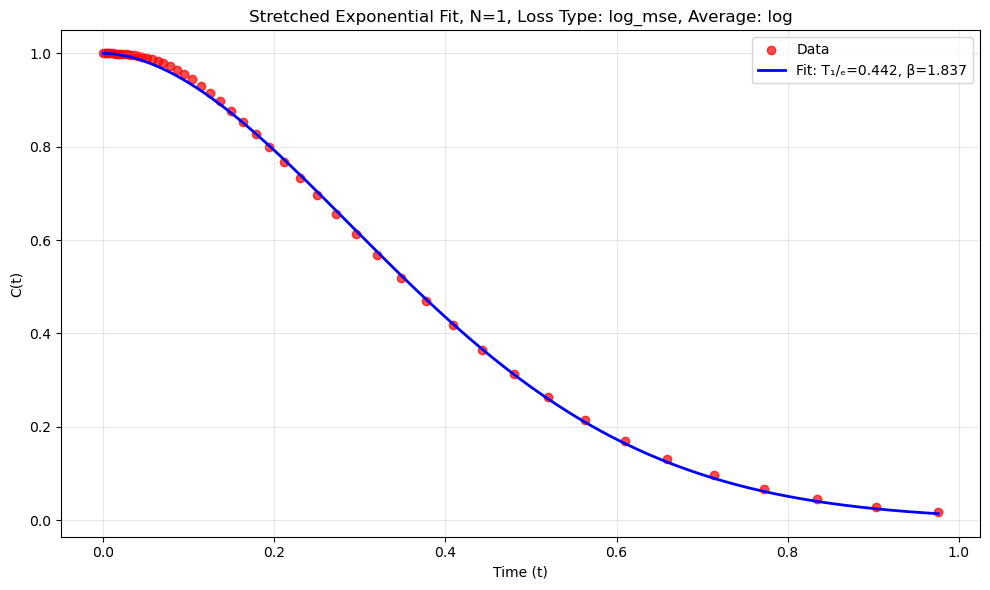

Fitted Parameters:
N = 2
T_1/e = 0.5732 ± 0.0021
β = 1.8626 ± 0.0155
T2 = 0.6212 ± 0.0021
R² = 0.9996
----------------------------------------


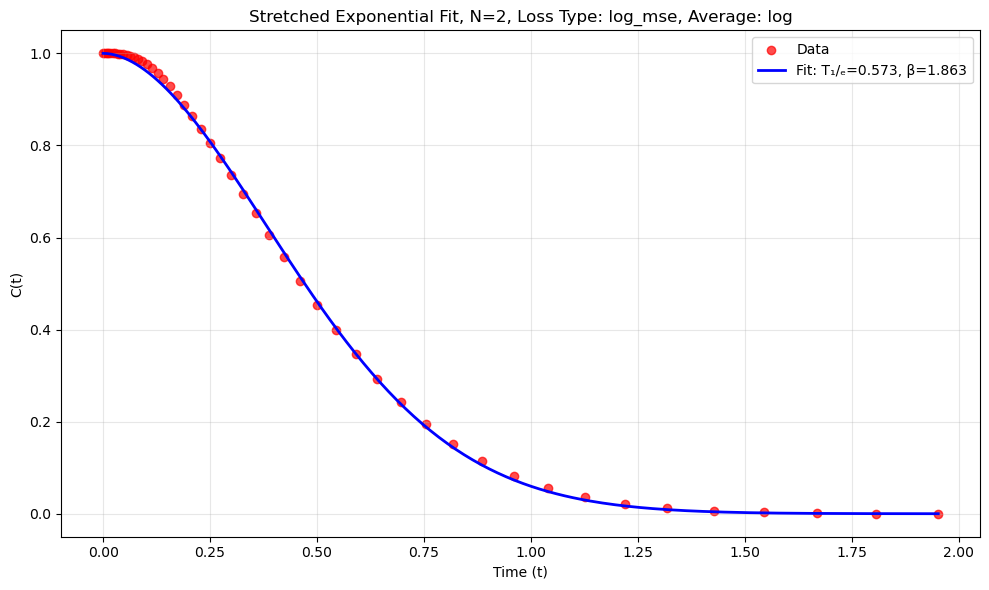

Fitted Parameters:
N = 4
T_1/e = 0.7449 ± 0.0044
β = 1.9529 ± 0.0280
T2 = 0.8409 ± 0.0044
R² = 0.9990
----------------------------------------


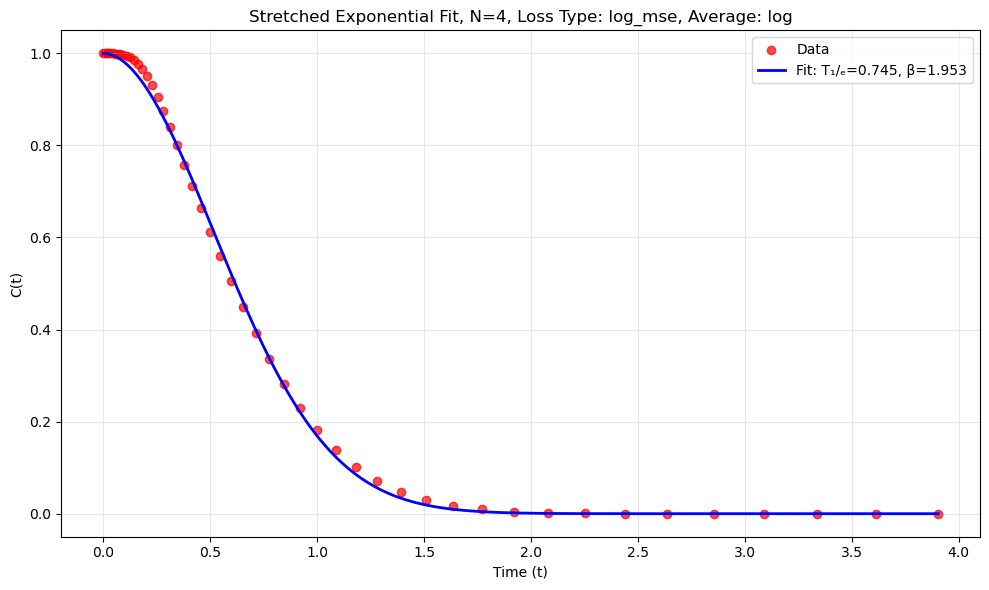

Fitted Parameters:
N = 8
T_1/e = 1.0065 ± 0.0078
β = 2.1857 ± 0.0466
T2 = 1.1985 ± 0.0078
R² = 0.9983
----------------------------------------


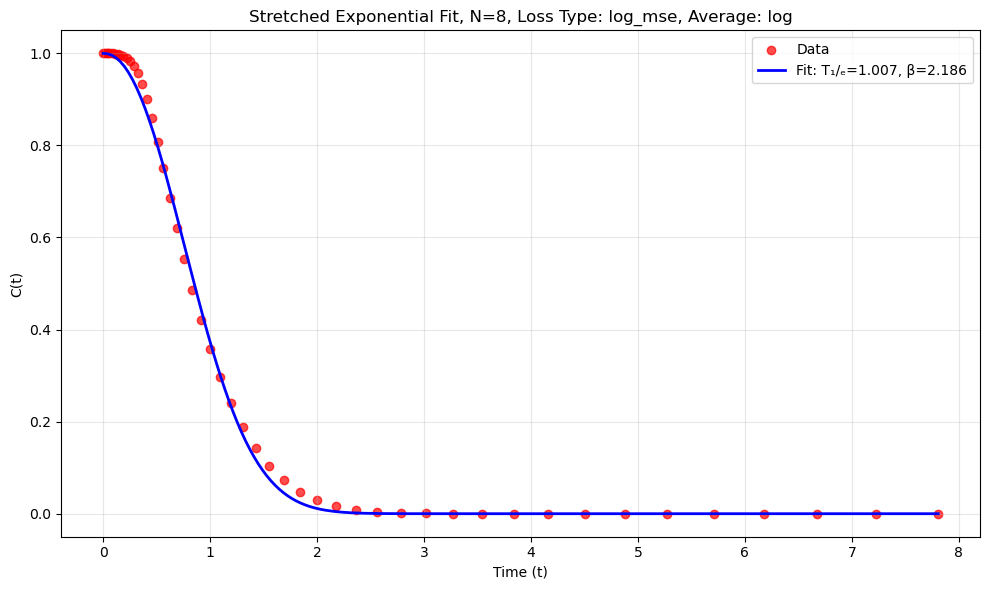

Fitted Parameters:
N = 16
T_1/e = 1.4241 ± 0.0103
β = 2.6412 ± 0.0628
T2 = 1.8081 ± 0.0103
R² = 0.9984
----------------------------------------


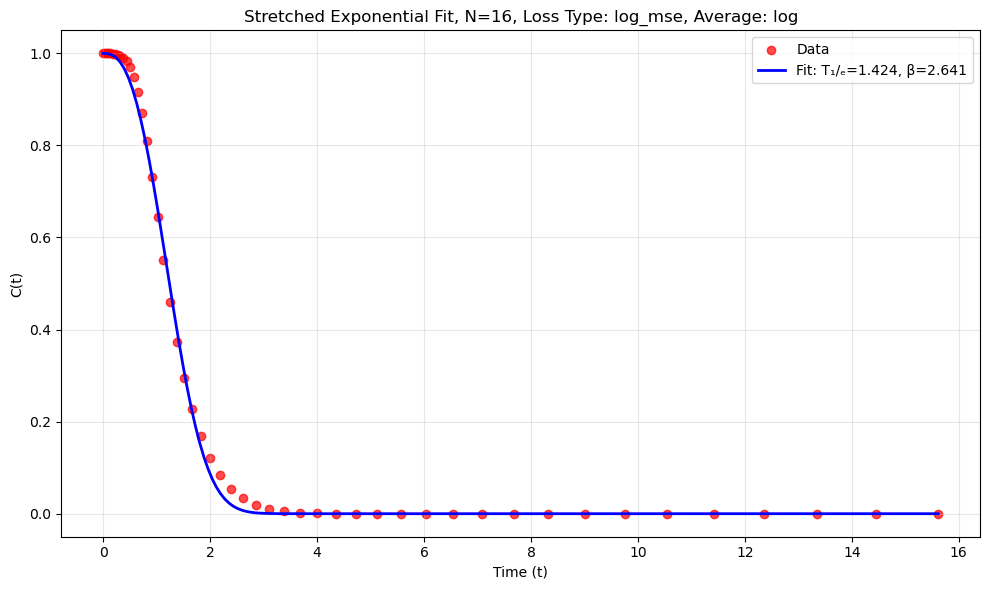

Fitted Parameters:
N = 32
T_1/e = 2.1542 ± 0.0101
β = 3.2295 ± 0.0609
T2 = 2.9222 ± 0.0101
R² = 0.9992
----------------------------------------


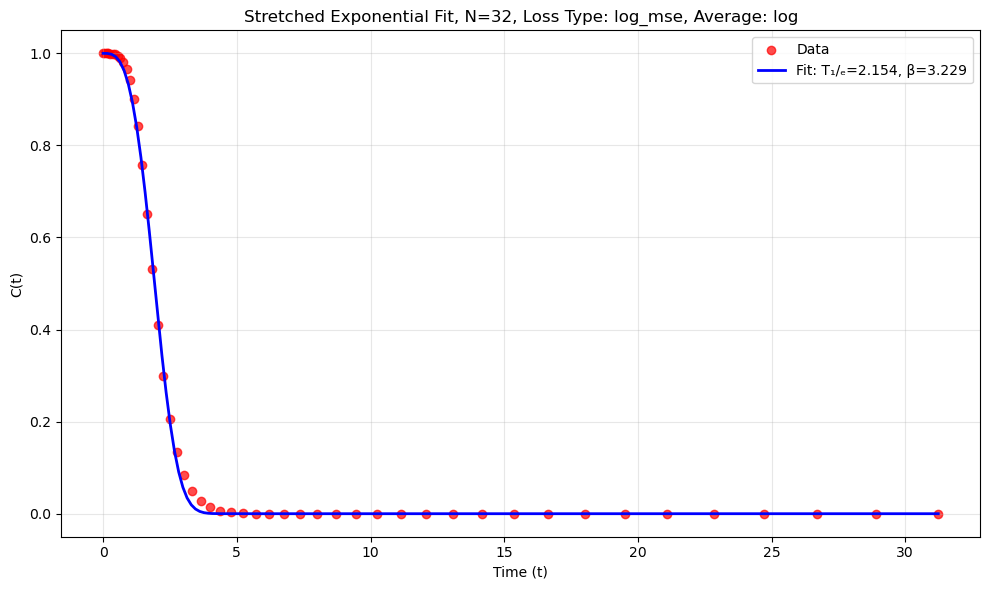

Fitted Parameters:
N = 64
T_1/e = 3.4519 ± 0.0084
β = 3.7259 ± 0.0421
T2 = 4.9879 ± 0.0084
R² = 0.9998
----------------------------------------


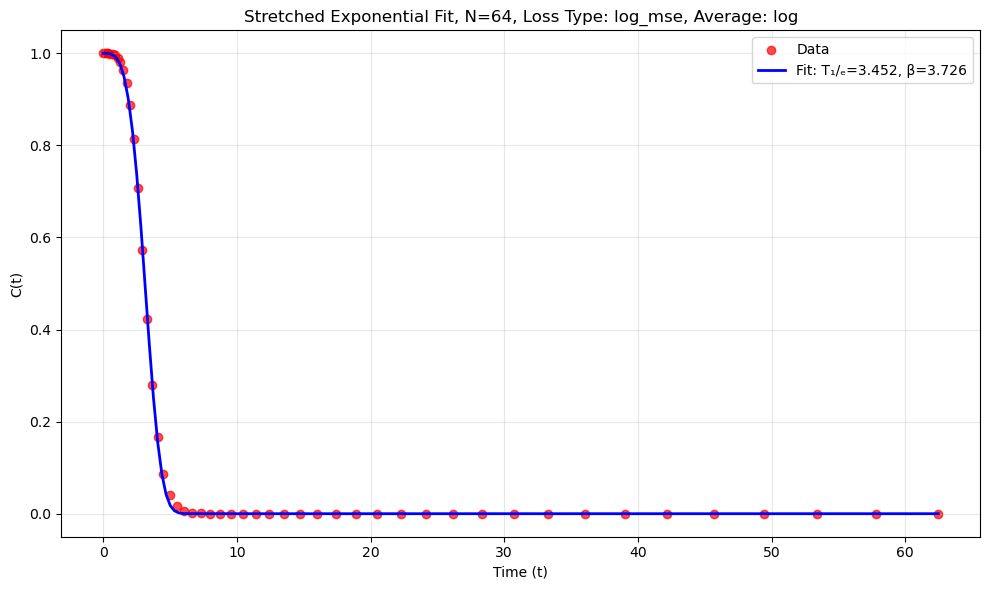

Fitted Parameters:
N = 128
T_1/e = 5.7194 ± 0.0062
β = 4.0284 ± 0.0217
T2 = 8.7914 ± 0.0062
R² = 0.9999
----------------------------------------


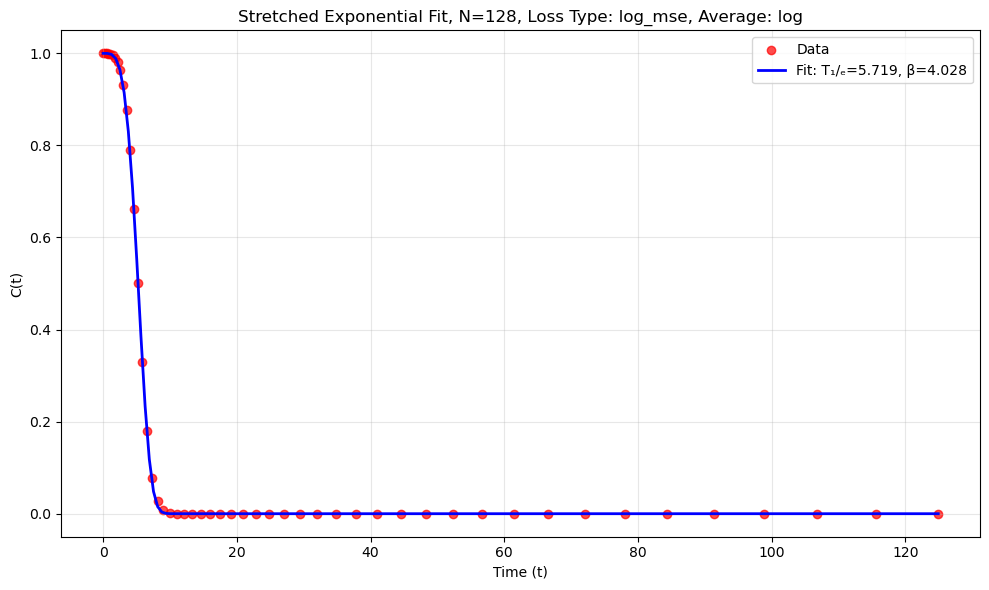

Fitted Parameters:
N = 256
T_1/e = 9.6290 ± 0.0040
β = 4.1596 ± 0.0090
T2 = 15.7730 ± 0.0040
R² = 1.0000
----------------------------------------


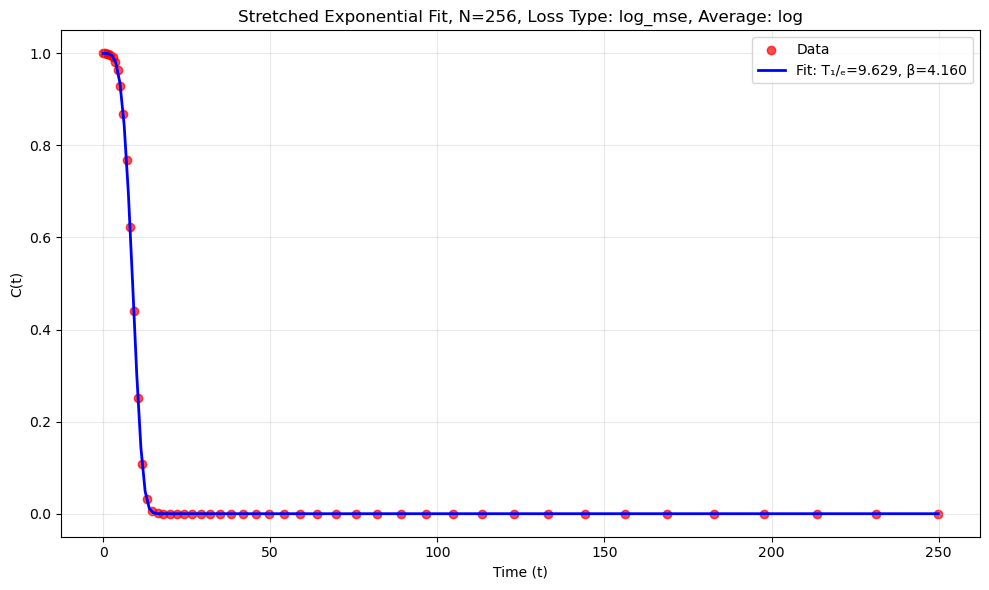

Fitted Parameters:
N = 512
T_1/e = 16.3121 ± 0.0077
β = 4.1704 ± 0.0103
T2 = 28.6001 ± 0.0077
R² = 1.0000
----------------------------------------


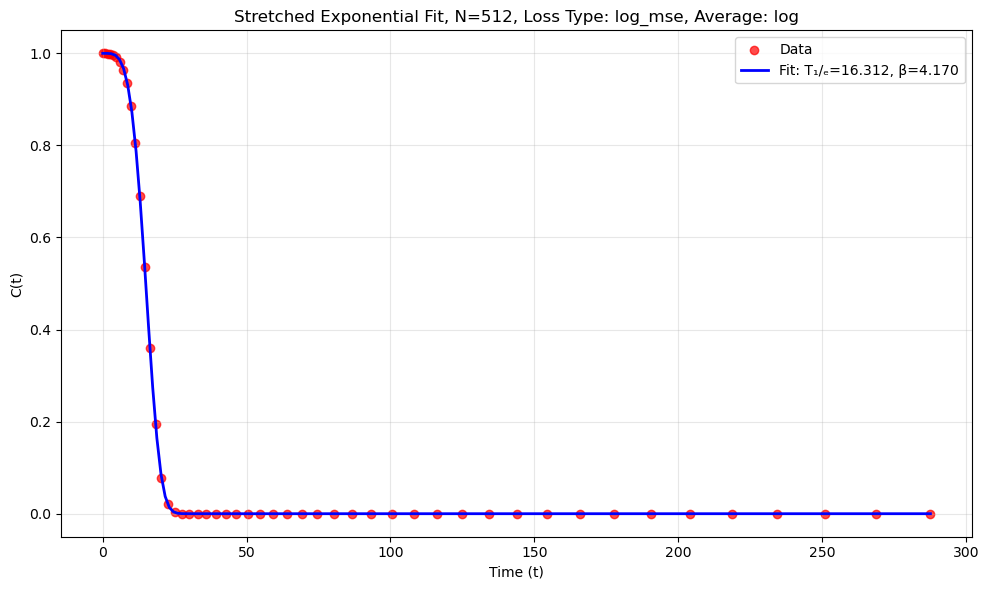

Fitted Parameters:
N = 1024
T_1/e = 27.6514 ± 0.0202
β = 4.1031 ± 0.0155
T2 = 52.2274 ± 0.0202
R² = 1.0000
----------------------------------------


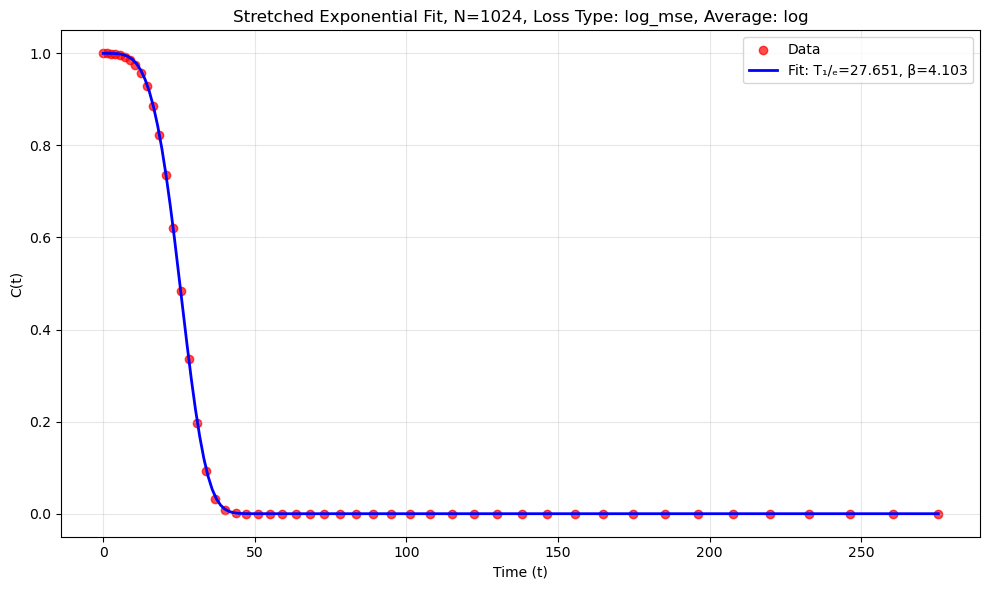

Fitted Parameters:
N = 2048
T_1/e = 46.7233 ± 0.0443
β = 3.9870 ± 0.0191
T2 = 95.8753 ± 0.0443
R² = 0.9999
----------------------------------------


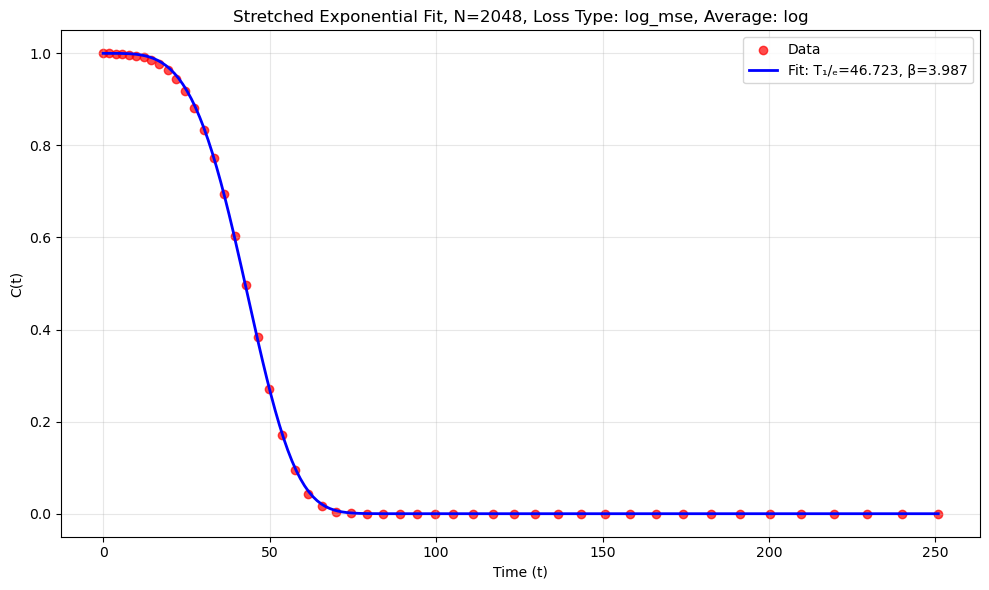

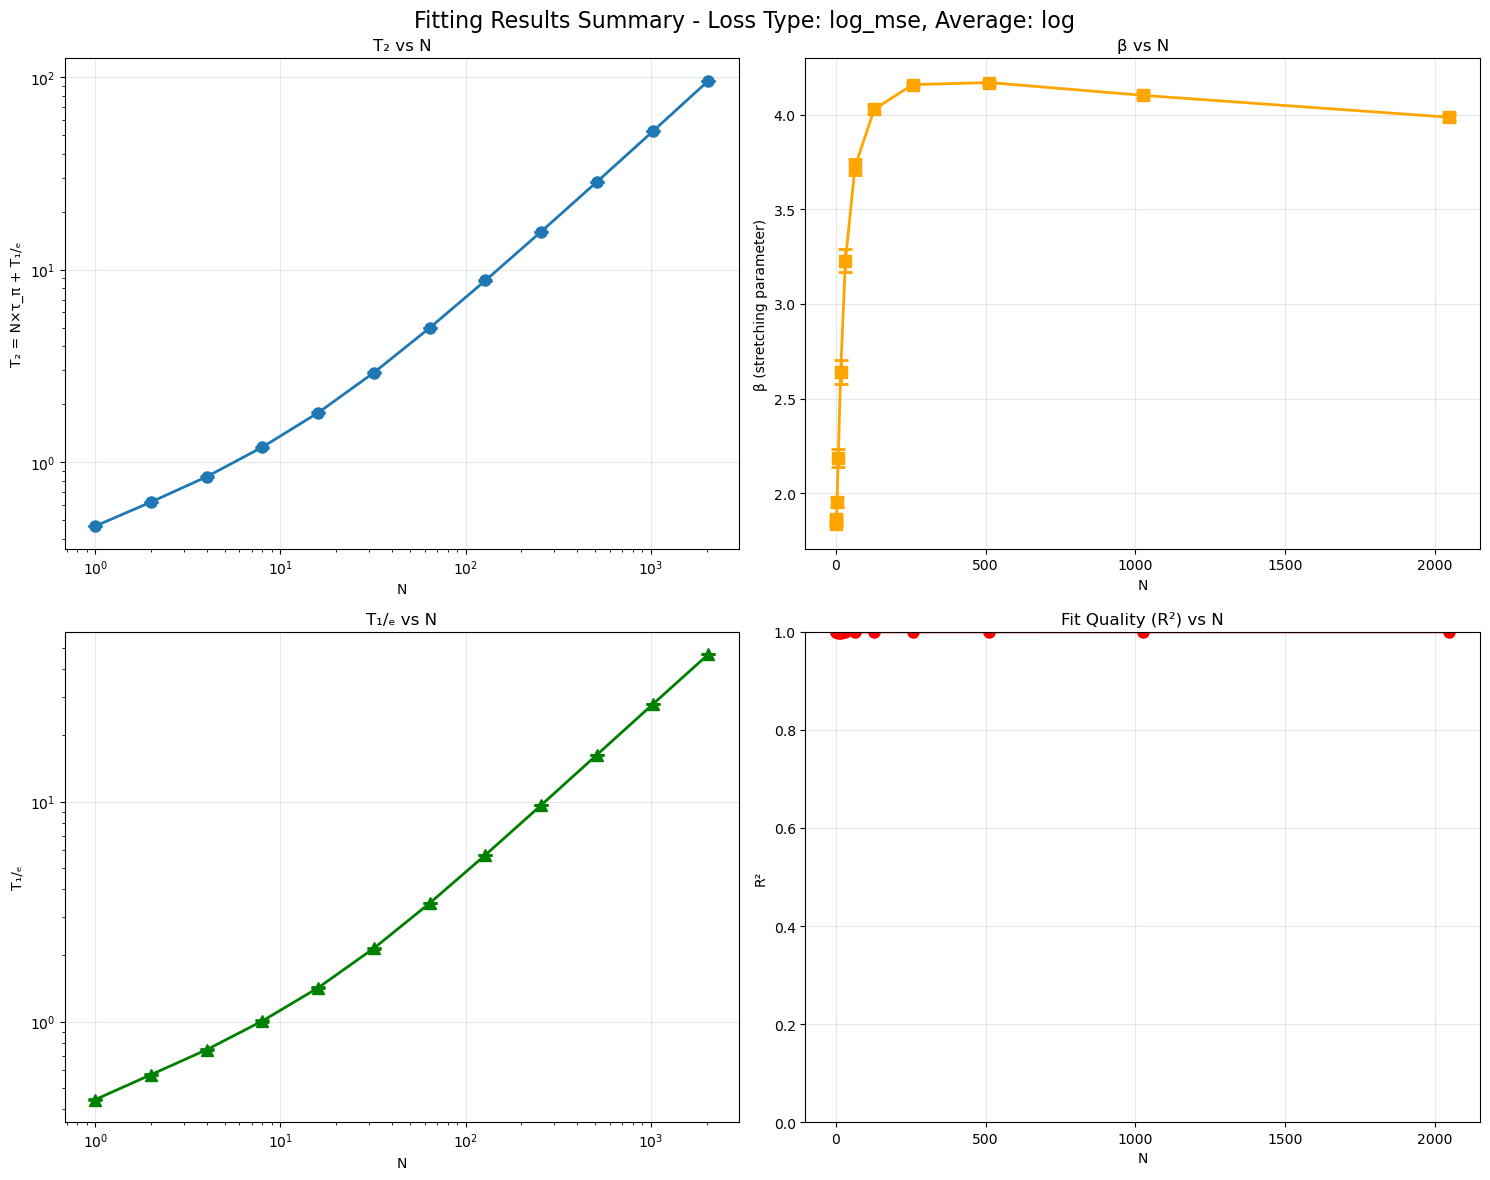


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.466 to 95.875
β range: 1.837 to 4.170
Average R²: 0.999 ± 0.001
Fitted Parameters:
N = 1
T_1/e = 0.4419 ± 0.0014
β = 1.8223 ± 0.0129
T2 = 0.4659 ± 0.0014
R² = 0.9996
----------------------------------------


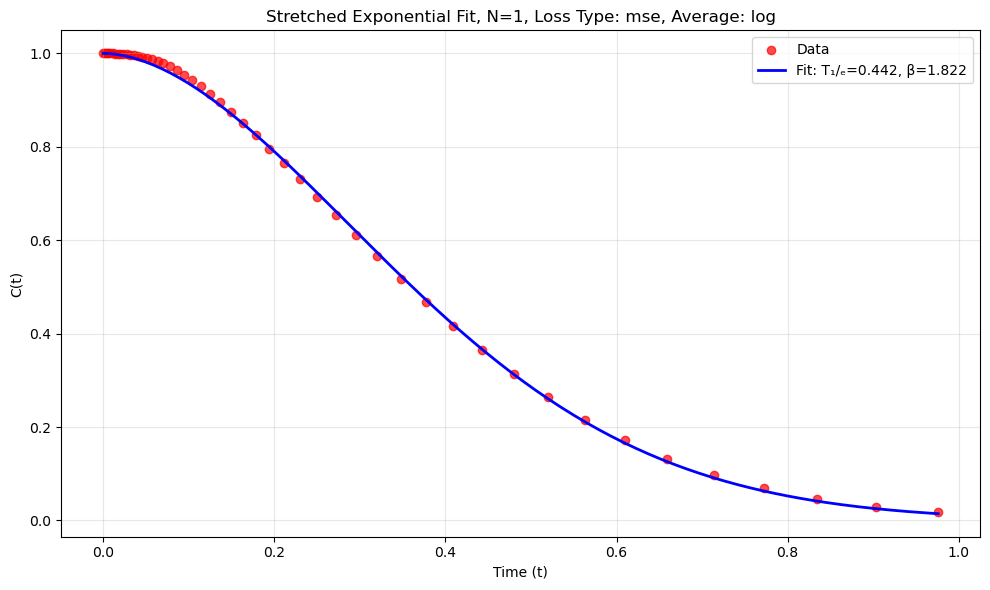

Fitted Parameters:
N = 2
T_1/e = 0.5709 ± 0.0022
β = 1.8510 ± 0.0162
T2 = 0.6189 ± 0.0022
R² = 0.9995
----------------------------------------


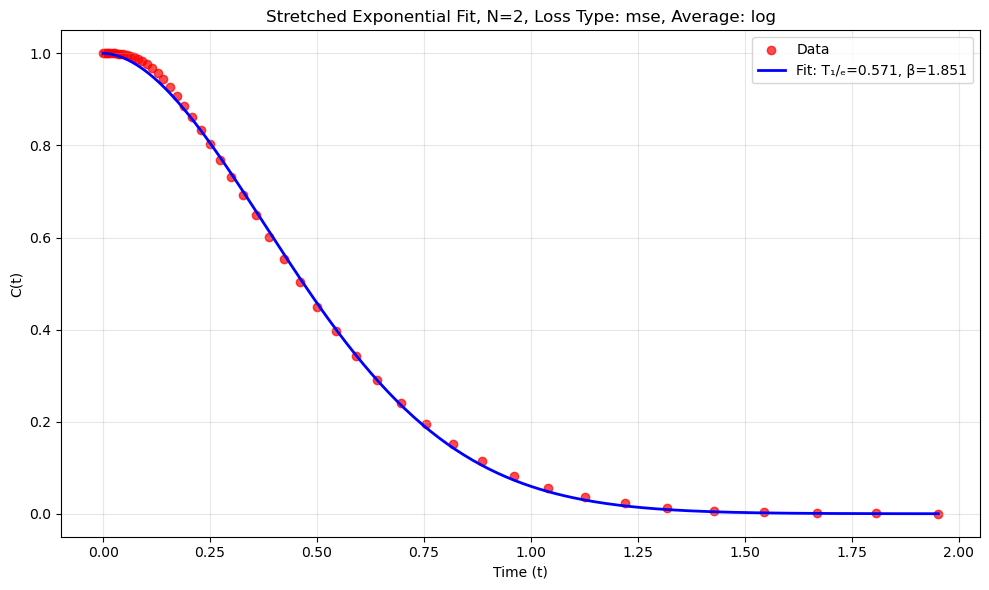

Fitted Parameters:
N = 4
T_1/e = 0.7394 ± 0.0046
β = 1.9485 ± 0.0292
T2 = 0.8354 ± 0.0046
R² = 0.9989
----------------------------------------


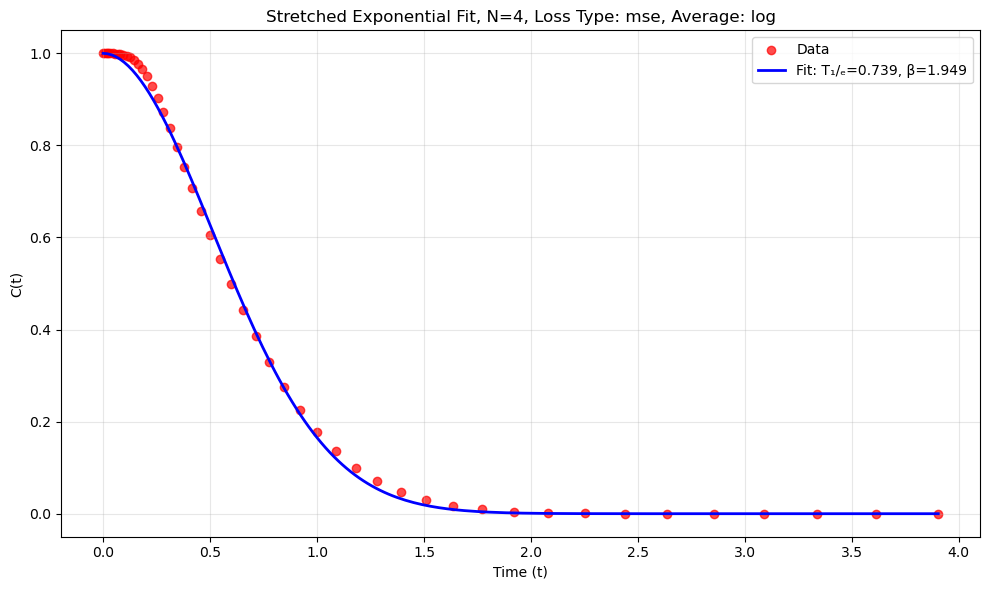

Fitted Parameters:
N = 8
T_1/e = 0.9973 ± 0.0080
β = 2.1961 ± 0.0482
T2 = 1.1893 ± 0.0080
R² = 0.9982
----------------------------------------


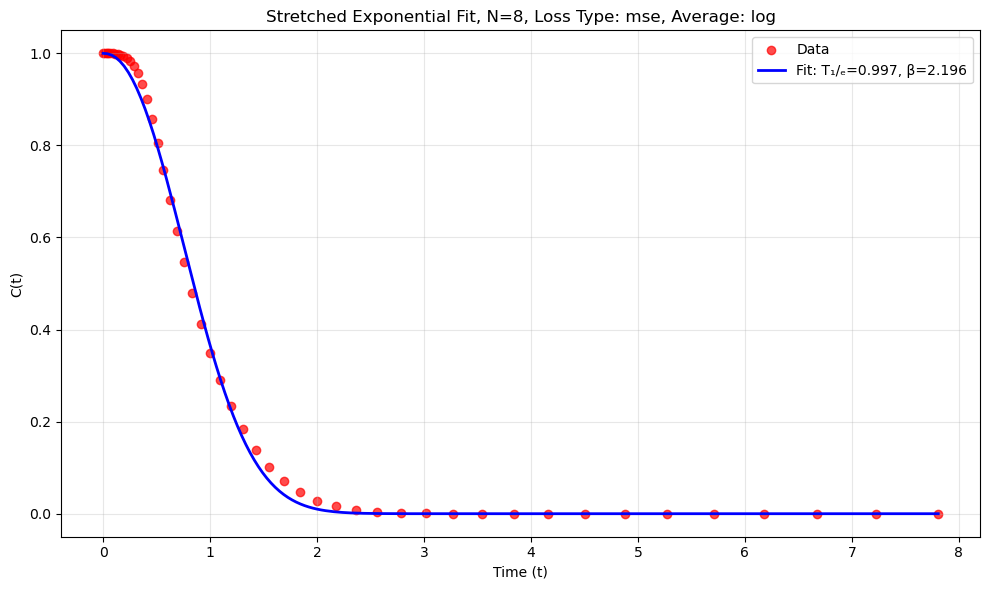

Fitted Parameters:
N = 16
T_1/e = 1.4128 ± 0.0101
β = 2.6712 ± 0.0639
T2 = 1.7968 ± 0.0101
R² = 0.9984
----------------------------------------


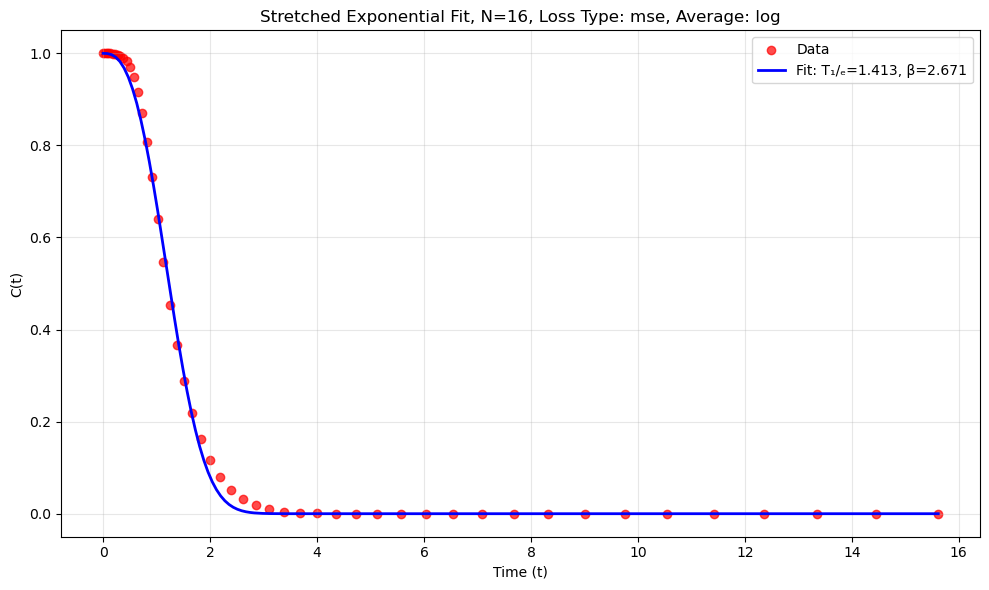

Fitted Parameters:
N = 32
T_1/e = 2.1442 ± 0.0098
β = 3.2667 ± 0.0604
T2 = 2.9122 ± 0.0098
R² = 0.9992
----------------------------------------


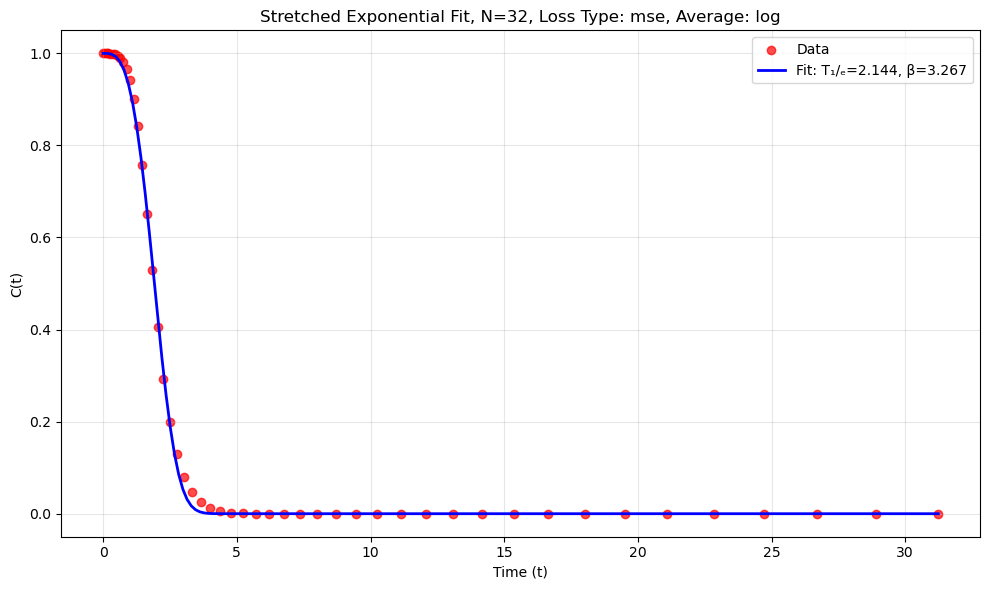

Fitted Parameters:
N = 64
T_1/e = 3.4456 ± 0.0080
β = 3.7545 ± 0.0407
T2 = 4.9816 ± 0.0080
R² = 0.9998
----------------------------------------


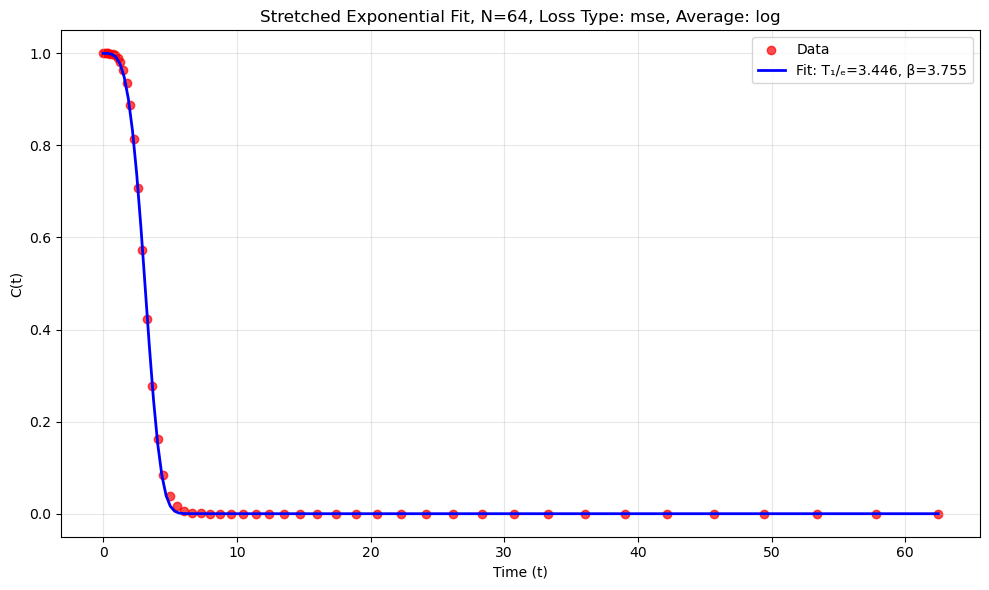

Fitted Parameters:
N = 128
T_1/e = 5.7181 ± 0.0058
β = 4.0445 ± 0.0205
T2 = 8.7901 ± 0.0058
R² = 1.0000
----------------------------------------


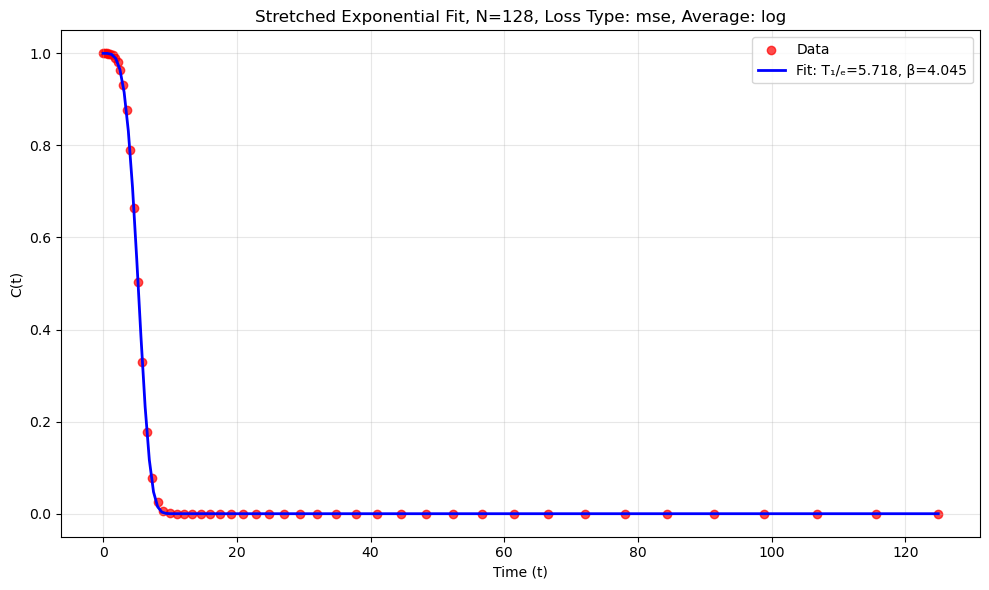

Fitted Parameters:
N = 256
T_1/e = 9.6342 ± 0.0038
β = 4.1655 ± 0.0086
T2 = 15.7782 ± 0.0038
R² = 1.0000
----------------------------------------


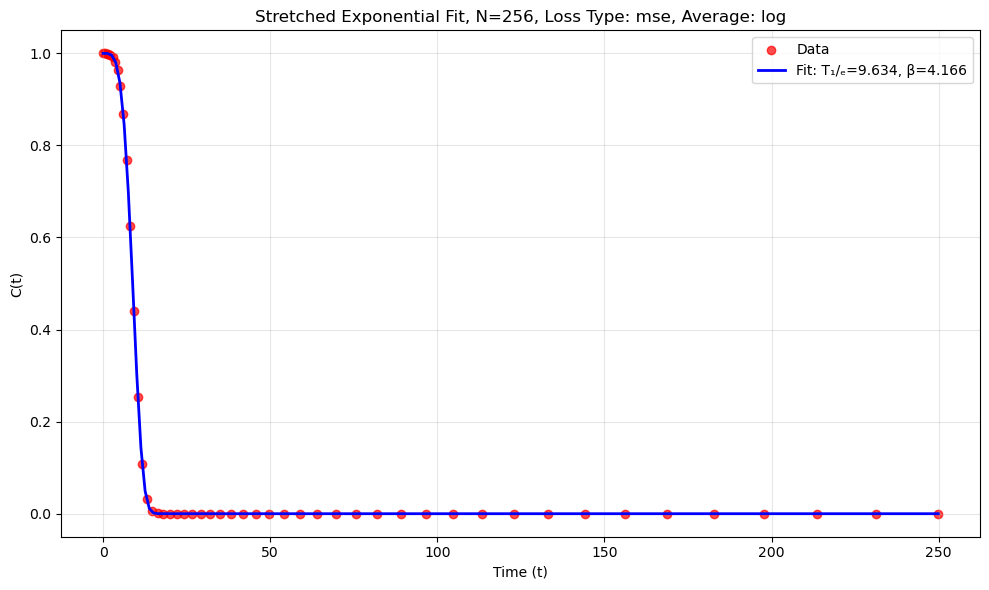

Fitted Parameters:
N = 512
T_1/e = 16.3257 ± 0.0080
β = 4.1695 ± 0.0106
T2 = 28.6137 ± 0.0080
R² = 1.0000
----------------------------------------


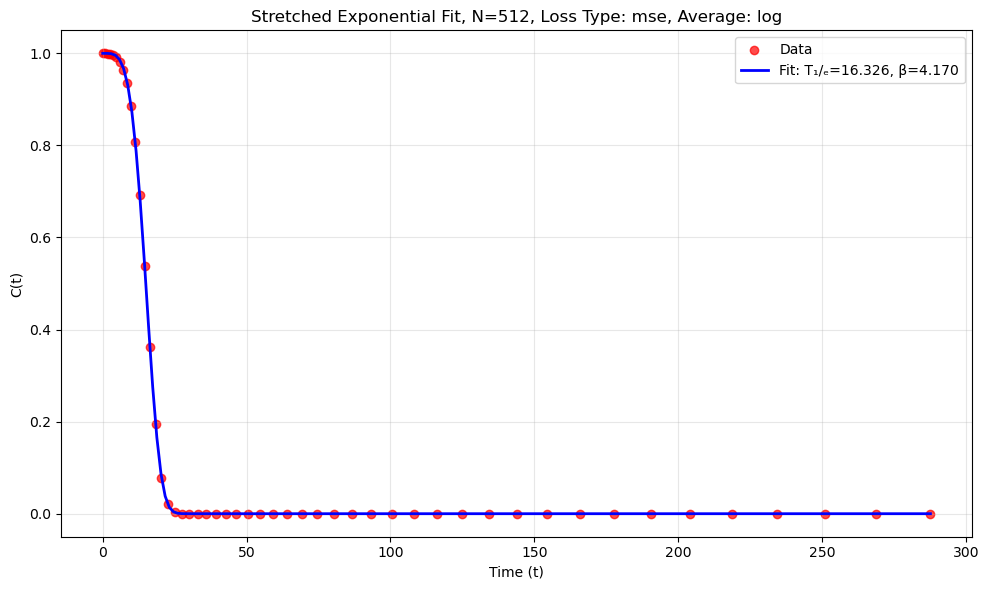

Fitted Parameters:
N = 1024
T_1/e = 27.6742 ± 0.0206
β = 4.0979 ± 0.0158
T2 = 52.2502 ± 0.0206
R² = 1.0000
----------------------------------------


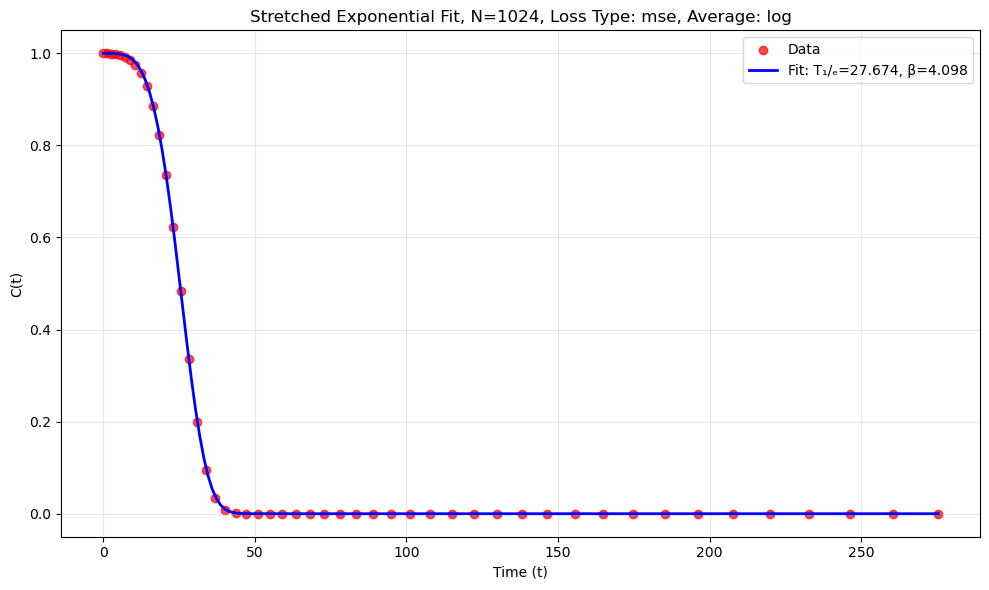

Fitted Parameters:
N = 2048
T_1/e = 46.7523 ± 0.0449
β = 3.9794 ± 0.0193
T2 = 95.9043 ± 0.0449
R² = 0.9999
----------------------------------------


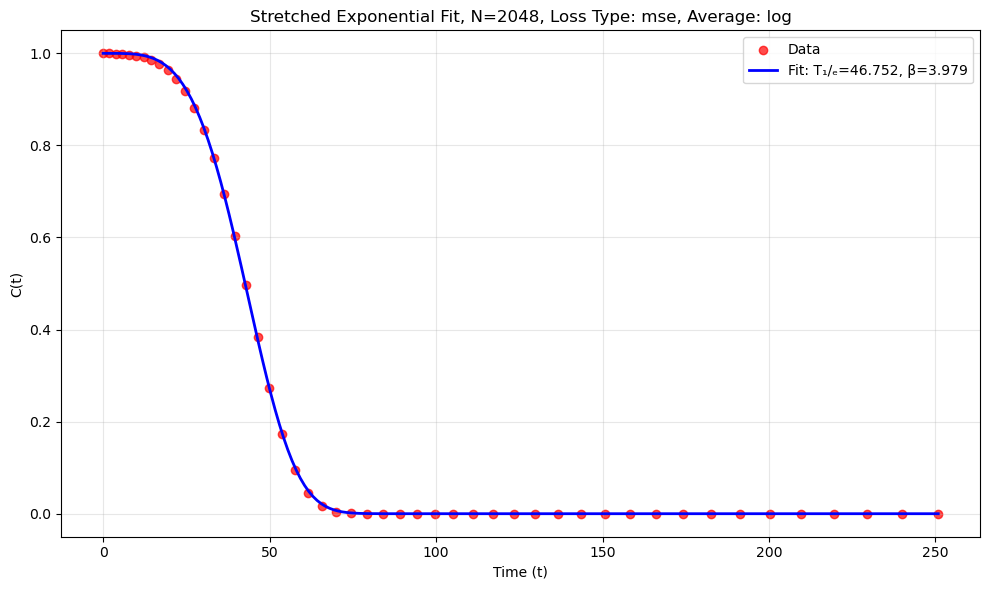

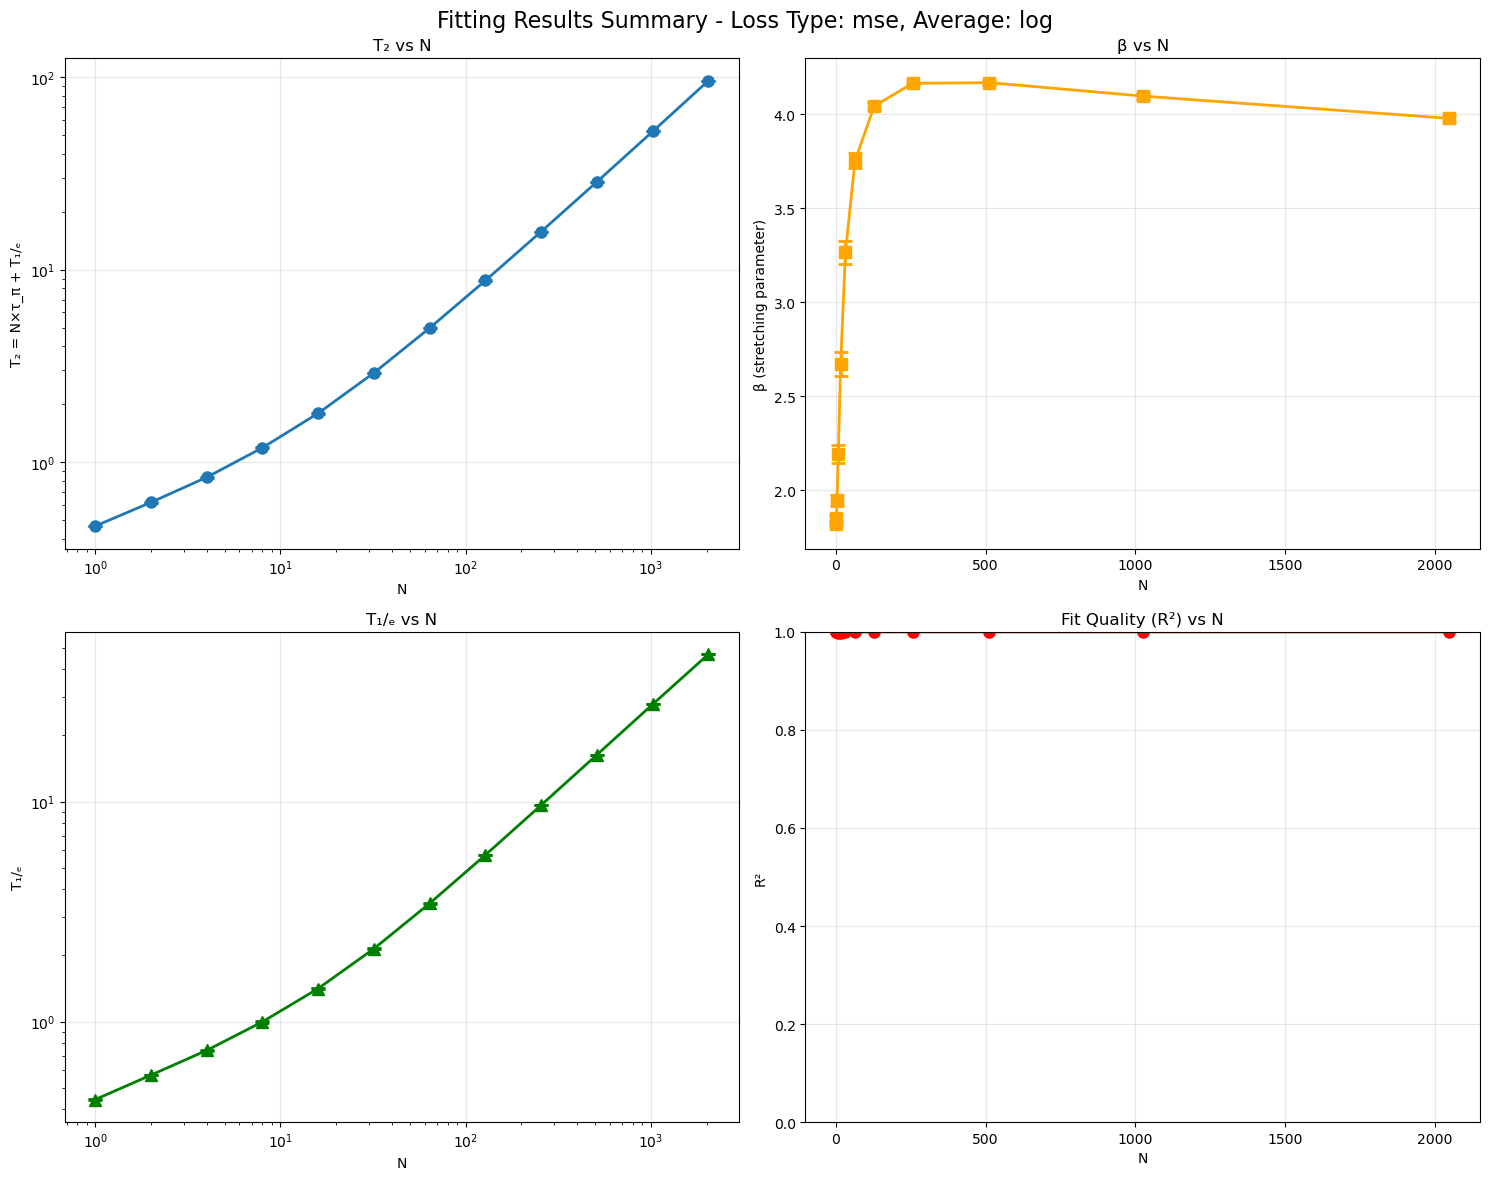


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.466 to 95.904
β range: 1.822 to 4.170
Average R²: 0.999 ± 0.001
Fitted Parameters:
N = 1
T_1/e = 0.4433 ± 0.0014
β = 1.8429 ± 0.0129
T2 = 0.4673 ± 0.0014
R² = 0.9996
----------------------------------------


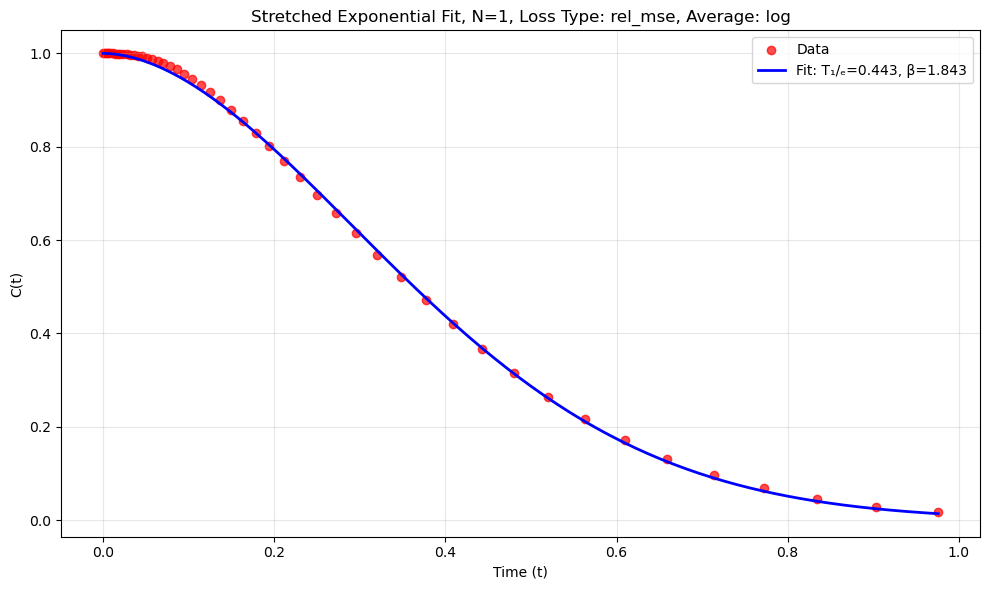

Fitted Parameters:
N = 2
T_1/e = 0.5750 ± 0.0022
β = 1.8727 ± 0.0161
T2 = 0.6230 ± 0.0022
R² = 0.9996
----------------------------------------


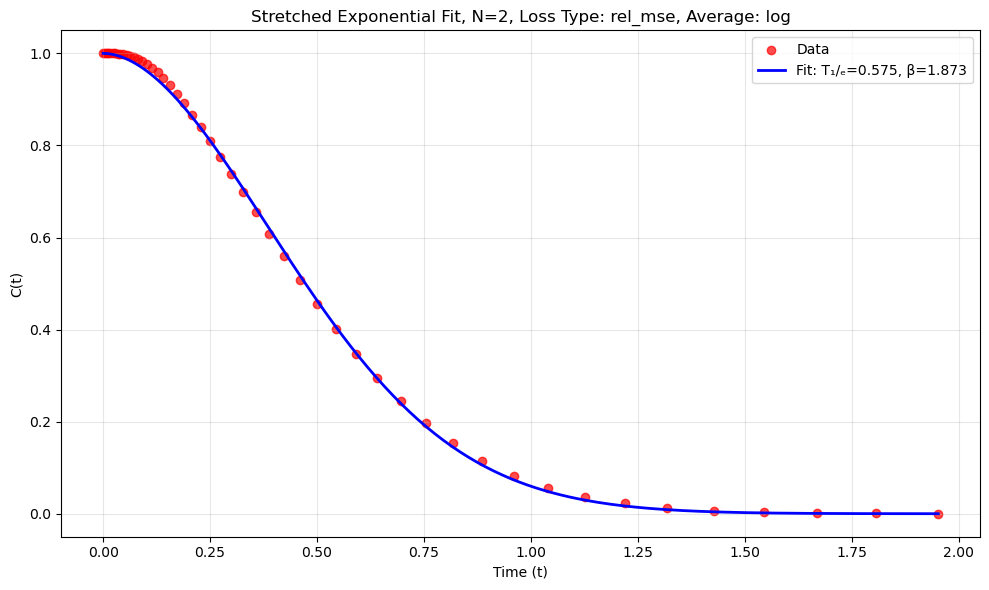

Fitted Parameters:
N = 4
T_1/e = 0.7481 ± 0.0045
β = 1.9735 ± 0.0288
T2 = 0.8441 ± 0.0045
R² = 0.9990
----------------------------------------


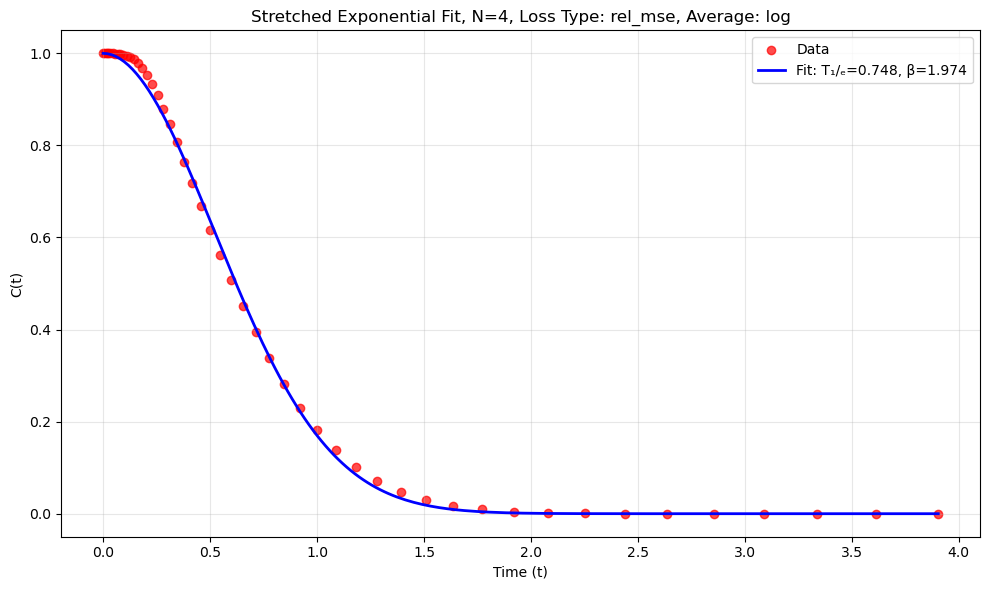

Fitted Parameters:
N = 8
T_1/e = 1.0146 ± 0.0076
β = 2.2198 ± 0.0464
T2 = 1.2066 ± 0.0076
R² = 0.9984
----------------------------------------


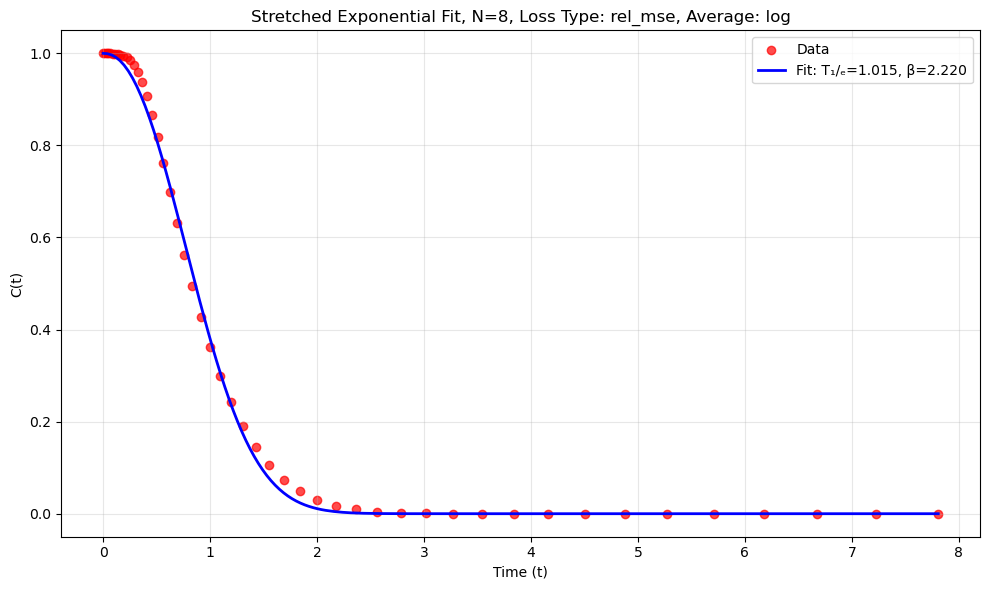

Fitted Parameters:
N = 16
T_1/e = 1.4444 ± 0.0097
β = 2.6714 ± 0.0597
T2 = 1.8284 ± 0.0097
R² = 0.9986
----------------------------------------


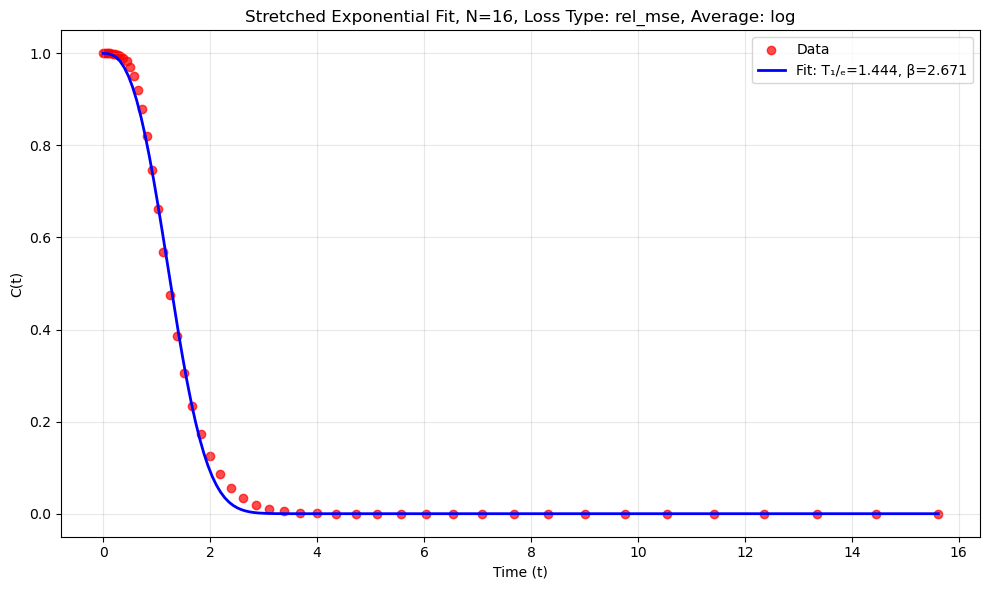

Fitted Parameters:
N = 32
T_1/e = 2.1945 ± 0.0094
β = 3.2194 ± 0.0553
T2 = 2.9625 ± 0.0094
R² = 0.9993
----------------------------------------


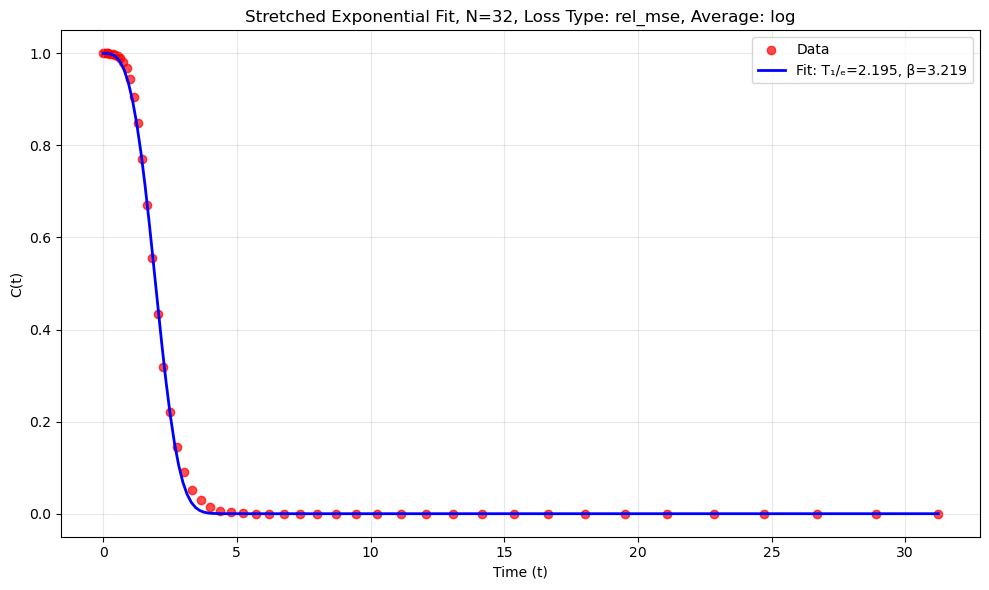

Fitted Parameters:
N = 64
T_1/e = 3.5166 ± 0.0078
β = 3.6639 ± 0.0371
T2 = 5.0526 ± 0.0078
R² = 0.9998
----------------------------------------


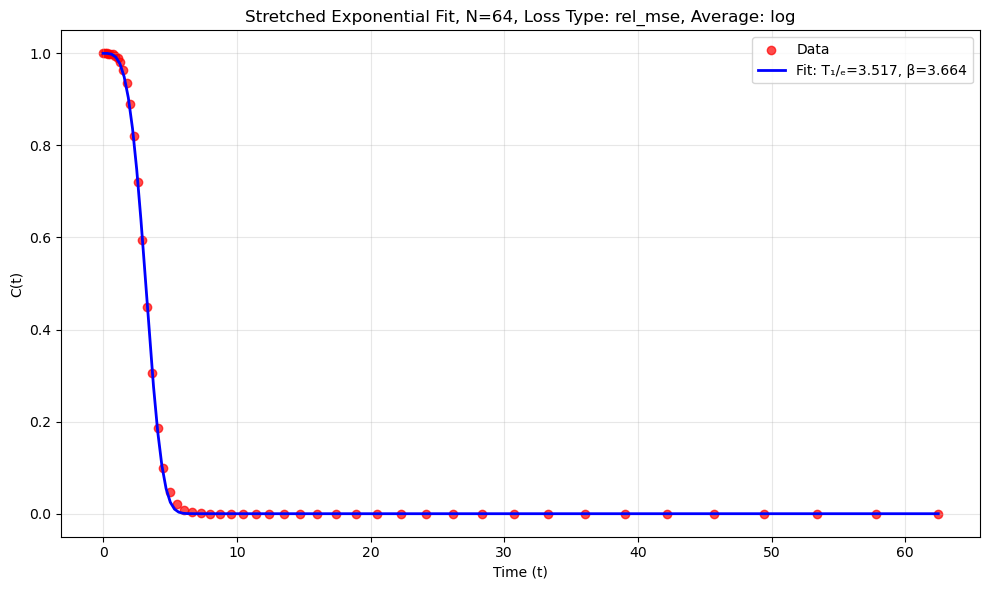

Fitted Parameters:
N = 128
T_1/e = 5.8097 ± 0.0057
β = 3.9280 ± 0.0187
T2 = 8.8817 ± 0.0057
R² = 1.0000
----------------------------------------


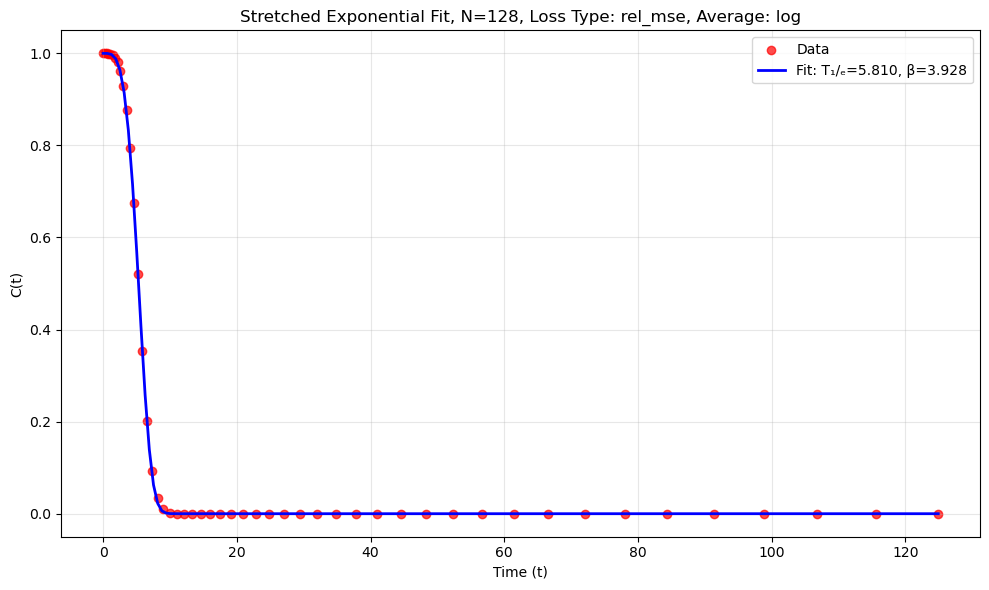

Fitted Parameters:
N = 256
T_1/e = 9.7389 ± 0.0038
β = 4.0369 ± 0.0080
T2 = 15.8829 ± 0.0038
R² = 1.0000
----------------------------------------


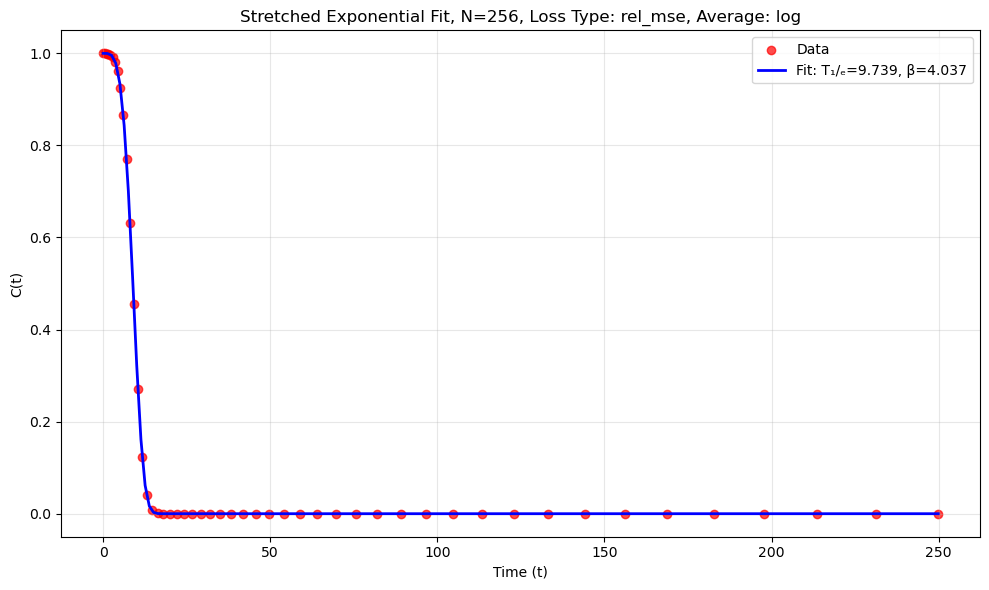

Fitted Parameters:
N = 512
T_1/e = 16.4156 ± 0.0083
β = 4.0370 ± 0.0104
T2 = 28.7036 ± 0.0083
R² = 1.0000
----------------------------------------


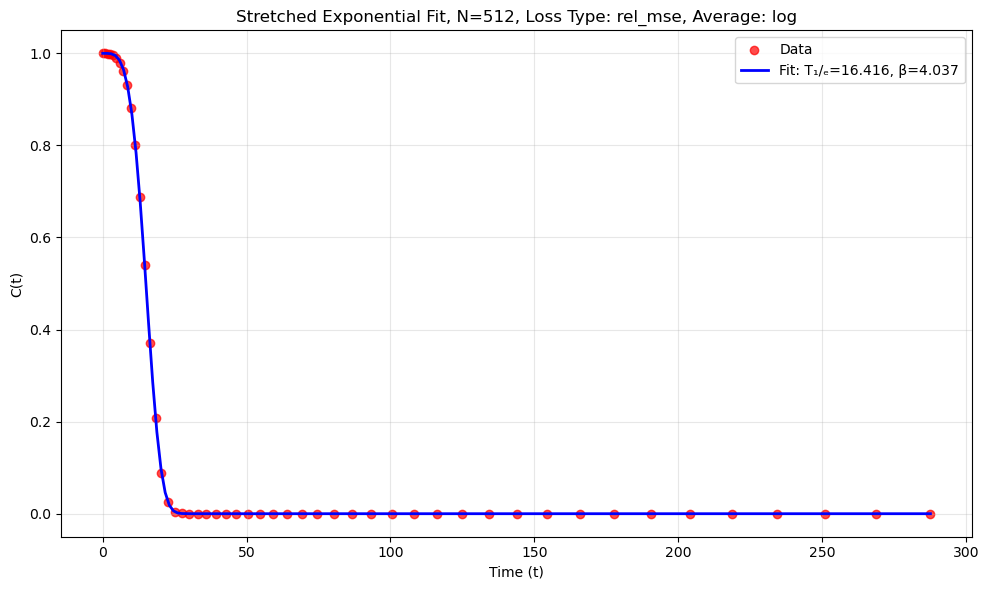

Fitted Parameters:
N = 1024
T_1/e = 27.6747 ± 0.0213
β = 3.9662 ± 0.0153
T2 = 52.2507 ± 0.0213
R² = 1.0000
----------------------------------------


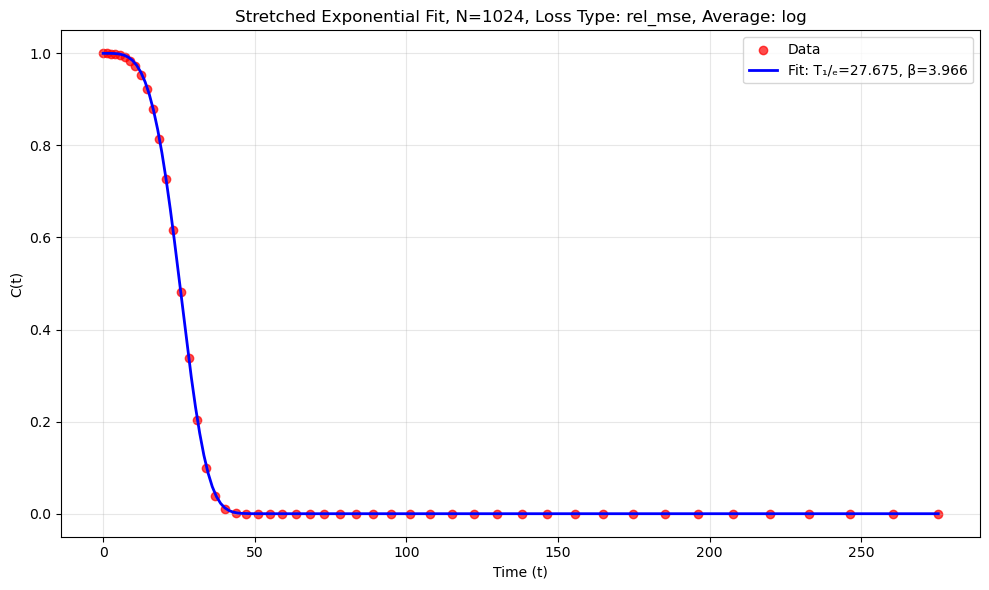

Fitted Parameters:
N = 2048
T_1/e = 46.4895 ± 0.0458
β = 3.8511 ± 0.0186
T2 = 95.6415 ± 0.0458
R² = 0.9999
----------------------------------------


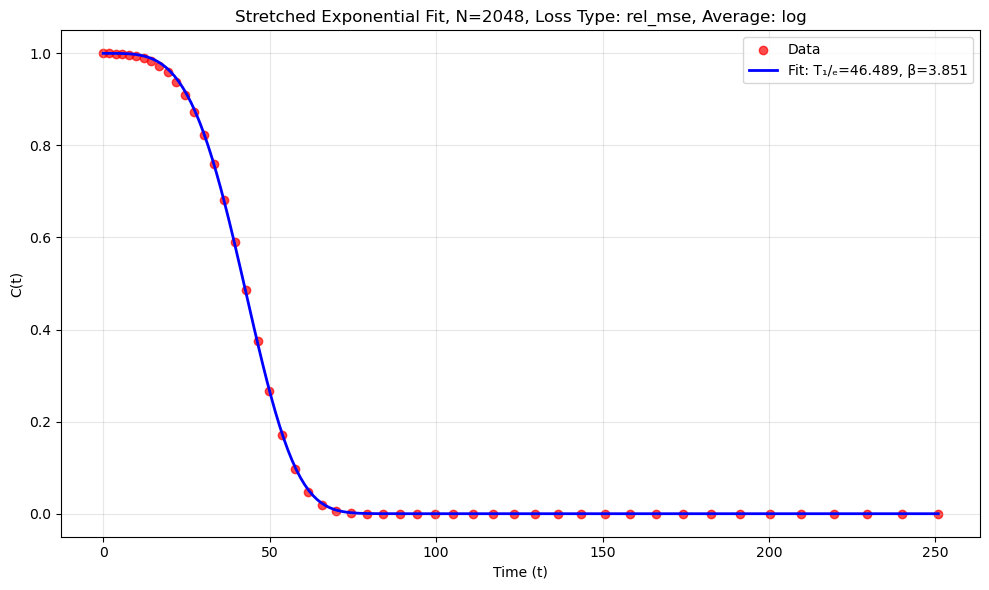

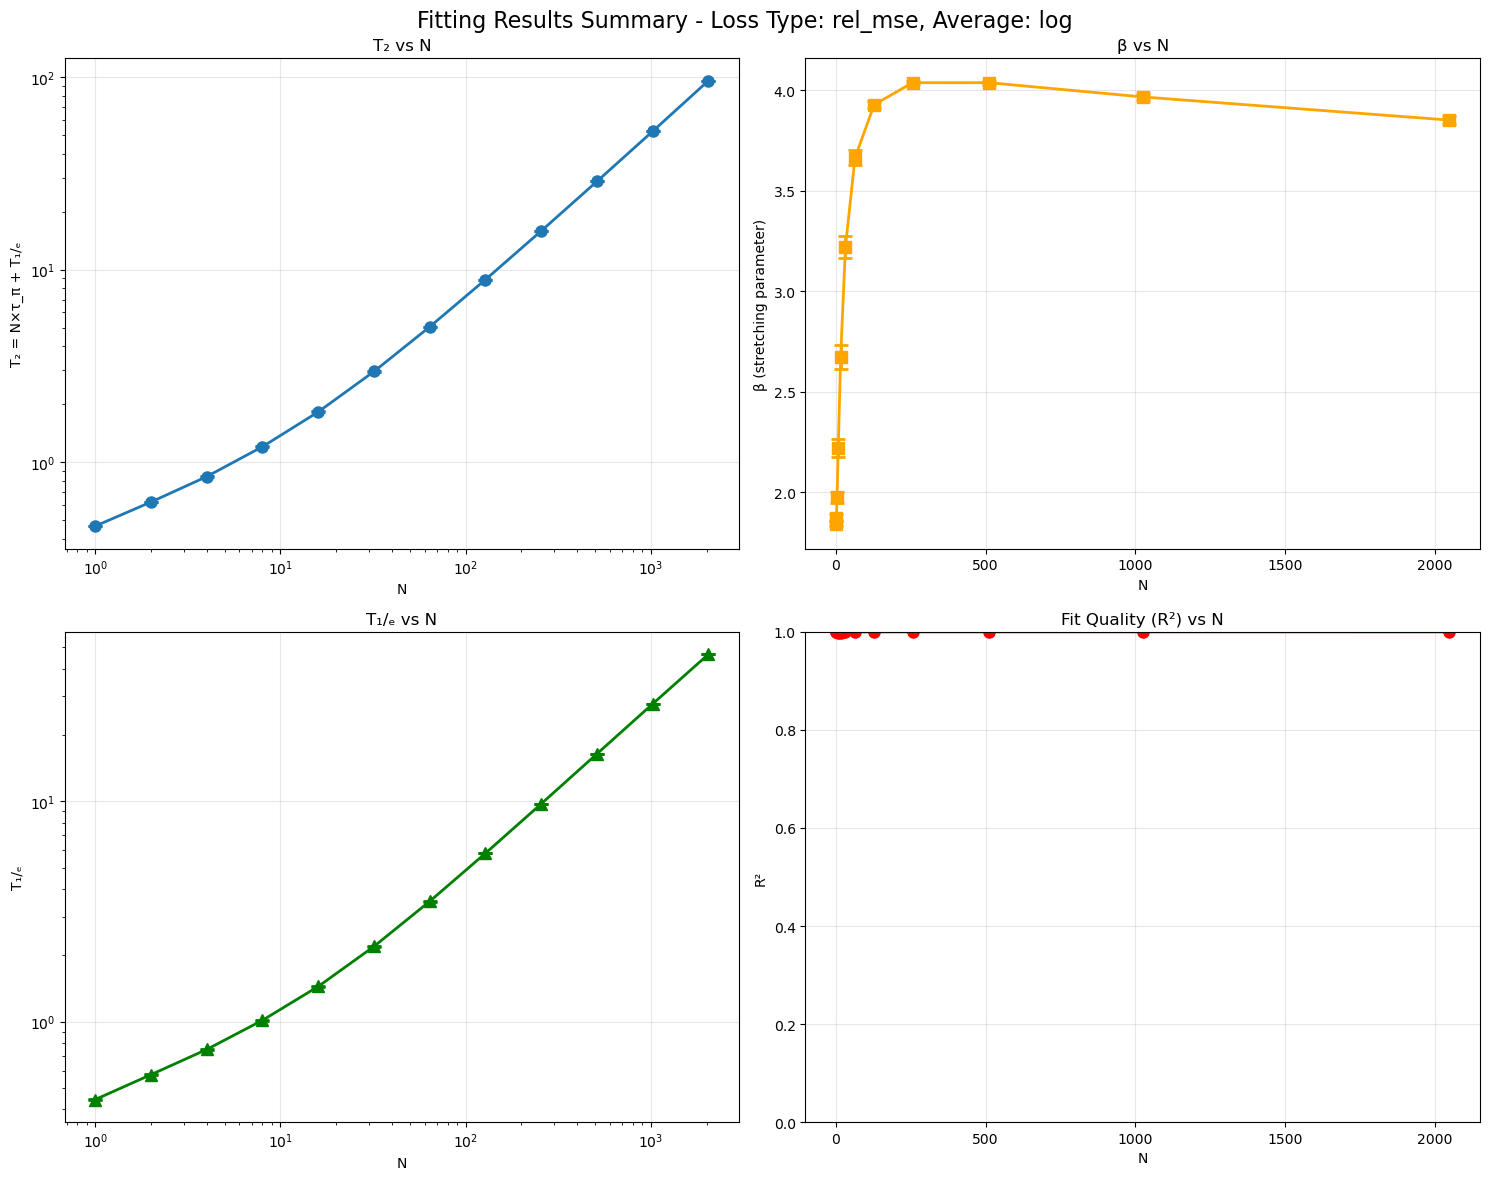


SUMMARY STATISTICS:
Number of successful fits: 12
N range: 1 to 2048
T₂ range: 0.467 to 95.641
β range: 1.843 to 4.037
Average R²: 1.000 ± 0.001


Exception ignored in: <function ResourceTracker.__del__ at 0x6ffc05985620>
Traceback (most recent call last):
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7696bbf8d620>
Traceback (most recent call last):
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/nhuffman/anaconda3/envs/souvik/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessErr

In [18]:
# Define your function
def stretched_exponential(t, T_1e, beta):
    """
    Stretched exponential function: C(t) = exp(-(t/T_1e)^beta)
    
    Parameters:
    t: time values
    T_1e: characteristic time constant
    beta: stretching parameter
    """
    return np.exp(-(t / T_1e)**beta)

tau_pi = 0.024  # pi pulse width in microseconds


for average in ["linear","log"]:
    ########### S(w) plots, helpful to compare the noise learned from different combinatinons of averaging strategy and loss function ##########

    plt.figure(figsize=(14,8))

    ########## C(t) plots ##########

    plt.figure(figsize=(14,8))
    ########### CHANGE WHICH AVERAGING STRATEGY YOU WANT TO USE HERE ###########
    for loss_type in ['log_mse',"mse",'rel_mse']:

        C_ts = C_t_save_me[average][loss_type]

        # Initialize lists to store results for final plot
        n_values = []
        T2_values = []
        T2_errors = []
        beta_values = []
        beta_errors = []
        r_squared_values = []

        for n, C_data in C_ts.items():
            # Perform the curve fitting
            try:
                initial_guess = [n, 1.0]  # [T_1e_guess, beta_guess]
                t_true = np.logspace(np.log10(n*tau_pi+1e-10), np.log10(np.min((n,300))), 50)-n*tau_pi
                
                # Define bounds: both T_1e and beta must be positive
                # bounds = ([lower_bounds], [upper_bounds])
                bounds = ([1e-10, 1e-10], [np.inf, np.inf])  # T_1e > 0, beta > 0
                
                # Alternative with more restrictive bounds (if you know reasonable ranges):
                # bounds = ([1e-10, 0.1], [1000, 5.0])  # T_1e: (0, 1000], beta: [0.1, 5.0]
                
                # curve_fit returns optimal parameters and covariance matrix
                popt, pcov = curve_fit(stretched_exponential, t_true, C_data,
                                    p0=initial_guess,
                                    bounds=bounds,  # Add the bounds constraint
                                    maxfev=5000)  # Increase max iterations if needed
            
                T_1e_fit, beta_fit = popt
            
                # Calculate parameter uncertainties (standard errors)
                param_errors = np.sqrt(np.diag(pcov))
                T_1e_error, beta_error = param_errors
                
                # Calculate T2 and its error
                T2 = n * tau_pi + T_1e_fit
                T2_error = T_1e_error  # Error propagation: T2_error = T_1e_error (since n*tau_pi is exact)
                
                # Store results for final plot
                n_values.append(n)
                T2_values.append(T2)
                T2_errors.append(T2_error)
                beta_values.append(beta_fit)
                beta_errors.append(beta_error)
                
                # Calculate R-squared
                C_pred = stretched_exponential(t_true, T_1e_fit, beta_fit)
                ss_res = np.sum((C_data - C_pred) ** 2)
                ss_tot = np.sum((C_data - np.mean(C_data)) ** 2)
                r_squared = 1 - (ss_res / ss_tot)
                r_squared_values.append(r_squared)
            
                print("Fitted Parameters:")
                print(f"N = {n}")
                print(f"T_1/e = {T_1e_fit:.4f} ± {T_1e_error:.4f}")
                print(f"β = {beta_fit:.4f} ± {beta_error:.4f}")
                print(f"T2 = {T2:.4f} ± {T2_error:.4f}")
                print(f"R² = {r_squared:.4f}")
                print("-" * 40)
            
                # Generate fitted curve for plotting
                t_fit = np.linspace(min(t_true), max(t_true), 200)
                C_fit = stretched_exponential(t_fit, T_1e_fit, beta_fit)
            
                # Plot results
                plt.figure(figsize=(10, 6))
                plt.scatter(t_true, C_data, color='red', alpha=0.7, label='Data')
                plt.plot(t_fit, C_fit, 'b-', linewidth=2,
                        label=f'Fit: T₁/ₑ={T_1e_fit:.3f}, β={beta_fit:.3f}')
                plt.xlabel('Time (t)')
                plt.ylabel('C(t)')
                plt.title(f'Stretched Exponential Fit, N={n}, Loss Type: {loss_type}, Average: {average}')
                plt.legend()
                plt.grid(True, alpha=0.3)
            
                plt.tight_layout()
                plt.show()
            
            except Exception as e:
                print(f"Fitting failed for n={n}: {e}")
                print("Try adjusting initial guesses or check your data for issues")

        # Create summary plots after all fitting is complete
        if n_values:  # Only plot if we have successful fits
            # Convert to numpy arrays for easier handling
            n_values = np.array(n_values)
            T2_values = np.array(T2_values)
            T2_errors = np.array(T2_errors)
            beta_values = np.array(beta_values)
            beta_errors = np.array(beta_errors)
            r_squared_values = np.array(r_squared_values)
            
            # Create figure with subplots
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            
            # Plot 1: T2 vs n
            ax1.errorbar(n_values, T2_values, yerr=T2_errors, 
                        fmt='o-', capsize=5, capthick=2, linewidth=2, markersize=8)
            ax1.set_xlabel('N')
            ax1.set_ylabel('T₂ = N×τ_π + T₁/ₑ')
            ax1.set_title('T₂ vs N')
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Beta vs n
            ax2.errorbar(n_values, beta_values, yerr=beta_errors,
                        fmt='s-', capsize=5, capthick=2, linewidth=2, markersize=8, color='orange')
            ax2.set_xlabel('N')
            ax2.set_ylabel('β (stretching parameter)')
            ax2.set_title('β vs N')
            ax2.grid(True, alpha=0.3)
            
            # Plot 3: T_1e vs n (derived from T2)
            T_1e_values = T2_values - n_values * tau_pi
            ax3.errorbar(n_values, T_1e_values, yerr=T2_errors,
                        fmt='^-', capsize=5, capthick=2, linewidth=2, markersize=8, color='green')
            ax3.set_xlabel('N')
            ax3.set_ylabel('T₁/ₑ')
            ax3.set_title('T₁/ₑ vs N')
            ax3.set_xscale('log')
            ax3.set_yscale('log')
            ax3.grid(True, alpha=0.3)
            
            # Plot 4: R-squared vs n
            ax4.plot(n_values, r_squared_values, 'o-', linewidth=2, markersize=8, color='red')
            ax4.set_xlabel('N')
            ax4.set_ylabel('R²')
            ax4.set_title('Fit Quality (R²) vs N')
            ax4.grid(True, alpha=0.3)
            ax4.set_ylim([0, 1])
            
            plt.suptitle(f'Fitting Results Summary - Loss Type: {loss_type}, Average: {average}', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print("\nSUMMARY STATISTICS:")
            print(f"Number of successful fits: {len(n_values)}")
            print(f"N range: {min(n_values)} to {max(n_values)}")
            print(f"T₂ range: {min(T2_values):.3f} to {max(T2_values):.3f}")
            print(f"β range: {min(beta_values):.3f} to {max(beta_values):.3f}")
            print(f"Average R²: {np.mean(r_squared_values):.3f} ± {np.std(r_squared_values):.3f}")
        else:
            print("No successful fits to plot!")
